# **CLM PROJECT**

Chiara Chianese - 102335
Eleonora di Mario - 102336
Giulia Macis - 102347
Philippine Carpentier - 86070
YeonGyeong JO - 102341
Anagh Bhardwaj - 87429
Eklavya Singh - 87390

In [3]:
import missingno  
import numpy as np
import statsmodels.api as sm
import statsmodels.formula
import seaborn as sns
import plotnine as pn
from plotnine import *
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix
from mizani.formatters import percent_format 
import datetime 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from plotnine import ggplot, aes, geom_bar, facet_grid, theme_bw, theme, element_blank, element_text, position_nudge, ggtitle
import statsmodels.formula.api as smf
from imblearn.over_sampling import SMOTE
from sklearn.metrics import  confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sys
from xgboost import XGBClassifier
import stepwise as stepwise
from lifetimes import BetaGeoFitter, GammaGammaFitter
import warnings
warnings.filterwarnings("ignore")

In [4]:
customerdata = pd.read_csv("customerdata_case.csv", parse_dates=['Registrationdate'])
Summersesstrx = pd.read_csv("summersesstrx_case.csv", parse_dates=['Date'])
summerfintrx = pd.read_csv('summerfintrx_case.csv', parse_dates=['Date'])

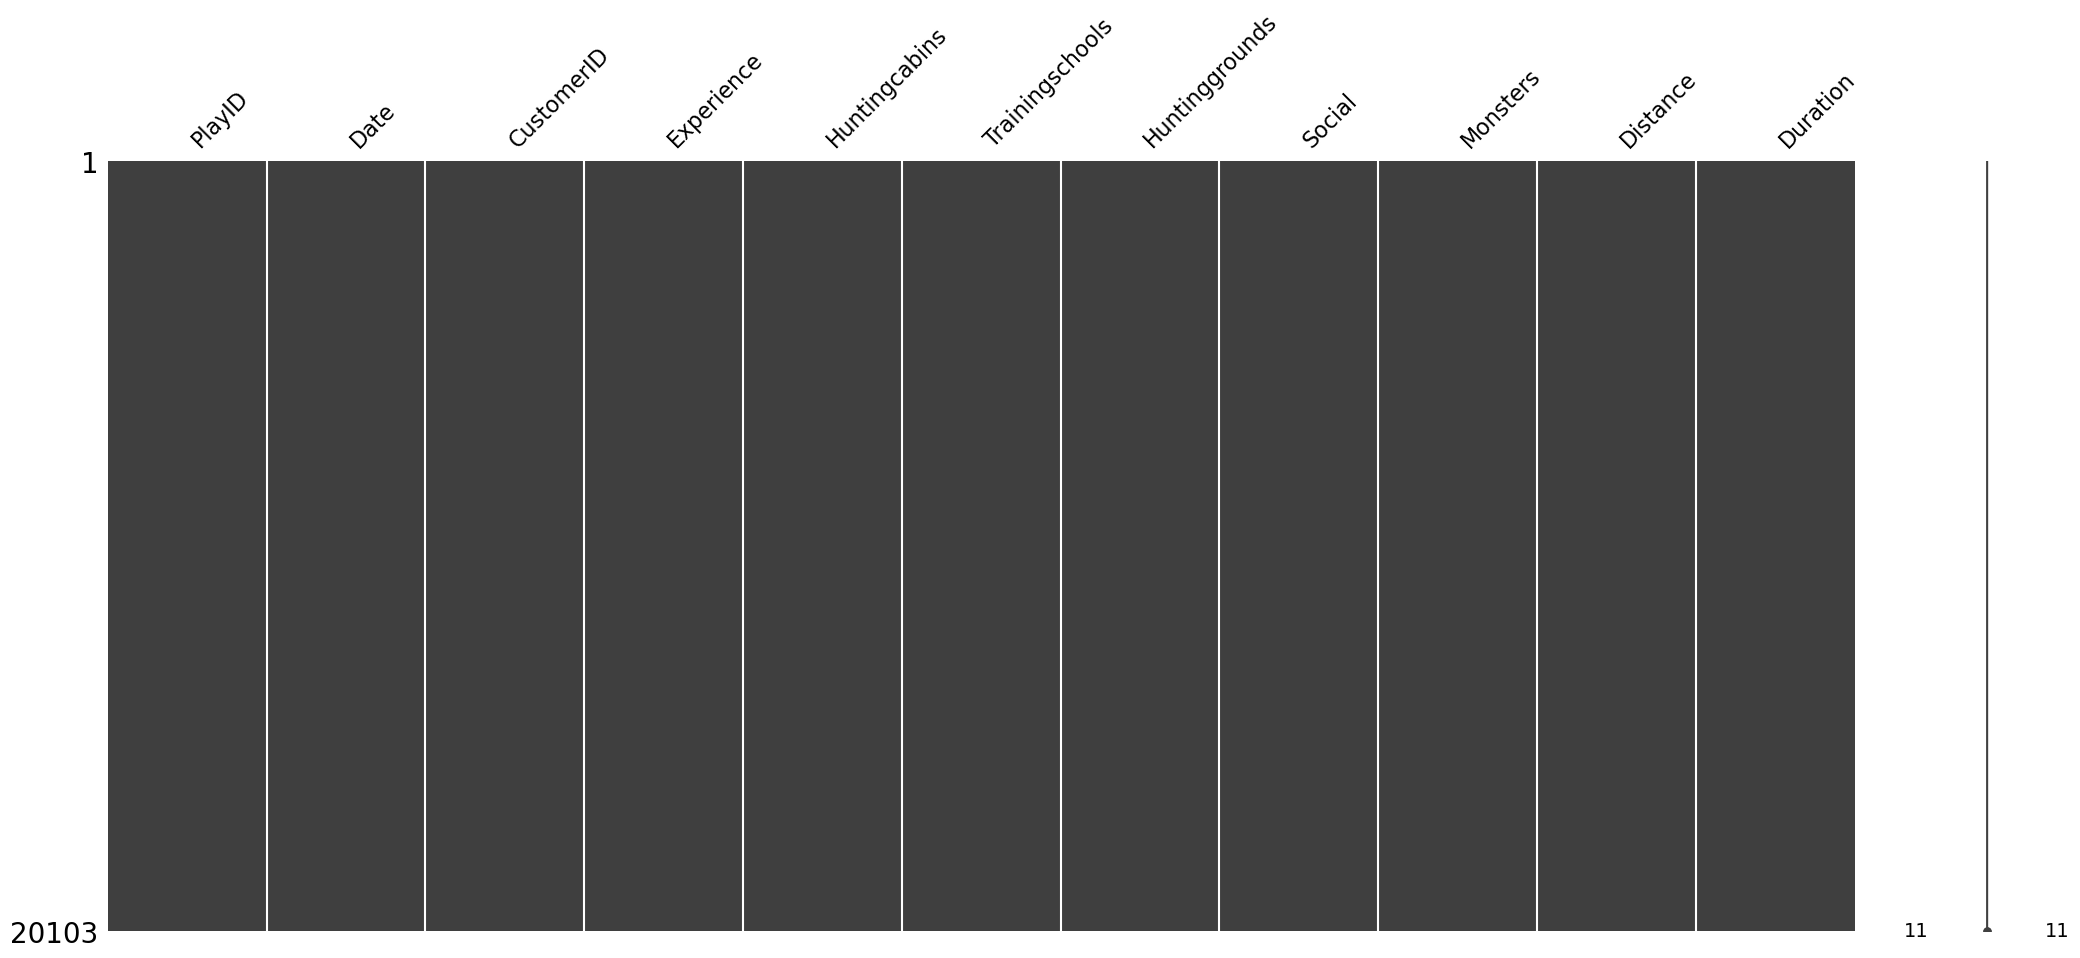

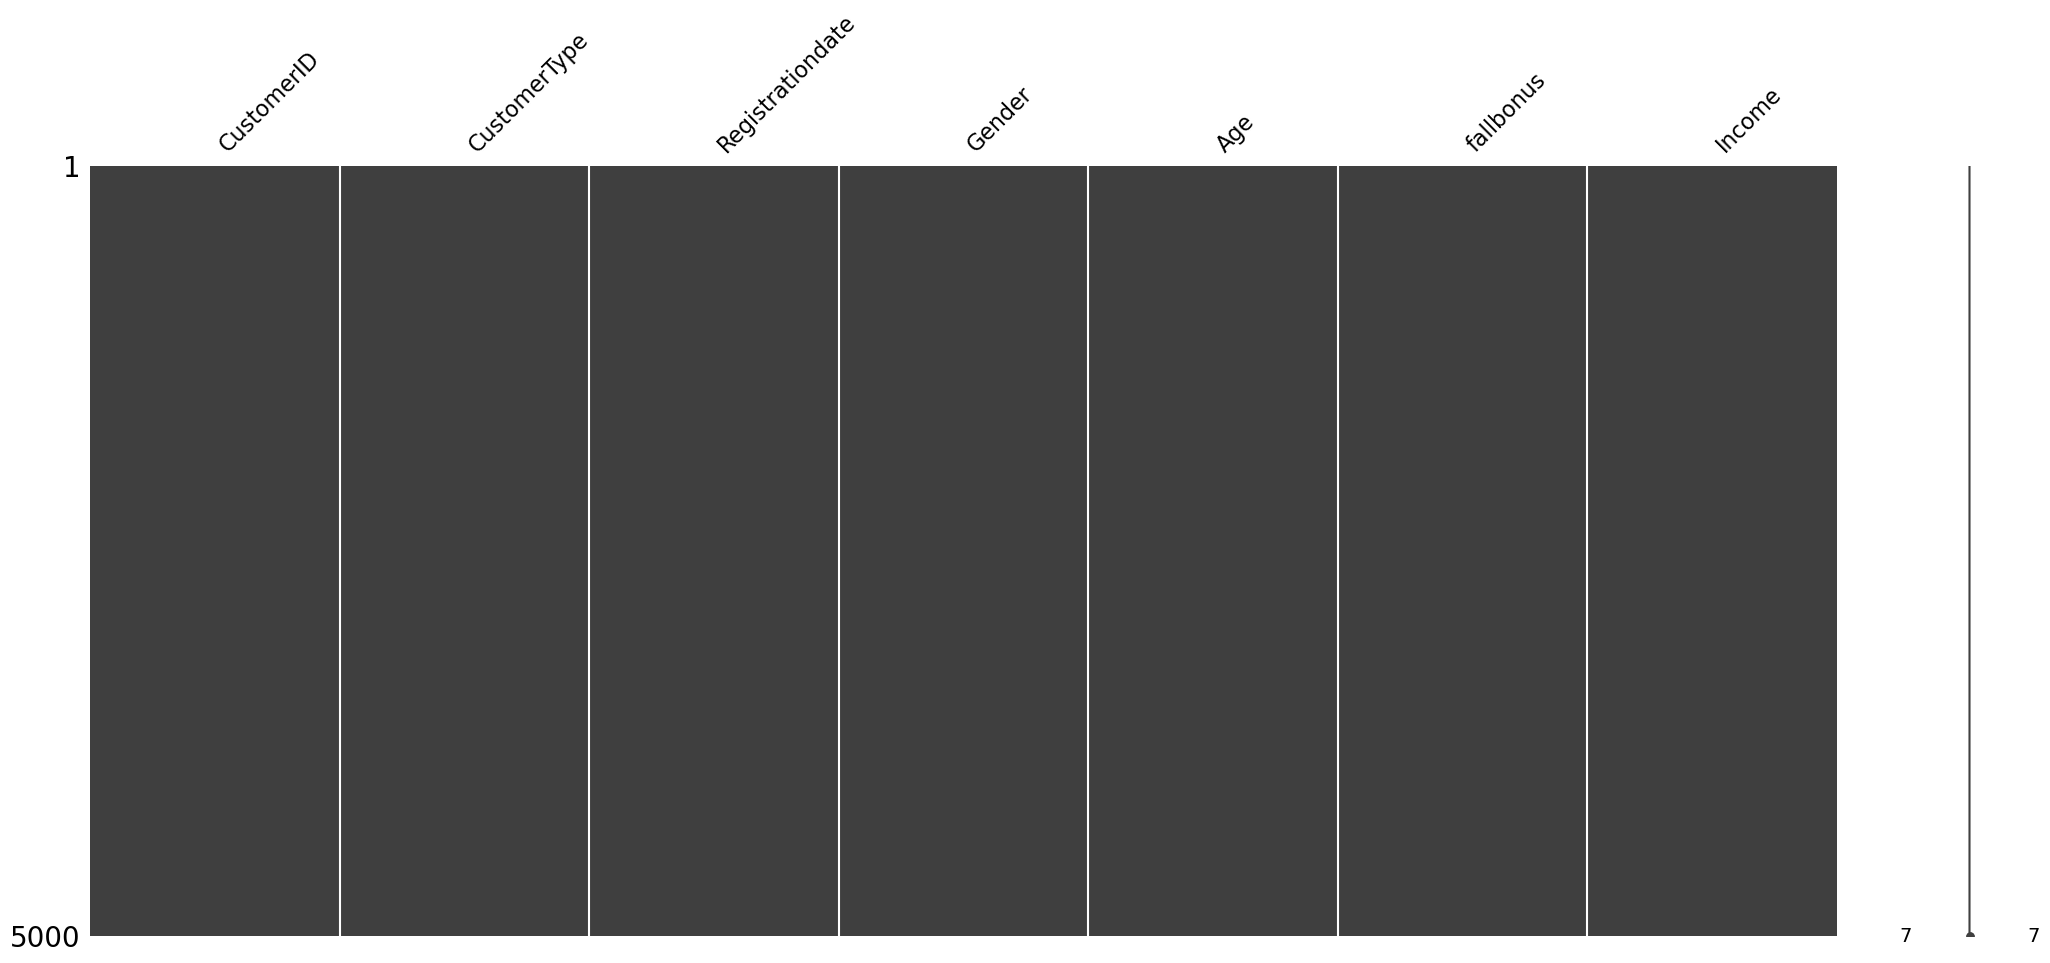

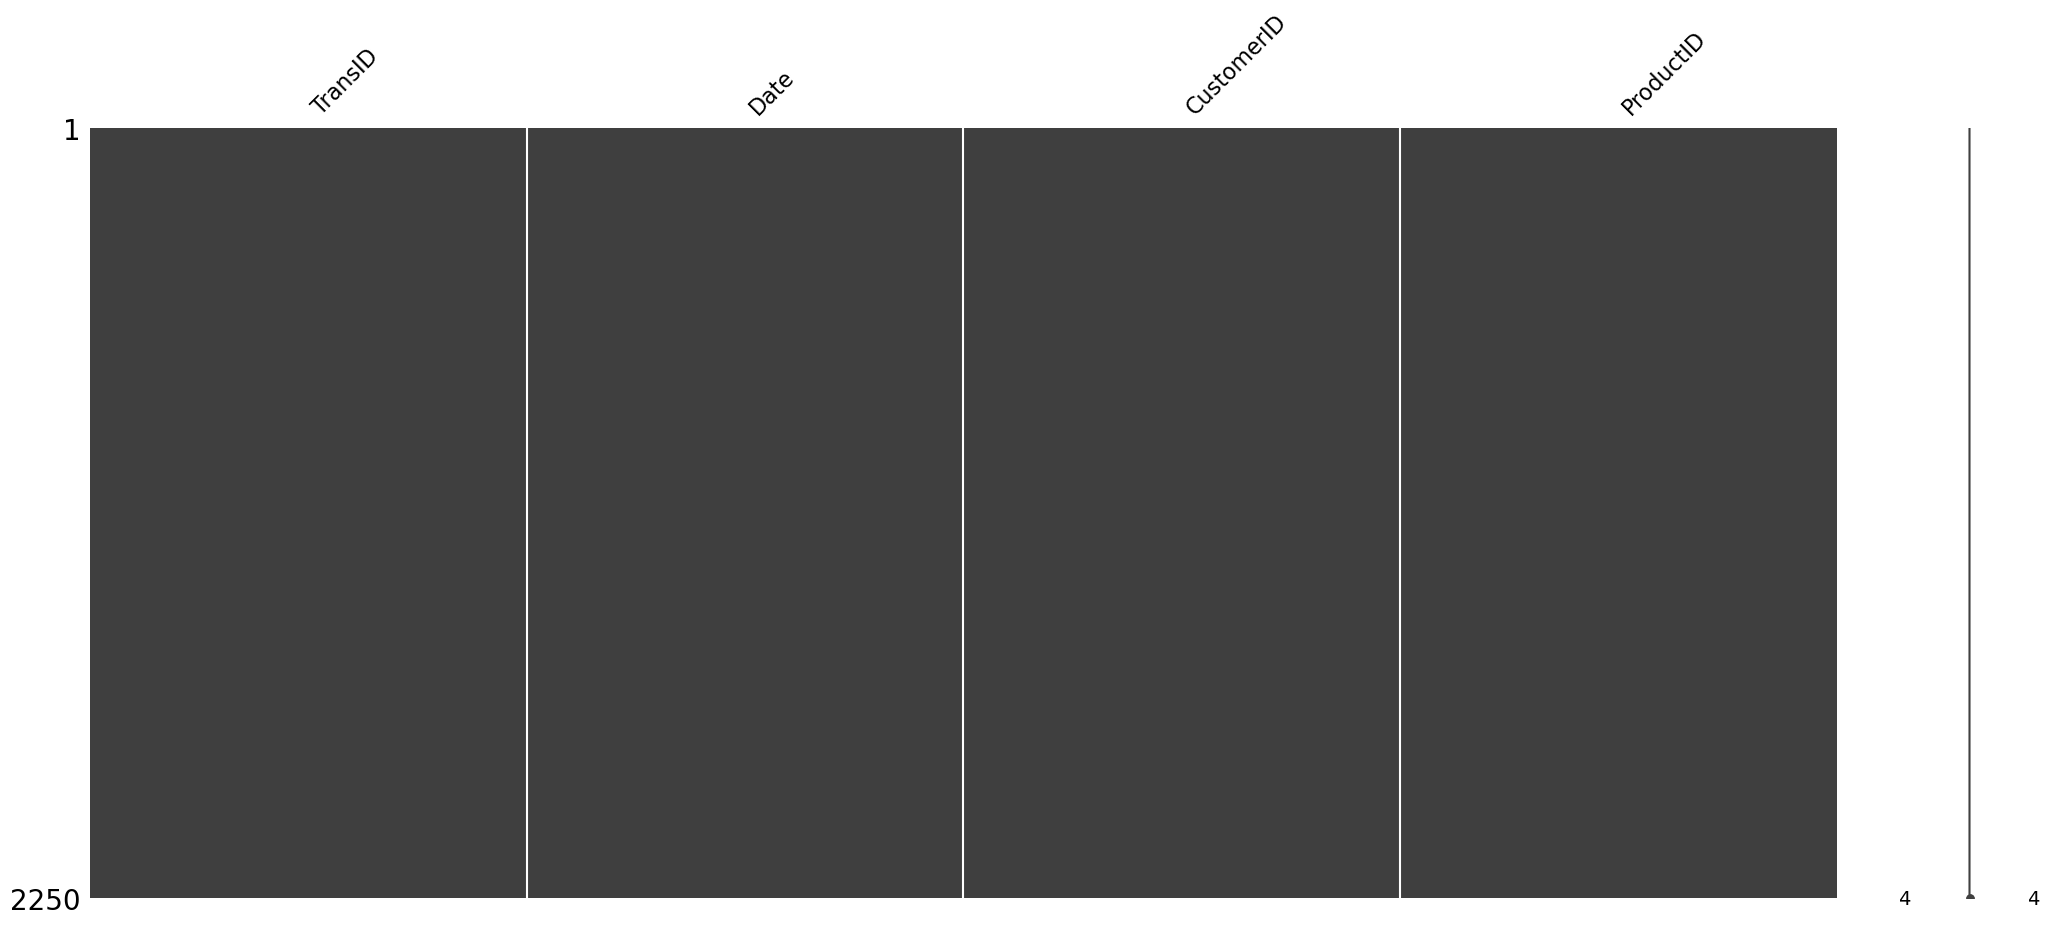

In [5]:
missingno.matrix(Summersesstrx)
plt.show()

missingno.matrix(customerdata)
plt.show()

missingno.matrix(summerfintrx)
plt.show()

**all three datasets have no missing values as showed in the images above.
as a next step we prepare and aggregate summer session data**

In [7]:
customerdata['Registrationdate'] = pd.to_datetime(customerdata['Registrationdate'])
Summersesstrx['Date'] = pd.to_datetime(Summersesstrx['Date'])
summerfintrx['Date'] = pd.to_datetime(summerfintrx['Date'])

In [8]:
def setwave(registrationdate):
    if registrationdate < pd.Timestamp('2021-01-01'):
        return 1
    elif registrationdate < pd.Timestamp('2022-01-01'):
        return 2
    else:
        return 3
customerdata['Wave']=customerdata['Registrationdate'].apply(lambda x: setwave(x))
customerdata

CustomerID  CustomerType Registrationdate  Gender  Age  fallbonus  \
0              1             4       2021-09-30       1    8          0   
1              2             4       2022-04-06       1   27          0   
2              3             3       2020-05-24       0    7          0   
3              4             4       2021-09-21       0   11          0   
4              5             4       2021-07-08       1   16          1   
...          ...           ...              ...     ...  ...        ...   
4995        4996             1       2022-03-18       0   42          0   
4996        4997             4       2022-04-02       1   30          1   
4997        4998             3       2022-03-11       1    9          0   
4998        4999             3       2022-04-28       0   30          1   
4999        5000             3       2020-05-28       1   18          0   

      Income  Wave  
0          1     2  
1          1     3  
2          2     1  
3          2     2  
4          1     2  
...      ...   ...  
4995       3     3  
4996       2     3  
4997       3     3  
4998       2     3  
4999       2     1  

[5000 rows x 8 columns]

In [9]:
today=datetime.datetime.strptime('2022-08-31','%Y-%m-%d')                                                      
summersesstrx = Summersesstrx.groupby('CustomerID', as_index=False).agg(
    PlayID=('PlayID','count'),
    date_min=('Date', 'min'),                    # First session date in the summer period
    Experience=('Experience', 'sum'),               # Total experience points
    Huntingcabins=('Huntingcabins', 'sum'),            # Total hunting cabins visited
    Trainingschools=('Trainingschools', 'sum'),          # Total training schools visited
    Huntinggrounds=('Huntinggrounds', 'sum'),           # Total hunting grounds visited
    Social=('Social', 'sum'),                   # Total social actions performed
    Monsters=('Monsters', 'sum'),                 # Total monsters caught
    Distance=('Distance', 'sum'),                  # Total distance walked
    Duration=('Duration', 'sum')                   # Total duration of play sessions
)   


print(f"Number of active customers in the summer: {len(summersesstrx)}")

Number of active customers in the summer: 4703


In [10]:
# Dummy var 
customerdata = customerdata.assign(
    walkers=[1 if CustomerType == 1 else 0 for CustomerType in customerdata['CustomerType']],
    socials=[1 if CustomerType == 3 else 0 for CustomerType in customerdata['CustomerType']],
    grinders=[1 if CustomerType == 4 else 0 for CustomerType in customerdata['CustomerType']],  # Added Grinders
    low_income=[1 if Income == 1 else 0 for Income in customerdata['Income']],
    medium_income=[1 if Income == 2 else 0 for Income in customerdata['Income']],
    first_wave=[1 if Wave == 1 else 0 for Wave in customerdata['Wave']],
    third_wave=[1 if Wave == 3 else 0 for Wave in customerdata['Wave']]

)

In [11]:
# Filter only active summer customers
active_summer_customer_data = pd.merge(
    customerdata,
    summersesstrx[['CustomerID']],
    on='CustomerID',
    how='inner'
)
active_summer_customer_data.to_csv('active_summer_customer_data.csv', index=False)
print(f"Number of active customers in the summer customerdata: {len(active_summer_customer_data)}")

active_summer_customer_data

Number of active customers in the summer customerdata: 4703


CustomerID  CustomerType Registrationdate  Gender  Age  fallbonus  \
0              1             4       2021-09-30       1    8          0   
1              2             4       2022-04-06       1   27          0   
2              3             3       2020-05-24       0    7          0   
3              4             4       2021-09-21       0   11          0   
4              5             4       2021-07-08       1   16          1   
...          ...           ...              ...     ...  ...        ...   
4698        4996             1       2022-03-18       0   42          0   
4699        4997             4       2022-04-02       1   30          1   
4700        4998             3       2022-03-11       1    9          0   
4701        4999             3       2022-04-28       0   30          1   
4702        5000             3       2020-05-28       1   18          0   

      Income  Wave  walkers  socials  grinders  low_income  medium_income  \
0          1     2        0        0         1           1              0   
1          1     3        0        0         1           1              0   
2          2     1        0        1         0           0              1   
3          2     2        0        0         1           0              1   
4          1     2        0        0         1           1              0   
...      ...   ...      ...      ...       ...         ...            ...   
4698       3     3        1        0         0           0              0   
4699       2     3        0        0         1           0              1   
4700       3     3        0        1         0           0              0   
4701       2     3        0        1         0           0              1   
4702       2     1        0        1         0           0              1   

      first_wave  third_wave  
0              0           0  
1              0           1  
2              1           0  
3              0           0  
4              0           0  
...          ...         ...  
4698           0           1  
4699           0           1  
4700           0           1  
4701           0           1  
4702           1           0  

[4703 rows x 15 columns]

In [12]:
# Calculate amount spent per customer based on product purchases
product_price_mapping = {
    1: 2.99,
    2: 4.99,
    3: 9.99,
    4: 25.00,
    5: 99.00
}

# Replace ProductID with actual price values
summerfintrx['Amount_spent'] = summerfintrx['ProductID'].replace(product_price_mapping)

summerfintrx = summerfintrx.groupby('CustomerID', as_index=False).agg(
    frequency=('TransID', 'count'),  # Count of transactions per customer
    monetary_value=('Amount_spent', 'sum'),  # Total spending per customer
    recency=('Date', lambda date: (today - date.max()).days),  # Days since last transaction
    first_purchase=('Date', 'min'), # Date of first transaction
    T=('Date', lambda x: (today - x.min()).days)
)

In [13]:
# Rename the dataset just to remember they are all active customers
active_summer_fin_trx = summerfintrx

In [14]:
summer_fin_sess = summersesstrx.merge(summerfintrx, on="CustomerID", how="left")
# Fill NaN values with 0
summer_fin_sess.fillna(0, inplace=True)
num_customers = summer_fin_sess[(summer_fin_sess['PlayID'] > 0) & (summer_fin_sess['frequency'] == 0)]['CustomerID'].nunique()

print(f"Number of customers who played at least once but never made a transaction: {num_customers}")

Number of customers who played at least once but never made a transaction: 2992


 **So all customers that made a transaction also played at least once, but 2992 customers played at least once and never made a transaction**

In [16]:
customersegm=active_summer_fin_trx.assign(
    segmfreq=lambda x: pd.cut(active_summer_fin_trx['frequency'], 
                                              bins=[0,1,2,3,4,5,99],
                                              labels=["1", "2", "3",'4','5','>5']),
    segmrec=lambda x: pd.cut(active_summer_fin_trx['recency'], 
                                              bins=[0,6,13,19,45,80,120],
                                              labels=["0-6 days", "7-13 days", "14-19 days",'20-45 days','46-80 days','>80 days']))

#convert to factor and reverse the order
customersegm['segmfreq']=pd.Categorical(customersegm['segmfreq'], categories=[">5","5", "4", "3","2","1"])
customersegm['segmrec']=pd.Categorical(customersegm['segmrec'], categories=[">80 days","46-80 days", "20-45 days", "14-19 days","7-13 days","0-6 days"])




In [17]:
customersegm = customersegm.merge(
    active_summer_customer_data[['CustomerID', 'Gender','CustomerType','Income']], 
    on='CustomerID', 
    how='left'
)
customersegm


CustomerID  frequency  monetary_value  recency first_purchase    T  \
0              5          3           19.97        9     2022-07-03   59   
1              9          1            4.99      115     2022-05-08  115   
2             10          1            4.99       23     2022-08-08   23   
3             17          1            4.99       39     2022-07-23   39   
4             20          1            2.99       60     2022-07-02   60   
...          ...        ...             ...      ...            ...  ...   
1706        4988          1            2.99       89     2022-06-03   89   
1707        4989          1            4.99        5     2022-08-26    5   
1708        4997          1            9.99       73     2022-06-19   73   
1709        4998          1            4.99       15     2022-08-16   15   
1710        5000          1            4.99       12     2022-08-19   12   

     segmfreq     segmrec  Gender  CustomerType  Income  
0           3   7-13 days       1             4       1  
1           1    >80 days       1             1       2  
2           1  20-45 days       0             1       3  
3           1  20-45 days       1             2       3  
4           1  46-80 days       0             1       3  
...       ...         ...     ...           ...     ...  
1706        1    >80 days       1             4       3  
1707        1    0-6 days       1             2       3  
1708        1  46-80 days       1             4       2  
1709        1  14-19 days       1             3       3  
1710        1   7-13 days       1             3       2  

[1711 rows x 11 columns]

In [18]:
active_summer_fin_trx = pd.merge(
    active_summer_fin_trx,
    active_summer_customer_data[['CustomerID', 'Income']],
    on='CustomerID',
    how='left'
)

In [19]:
active_summer_fin_trx = pd.merge(
    active_summer_fin_trx,
    summersesstrx[['CustomerID', 'PlayID', 'Distance', 'Social', 'Monsters','Duration','Experience', 'Huntingcabins', 'Trainingschools', 'Huntinggrounds']],
    on='CustomerID',
    how='left'
)

# Merge the 'Wave' variable into active_summer_fin_trx
active_summer_fin_trx = active_summer_fin_trx.merge(
    active_summer_customer_data[['CustomerID', 'Wave','Age']],
    on='CustomerID',
    how='left'
)


#  Spending by Customer Type
active_summer_fin_trx = pd.merge(active_summer_fin_trx, customerdata[['CustomerID', 'CustomerType']], on='CustomerID', how='left')
active_summer_fin_trx

CustomerID  frequency  monetary_value  recency first_purchase    T  \
0              5          3           19.97        9     2022-07-03   59   
1              9          1            4.99      115     2022-05-08  115   
2             10          1            4.99       23     2022-08-08   23   
3             17          1            4.99       39     2022-07-23   39   
4             20          1            2.99       60     2022-07-02   60   
...          ...        ...             ...      ...            ...  ...   
1706        4988          1            2.99       89     2022-06-03   89   
1707        4989          1            4.99        5     2022-08-26    5   
1708        4997          1            9.99       73     2022-06-19   73   
1709        4998          1            4.99       15     2022-08-16   15   
1710        5000          1            4.99       12     2022-08-19   12   

      Income  PlayID   Distance  Social  Monsters     Duration  Experience  \
0          1       1   5.044083       1        21    11.655042        3554   
1          2       7  49.734181       0       136   379.162098       32474   
2          3       9  78.121554      12       208   513.388091       40512   
3          3       4  20.213889       3        48   200.981482       14621   
4          3       5  37.586099       1        76   386.341581       19109   
...      ...     ...        ...     ...       ...          ...         ...   
1706       3       3   7.798816       1       105    82.023506       15680   
1707       3       6  24.252780       5        72   171.341376       22125   
1708       2       1   1.379467       0        55    27.570719        5338   
1709       3       9  13.821081      12       122  1110.024831       38484   
1710       2       2   2.429187       7        30   224.375956        9092   

      Huntingcabins  Trainingschools  Huntinggrounds  Wave  Age  CustomerType  
0                16                5               0     2   16             4  
1               130               71               0     1   34             1  
2               158               60               0     1   17             1  
3                56               19               3     3   12             2  
4                83               36               0     3    9             1  
...             ...              ...             ...   ...  ...           ...  
1706             53               34               0     3   17             4  
1707             94               37               3     2   30             2  
1708             17                8               0     3   30             4  
1709            108               66              10     3    9             3  
1710             27               13               2     1   18             3  

[1711 rows x 19 columns]

In [20]:
customersegm


CustomerID  frequency  monetary_value  recency first_purchase    T  \
0              5          3           19.97        9     2022-07-03   59   
1              9          1            4.99      115     2022-05-08  115   
2             10          1            4.99       23     2022-08-08   23   
3             17          1            4.99       39     2022-07-23   39   
4             20          1            2.99       60     2022-07-02   60   
...          ...        ...             ...      ...            ...  ...   
1706        4988          1            2.99       89     2022-06-03   89   
1707        4989          1            4.99        5     2022-08-26    5   
1708        4997          1            9.99       73     2022-06-19   73   
1709        4998          1            4.99       15     2022-08-16   15   
1710        5000          1            4.99       12     2022-08-19   12   

     segmfreq     segmrec  Gender  CustomerType  Income  
0           3   7-13 days       1             4       1  
1           1    >80 days       1             1       2  
2           1  20-45 days       0             1       3  
3           1  20-45 days       1             2       3  
4           1  46-80 days       0             1       3  
...       ...         ...     ...           ...     ...  
1706        1    >80 days       1             4       3  
1707        1    0-6 days       1             2       3  
1708        1  46-80 days       1             4       2  
1709        1  14-19 days       1             3       3  
1710        1   7-13 days       1             3       2  

[1711 rows x 11 columns]

# **Task 1: Create a demographic/behavioral description of the active player base during the summer**

## Demographic Insights (Gender, Age, Income)
 **(Who are the players?)**

*we understand the demographic characteristics of the players based on gender, age, and income distribution*

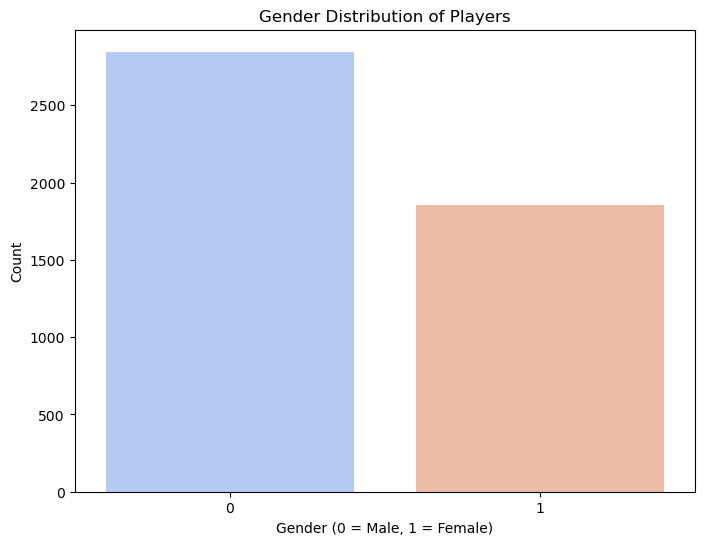

In [24]:
# Gender Distribution
plt.figure(figsize=(8,6))
sns.countplot(x='Gender', data=active_summer_customer_data, palette='coolwarm')
plt.title('Gender Distribution of Players')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Count')
plt.show()

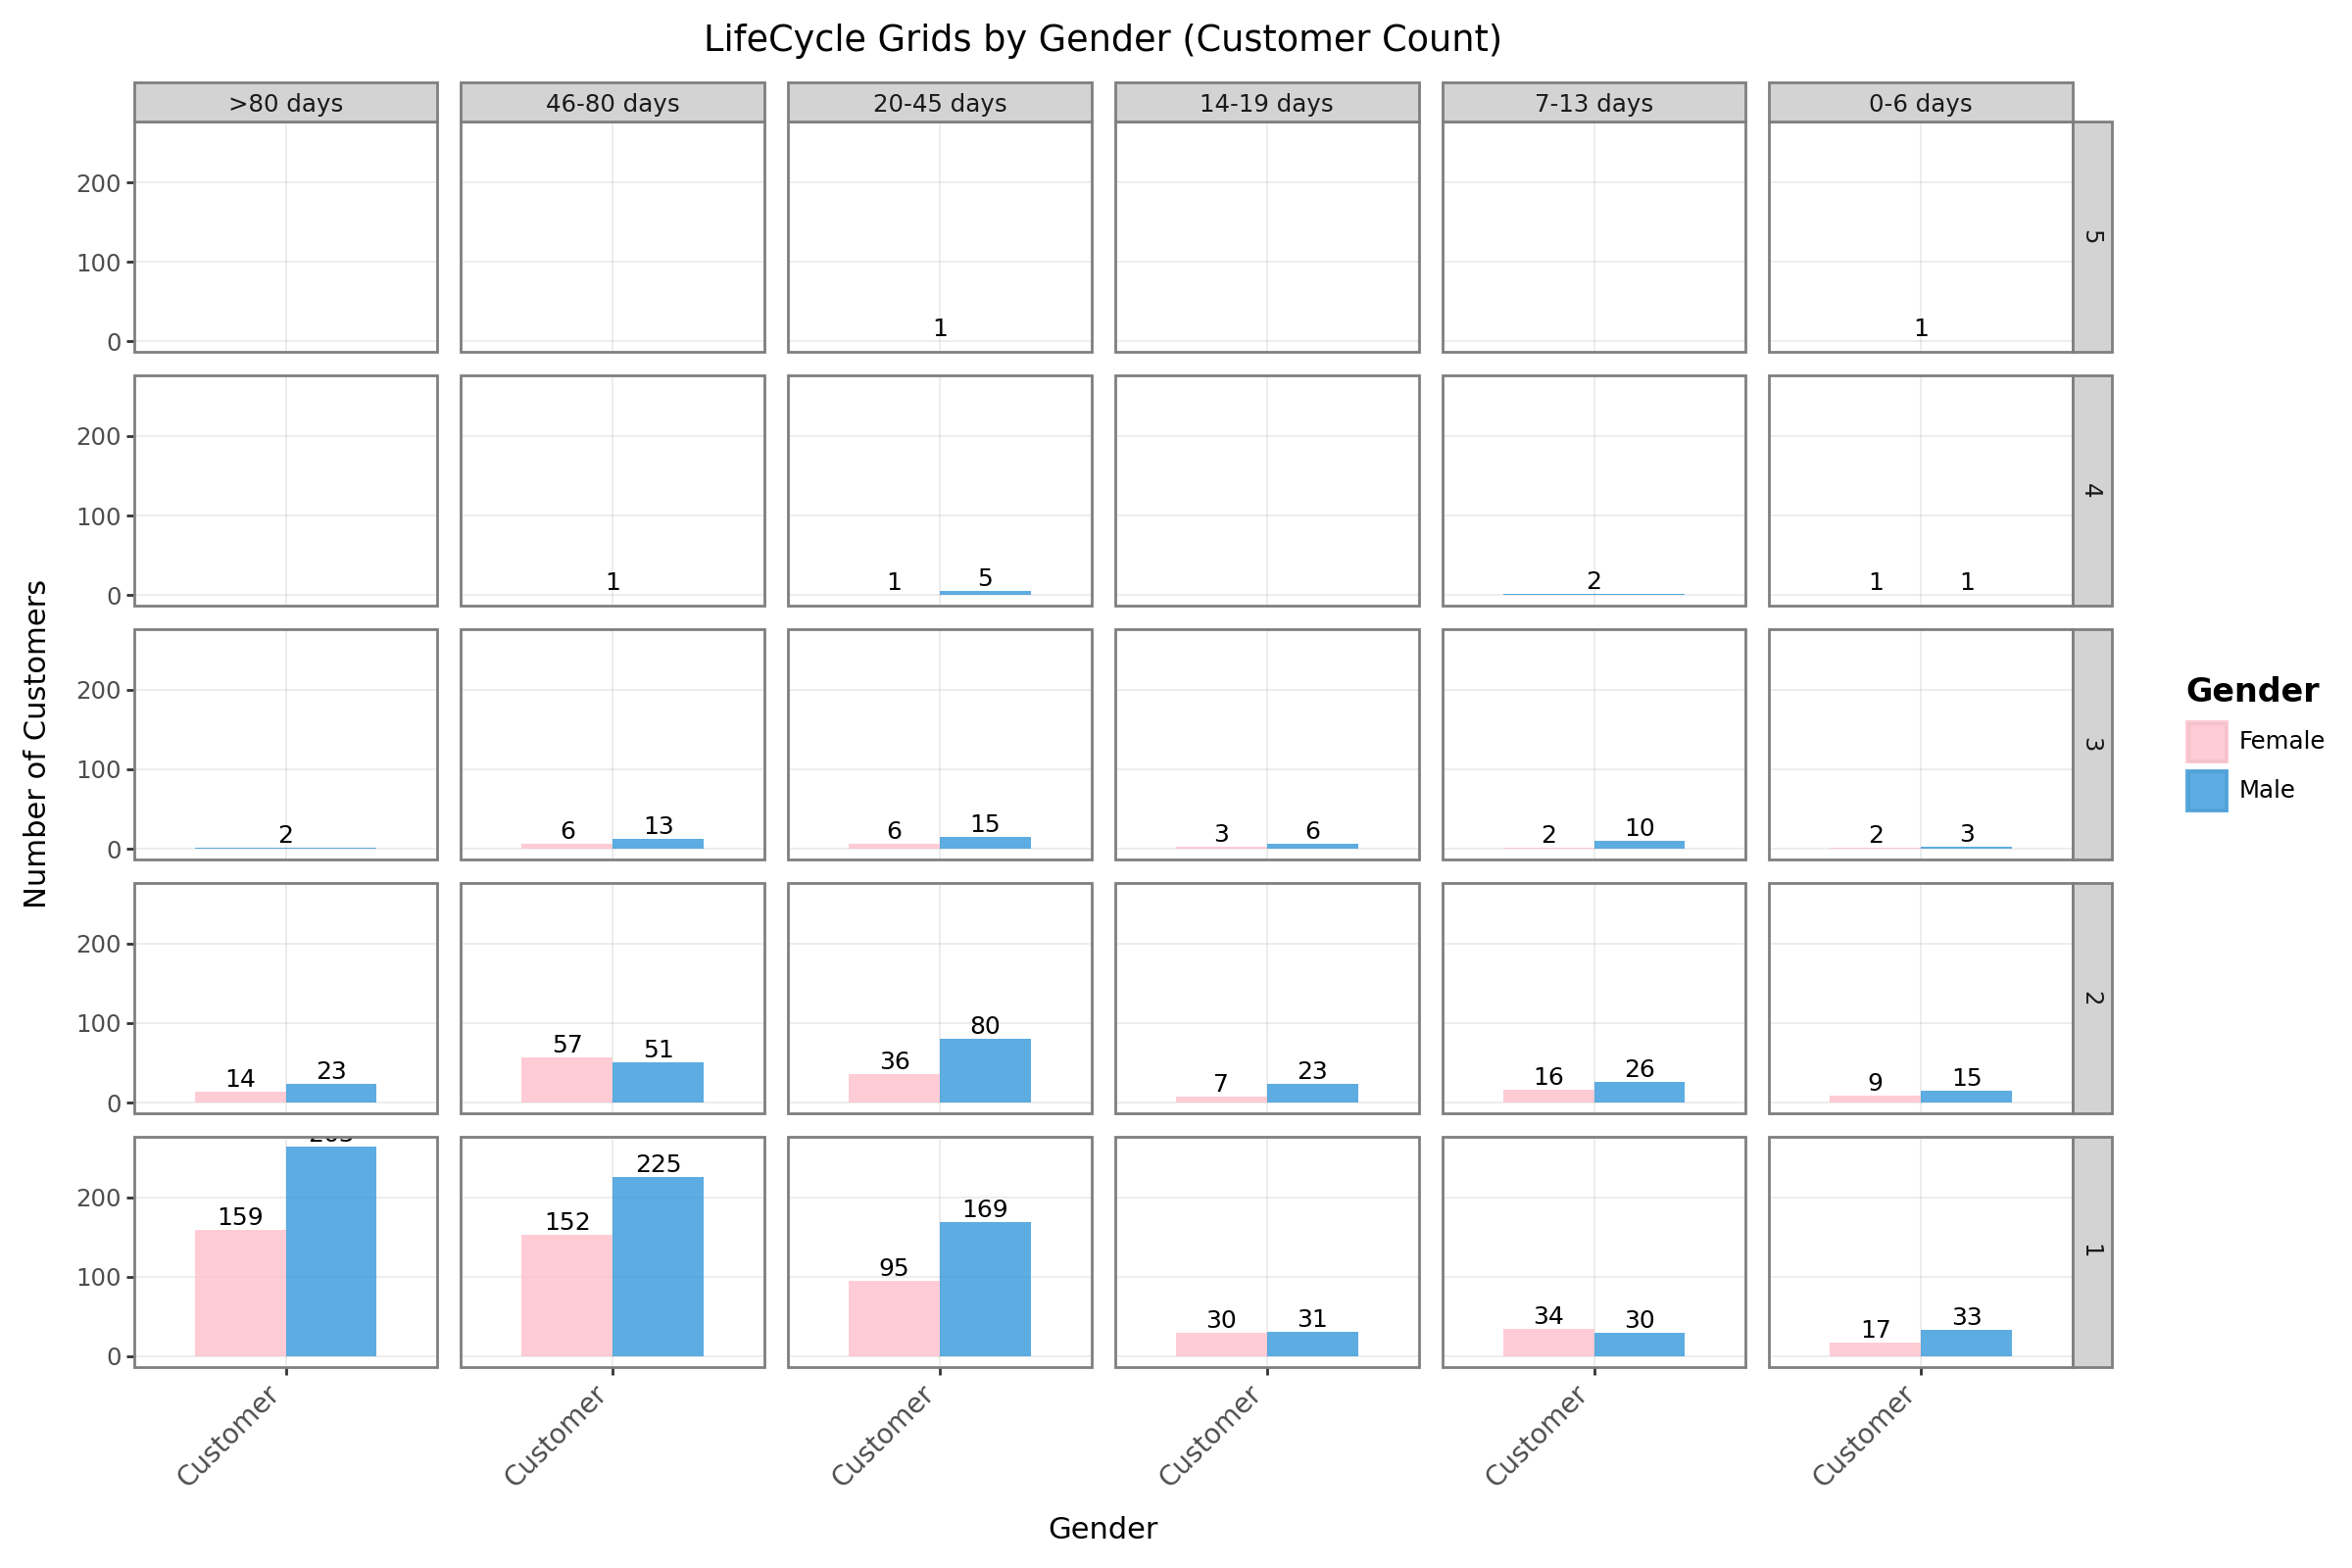

In [25]:
customersegm['Gender'] = customersegm['Gender'].map({0: 'Male', 1: 'Female'})

lcgsub=customersegm.groupby(['Gender','segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcgsub['CustomerID']='Customer'

# Create the plot
plot1 = (ggplot(lcgsub, aes(x='CustomerID', y='quantity', fill='Gender')) +
    theme_bw() +  
    theme(
        panel_grid_major=element_line(size=0.1, color="gray"),  
        panel_grid_minor=element_blank(),
        legend_title=element_text(size=12, weight="bold"),  
        legend_position="right",  
        strip_background=element_rect(fill="lightgray"),  
        axis_text_x=element_text(angle=45, ha='right', size=10),  # Rotate x-axis labels
        figure_size=(12, 8)  
    ) +
    geom_bar(stat='identity', position='dodge', alpha=0.8, width=0.6) +  
    geom_text(aes(label='quantity'), position=position_dodge(width=0.6), va='bottom', size=9) +  
    facet_grid('segmfreq ~ segmrec') +  
    ggtitle("LifeCycle Grids by Gender (Customer Count)") +
    xlab("Gender") +
    ylab("Number of Customers") +
    scale_fill_manual(values=['#FFC0CB', '#3498DB'])  # Pink for Female, Blue for Male
)

plot1.show()

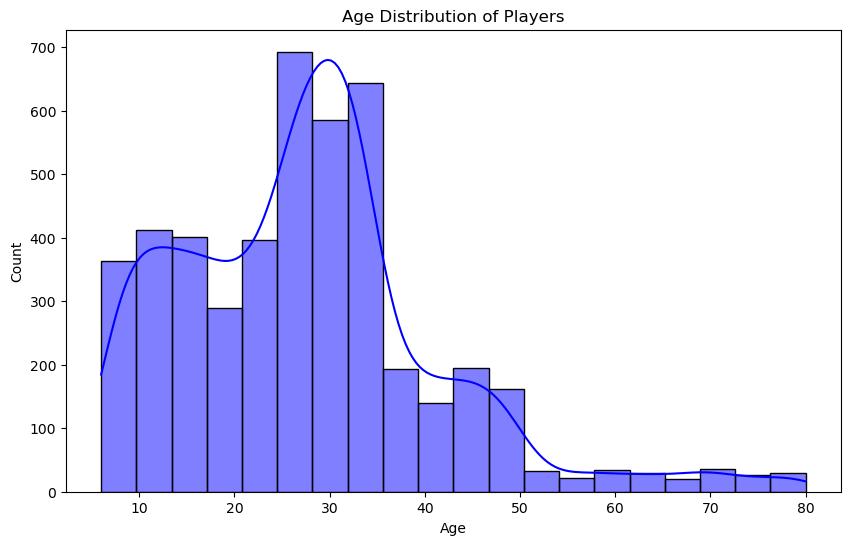

In [26]:
# Age Distribution
plt.figure(figsize=(10,6))
sns.histplot(active_summer_customer_data['Age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution of Players')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

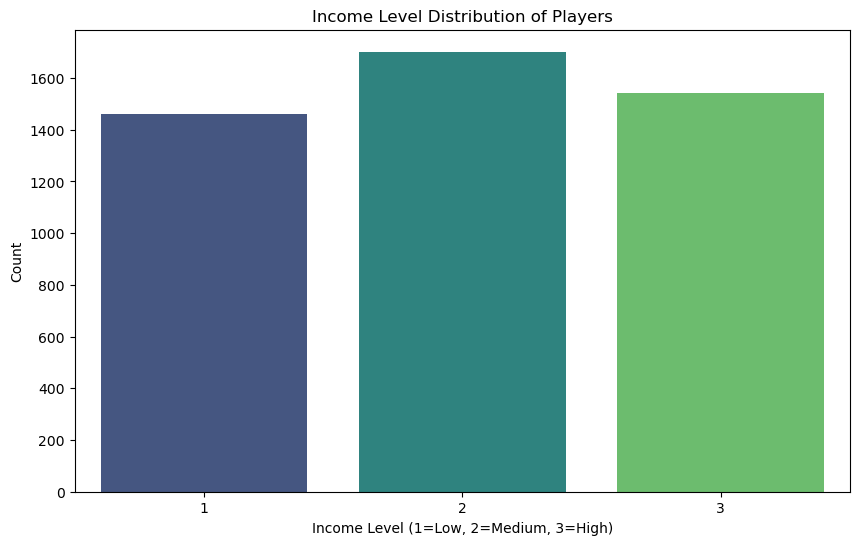

In [27]:
# Income Level Distribution
plt.figure(figsize=(10,6))
sns.countplot(x='Income', data=active_summer_customer_data, palette='viridis')
plt.title('Income Level Distribution of Players')
plt.xlabel('Income Level (1=Low, 2=Medium, 3=High)')
plt.ylabel('Count')
plt.show()

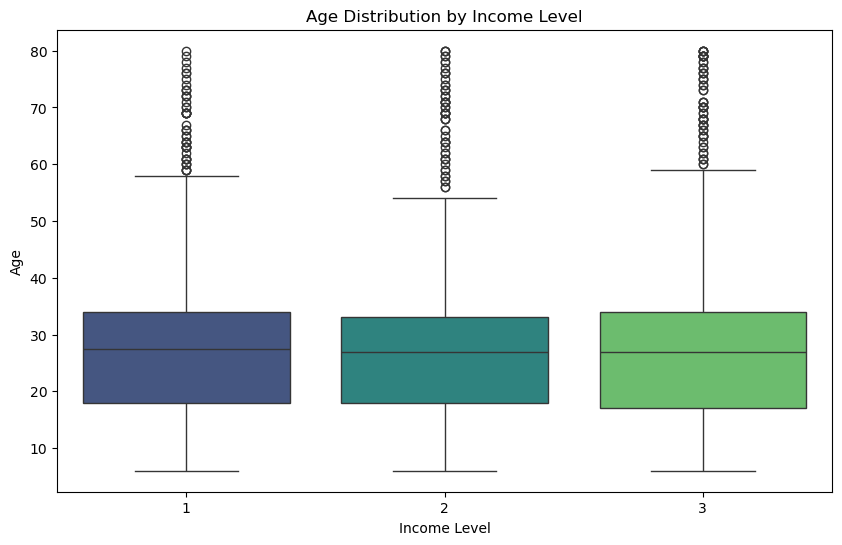

In [28]:
# Age Distribution by Income Level
plt.figure(figsize=(10,6))
sns.boxplot(x='Income', y='Age', data=active_summer_customer_data, palette='viridis')
plt.title('Age Distribution by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Age')
plt.show()

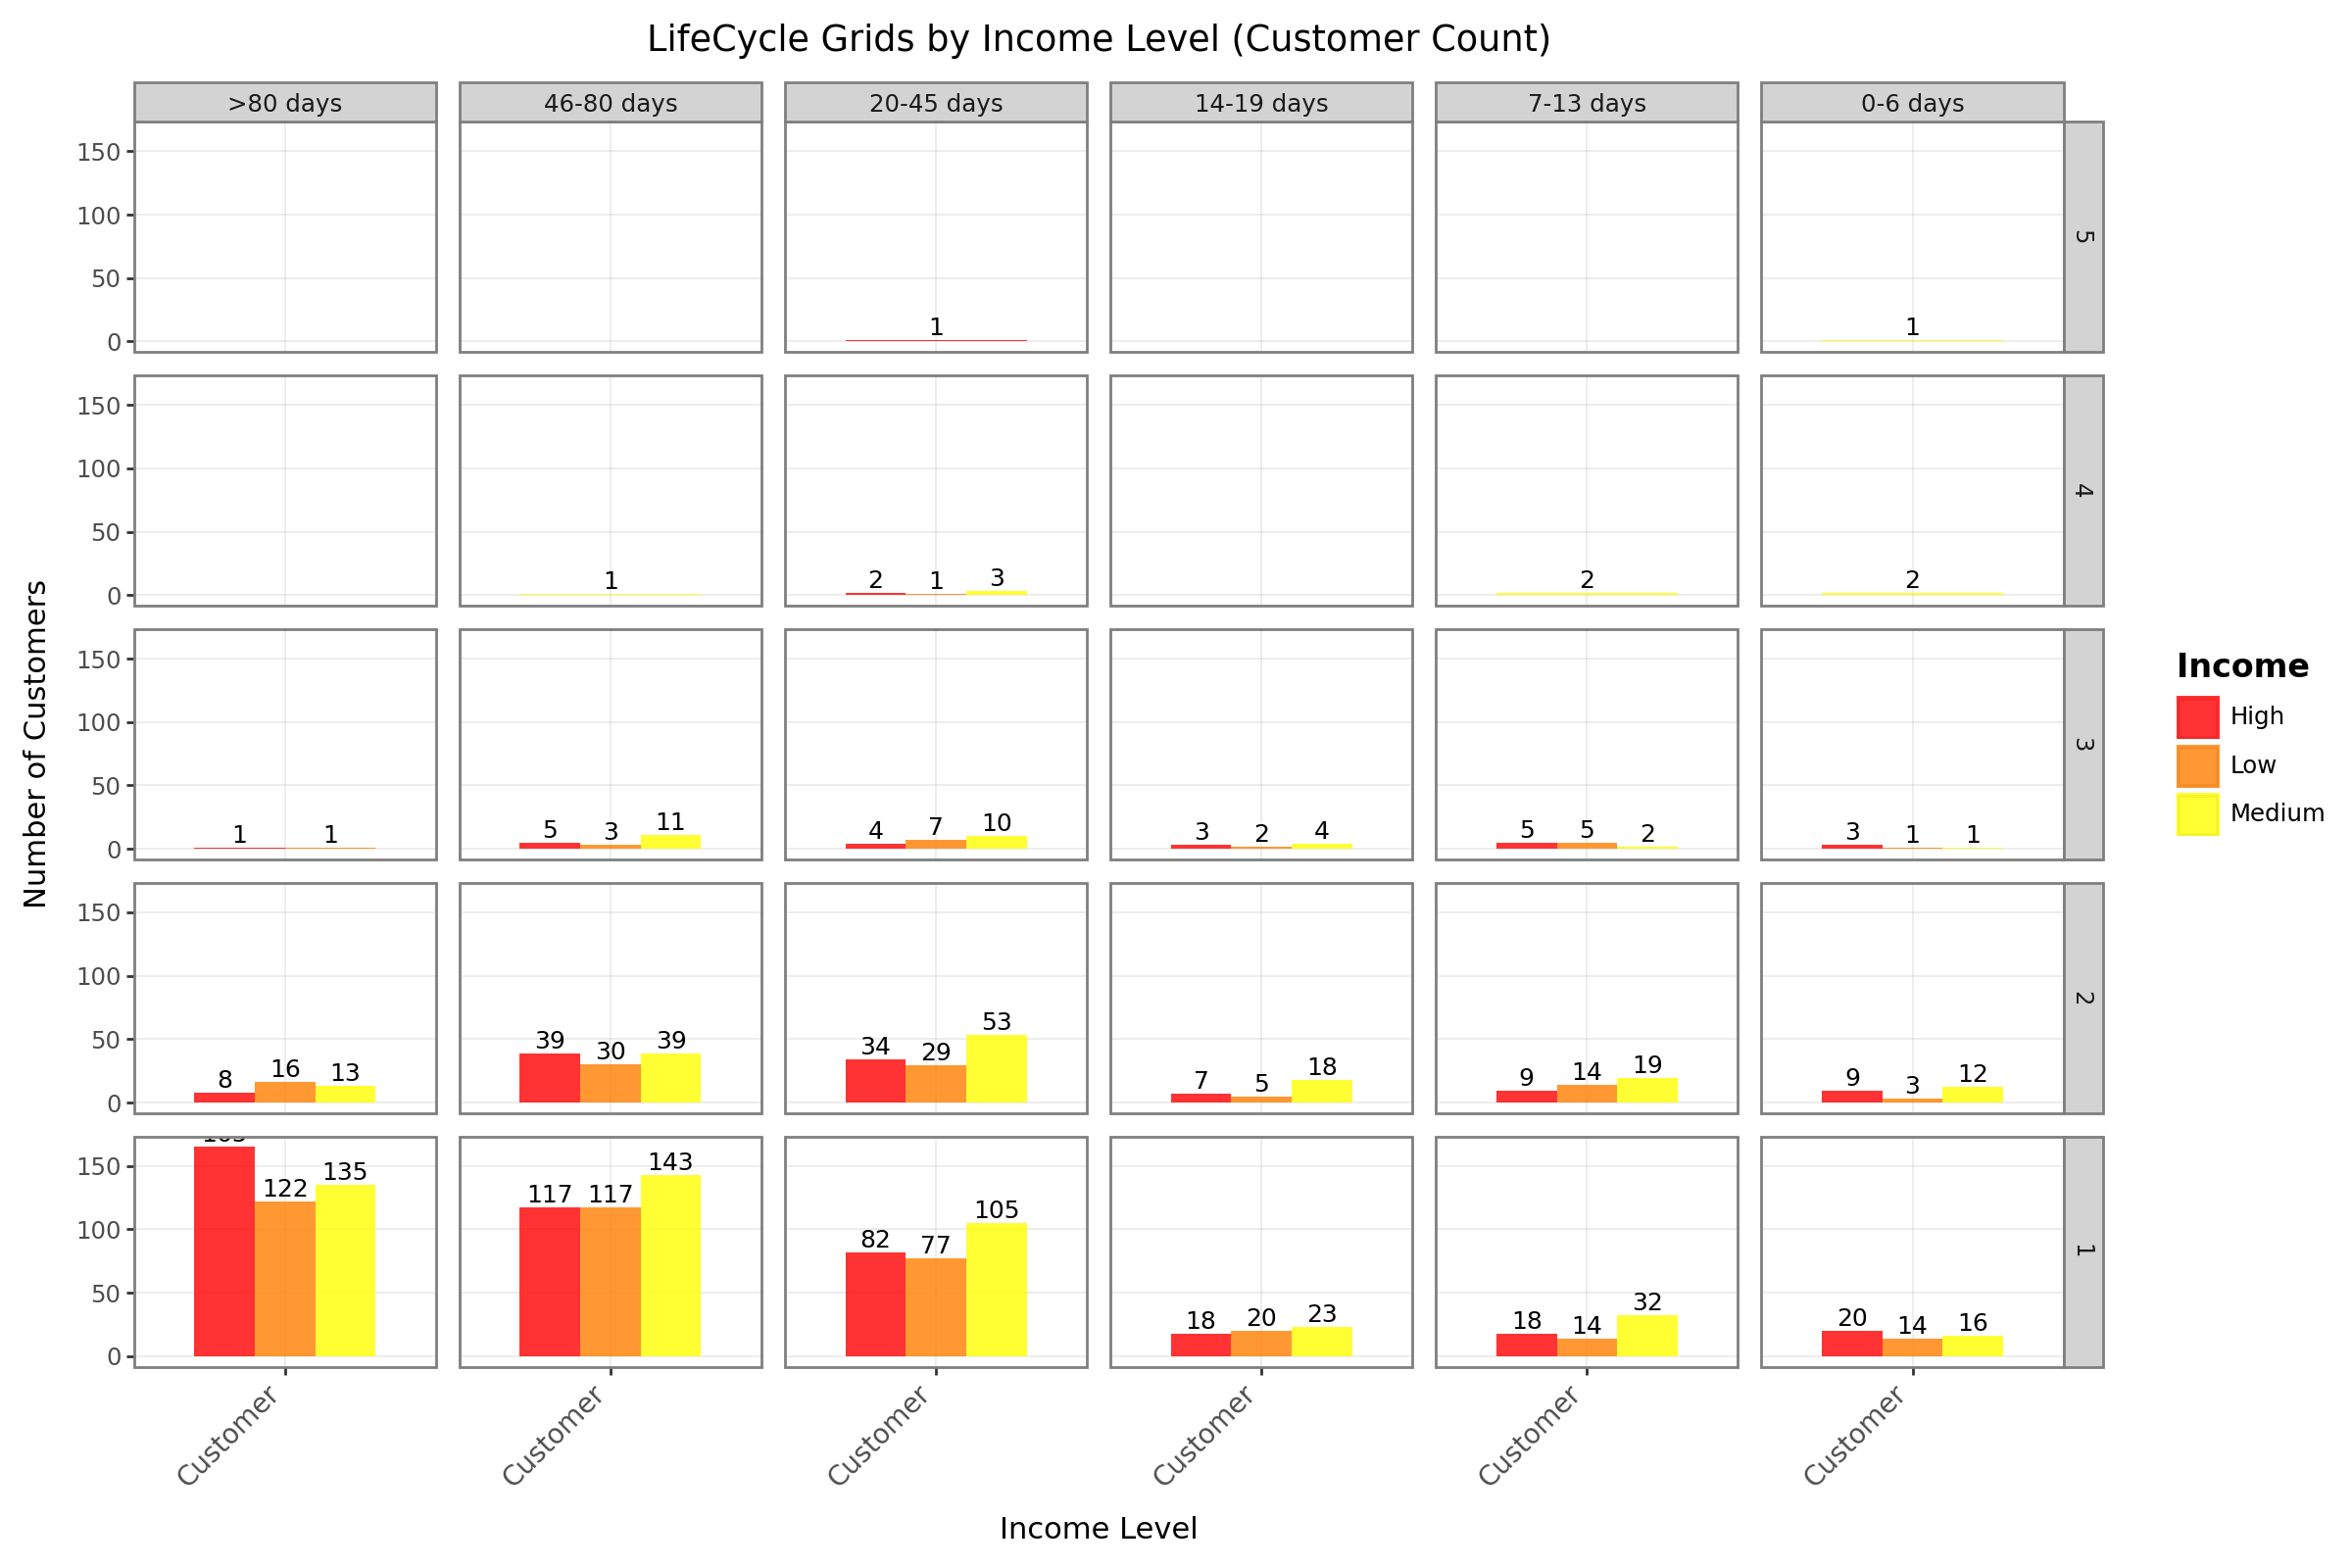

In [29]:
# Mapping Income values to descriptive labels
customersegm['Income'] = customersegm['Income'].map({1: 'Low', 2: 'Medium', 3: 'High'})

lcgsub = customersegm.groupby(['Income', 'segmfreq', 'segmrec'], observed=True, as_index=False).agg(quantity=('CustomerID', 'count'))
lcgsub['CustomerID'] = 'Customer'

# Create the plot
plot3 = (ggplot(lcgsub, aes(x='CustomerID', y='quantity', fill='Income')) +
    theme_bw() +  
    theme(
        panel_grid_major=element_line(size=0.1, color="gray"),  
        panel_grid_minor=element_blank(),
        legend_title=element_text(size=12, weight="bold"),  
        legend_position="right",  
        strip_background=element_rect(fill="lightgray"),  
        axis_text_x=element_text(angle=45, ha='right', size=10),  # Rotate x-axis labels
        figure_size=(12, 8)  # Increase figure size
    ) +
    geom_bar(stat='identity', position='dodge', alpha=0.8, width=0.6) +  
    geom_text(aes(label='quantity'), position=position_dodge(width=0.6), va='bottom', size=9) +  # Show count inside bars
    facet_grid('segmfreq ~ segmrec') +  
    ggtitle("LifeCycle Grids by Income Level (Customer Count)") +
    xlab("Income Level") +
    ylab("Number of Customers") +
    scale_fill_manual(values=['#FF0000', '#FF7F00', '#FFFF00'])  # Red for Low, Orange for Medium, Yellow for High
)

# Show the updated plot
plot3.show()

## Behavioral Insights (How do they play and spend?)

**Player Behavior (When have they started and how do they play?)**

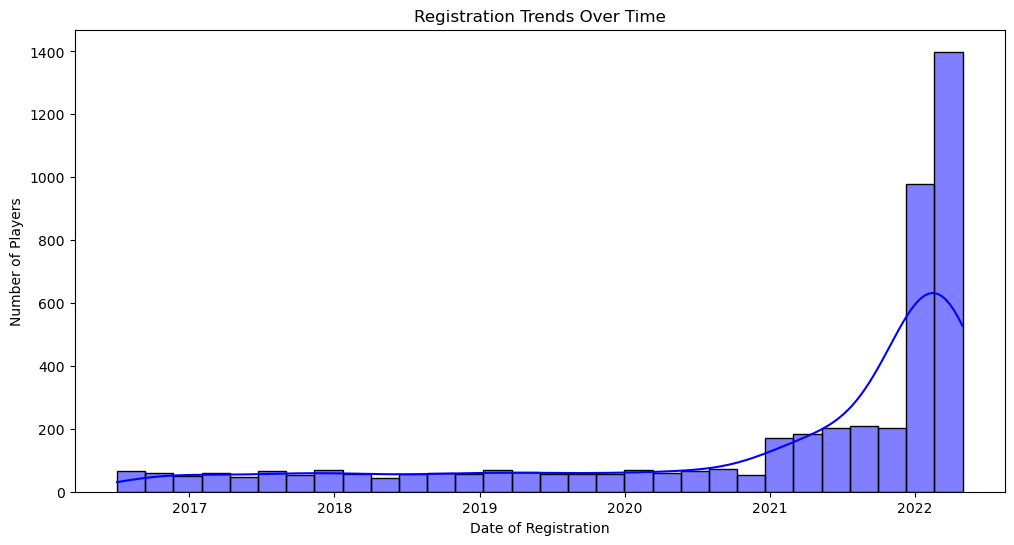

In [32]:
#Registration over time
plt.figure(figsize=(12,6))
sns.histplot(active_summer_customer_data['Registrationdate'], bins=30, kde=True, color='blue')
plt.title('Registration Trends Over Time')
plt.xlabel('Date of Registration')
plt.ylabel('Number of Players')
plt.show()

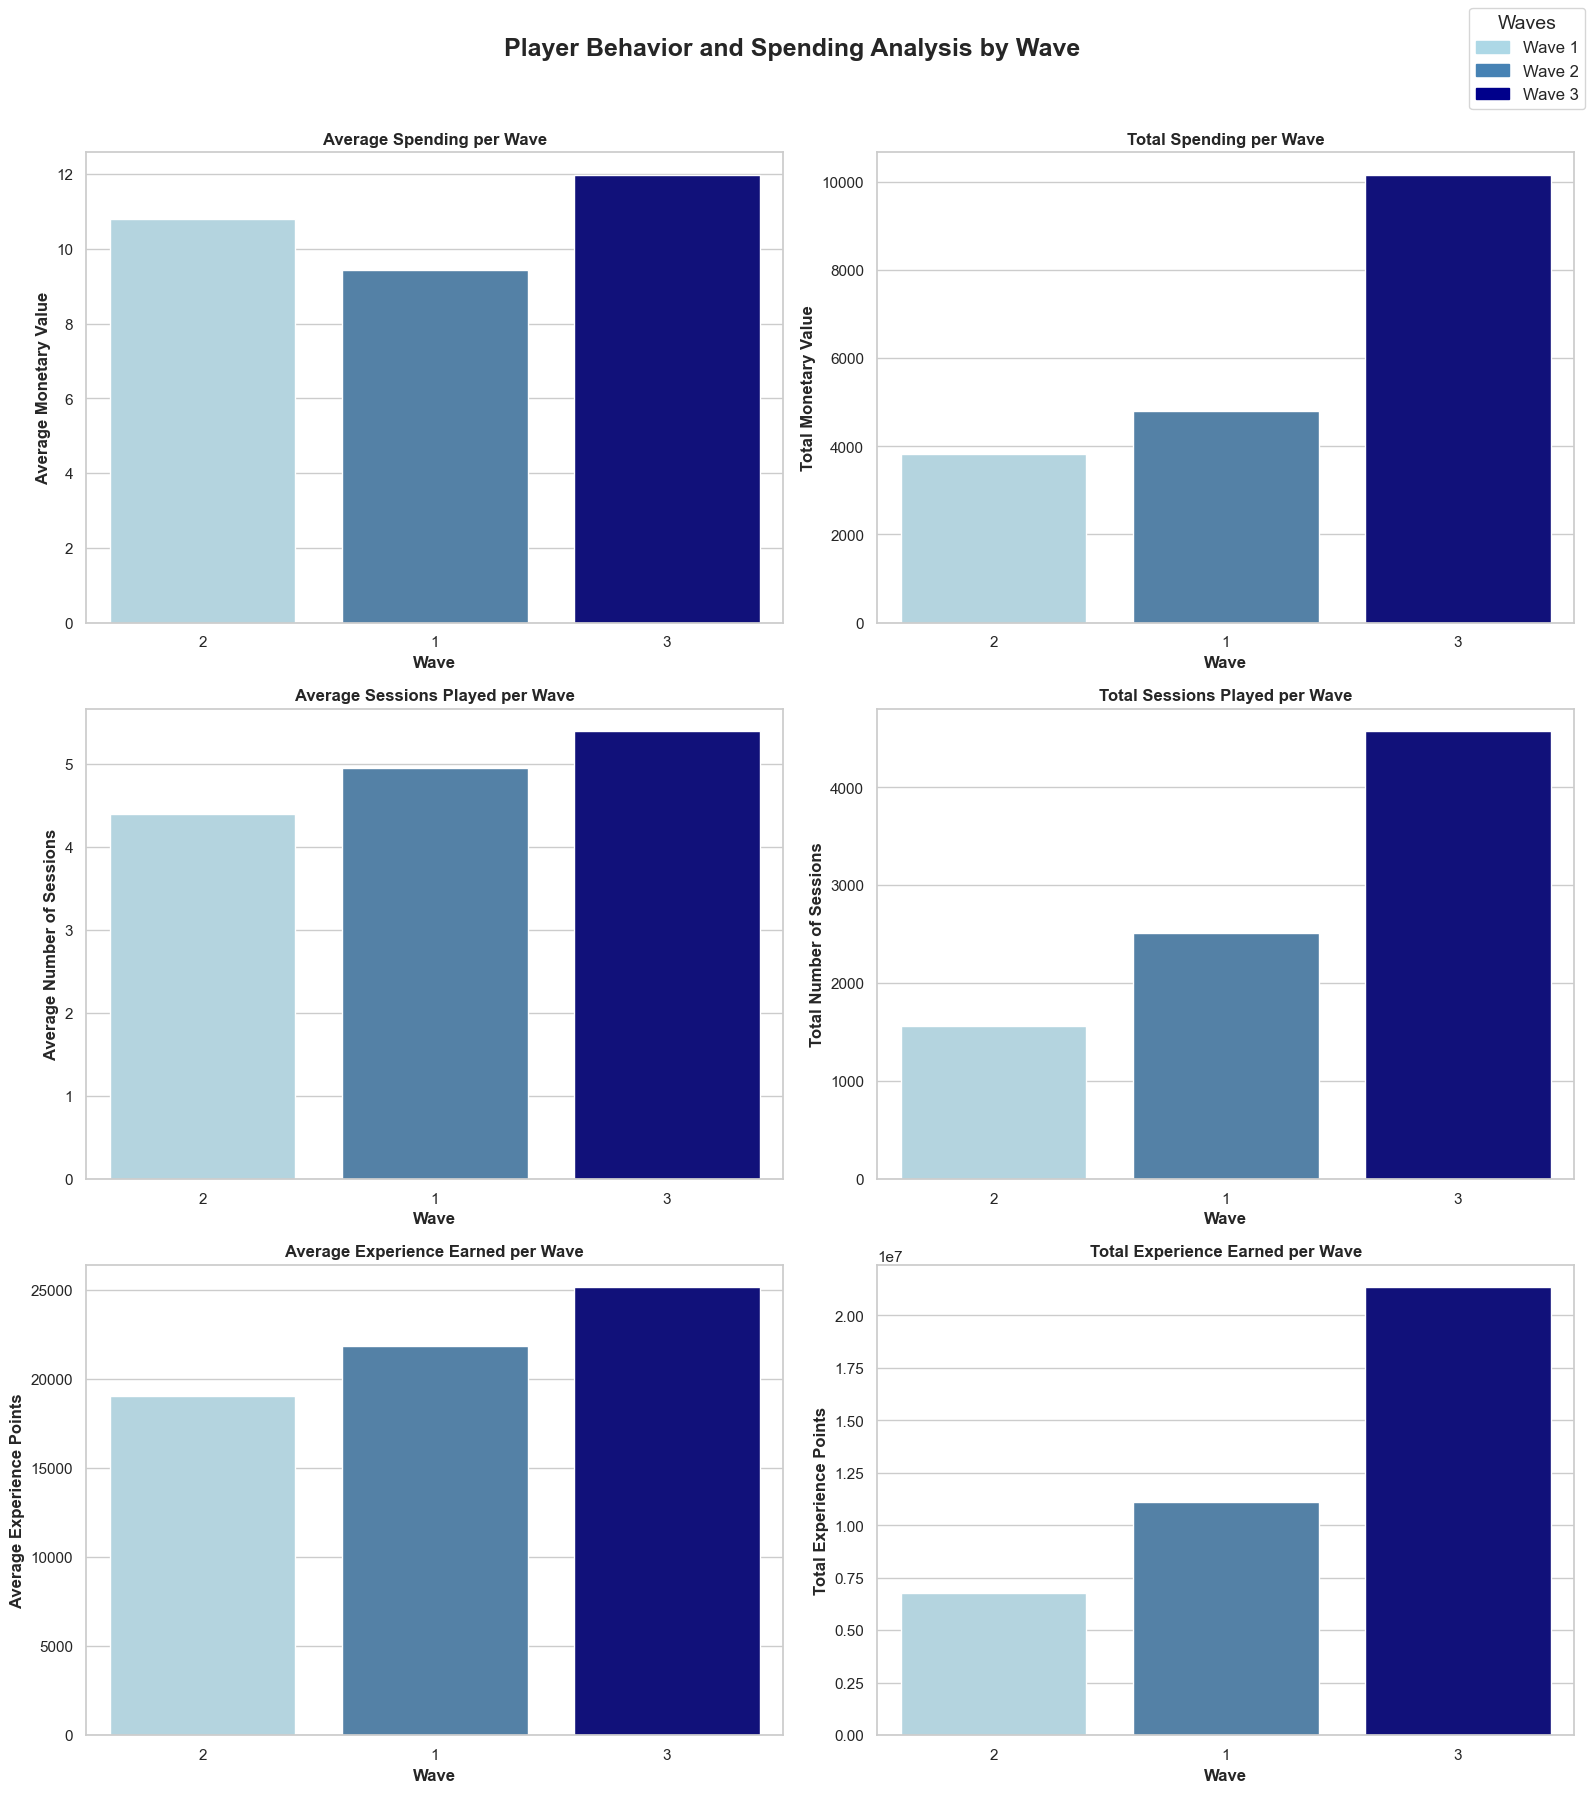

In [33]:

# Convert 'Wave' to categorical for better plotting
active_summer_fin_trx['Wave'] = active_summer_fin_trx['Wave'].astype(str)



# Define custom colors for waves
wave_colors = ["#ADD8E6", "#4682B4", "#00008B"]  # Light Blue, Medium Blue, Dark Blue

# Set figure style
sns.set_theme(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Player Behavior and Spending Analysis by Wave", fontsize=18, fontweight="bold")

# --- Spending Behavior by Wave ---
# 1. Average Spending per Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='monetary_value', estimator='mean', ci=None, ax=axes[0, 0], palette=wave_colors)
axes[0, 0].set_title("Average Spending per Wave", fontweight="bold")
axes[0, 0].set_xlabel("Wave", fontweight="bold")
axes[0, 0].set_ylabel("Average Monetary Value", fontweight="bold")

# 2. Total Spending per Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='monetary_value', estimator='sum', ci=None, ax=axes[0, 1], palette=wave_colors)
axes[0, 1].set_title("Total Spending per Wave", fontweight="bold")
axes[0, 1].set_xlabel("Wave", fontweight="bold")
axes[0, 1].set_ylabel("Total Monetary Value", fontweight="bold")

# --- Playing Behavior by Wave ---
# 3. Average Sessions Played per Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='PlayID', estimator='mean', ci=None, ax=axes[1, 0], palette=wave_colors)
axes[1, 0].set_title("Average Sessions Played per Wave", fontweight="bold")
axes[1, 0].set_xlabel("Wave", fontweight="bold")
axes[1, 0].set_ylabel("Average Number of Sessions", fontweight="bold")

# 4. Total Sessions Played per Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='PlayID', estimator='sum', ci=None, ax=axes[1, 1], palette=wave_colors)
axes[1, 1].set_title("Total Sessions Played per Wave", fontweight="bold")
axes[1, 1].set_xlabel("Wave", fontweight="bold")
axes[1, 1].set_ylabel("Total Number of Sessions", fontweight="bold")

# --- Experience Points Earned per Wave ---
# 5. Average Experience Earned per Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='Experience', estimator='mean', ci=None, ax=axes[2, 0], palette=wave_colors)
axes[2, 0].set_title("Average Experience Earned per Wave", fontweight="bold")
axes[2, 0].set_xlabel("Wave", fontweight="bold")
axes[2, 0].set_ylabel("Average Experience Points", fontweight="bold")

# 6. Total Experience Earned per Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='Experience', estimator='sum', ci=None, ax=axes[2, 1], palette=wave_colors)
axes[2, 1].set_title("Total Experience Earned per Wave", fontweight="bold")
axes[2, 1].set_xlabel("Wave", fontweight="bold")
axes[2, 1].set_ylabel("Total Experience Points", fontweight="bold")

# Create a custom legend for the wave colors
handles = [plt.Rectangle((0,0),1,1, color=wave_colors[i]) for i in range(3)]
labels = ["Wave 1", "Wave 2", "Wave 3"]
fig.legend(handles, labels, title="Waves", loc="upper right", fontsize=12, title_fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plots
plt.show()

Spending behavior shows that Wave 3, the newest players, have the highest average and total spending, indicating strong early investment. This suggests improved monetization strategies or a more engaged new player base. Wave 1, consisting of older players, spends slightly less on average but still contributes significantly in total. Wave 2 lags behind, possibly due to weaker engagement during their registration period.

Playing behavior follows a similar trend. Wave 3 players are the most active, leading in both average and total sessions played. This suggests that newer players are more engaged early on, possibly due to game design improvements. Wave 1 players remain active, reflecting a loyal and retained player base, while Wave 2 again shows lower engagement.

Experience accumulation further supports this pattern. Wave 3 players earn the most experience per session, progressing faster, while Wave 1 maintains steady long-term growth. Wave 2 remains the least engaged.

Overall, the data suggests that newer players are spending more, playing more, and progressing faster, likely due to recent game updates. Wave 1 remains consistent and engaged, while Wave 2 appears to have been a weaker cohort. Moving forward, the challenge will be retaining Wave 3 players long-term and re-engaging Wave 2.

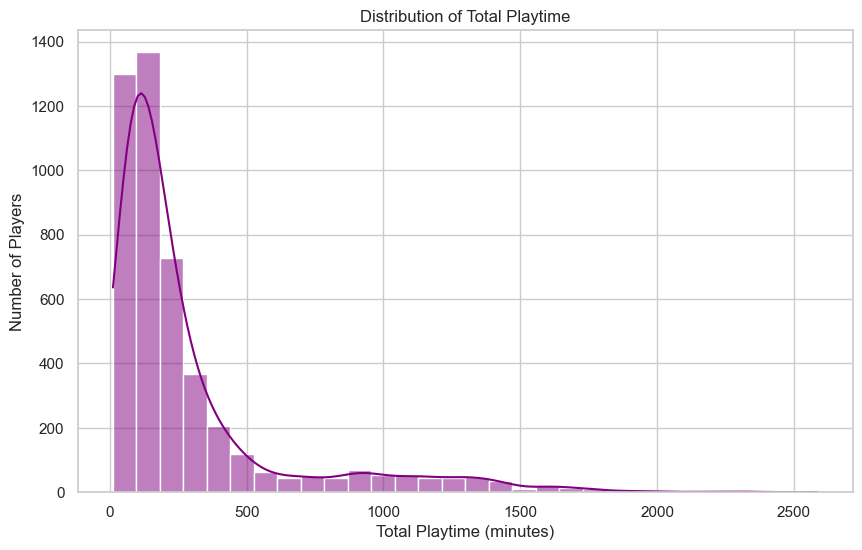

In [35]:
# 🔹 Gameplay Time Distribution task 1 
plt.figure(figsize=(10,6))
sns.histplot(summersesstrx['Duration'], bins=30, kde=True, color='purple')
plt.title('Distribution of Total Playtime')
plt.xlabel('Total Playtime (minutes)')
plt.ylabel('Number of Players')
plt.show()

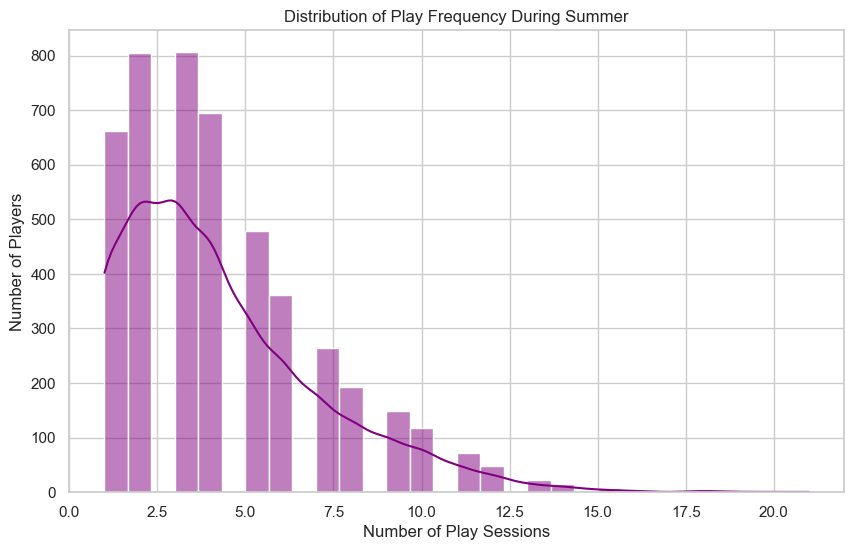

In [36]:
#  Play Frequency Distribution during summ
plt.figure(figsize=(10,6))
sns.histplot(summersesstrx['PlayID'], bins=30, kde=True, color='purple')
plt.title('Distribution of Play Frequency During Summer')
plt.xlabel('Number of Play Sessions')
plt.ylabel('Number of Players')
plt.show()

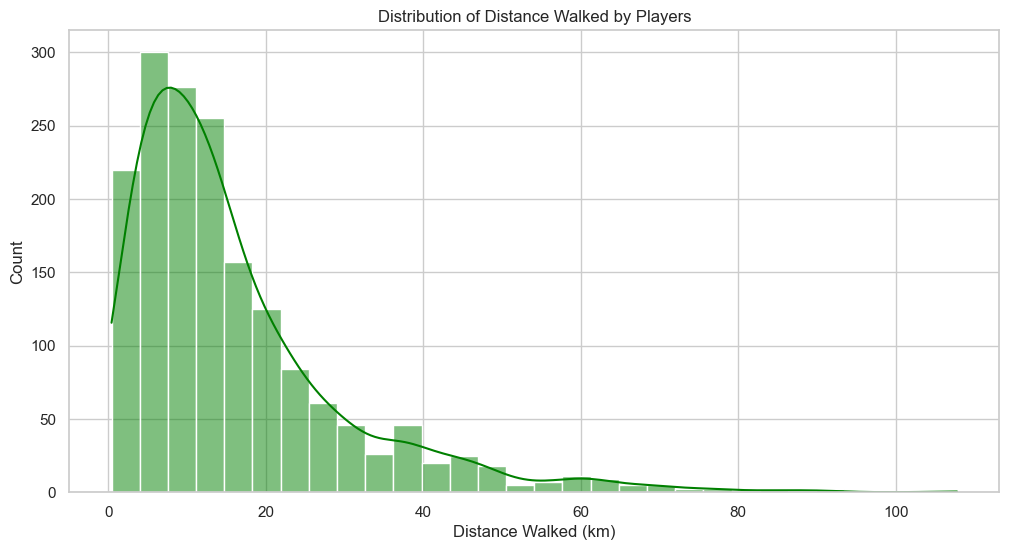

In [37]:
# Distance Walked by the players Distribution
plt.figure(figsize=(12,6))
sns.histplot(active_summer_fin_trx['Distance'], bins=30, kde=True, color='green')
plt.title('Distribution of Distance Walked by Players')
plt.xlabel('Distance Walked (km)')
plt.ylabel('Count')
plt.show()

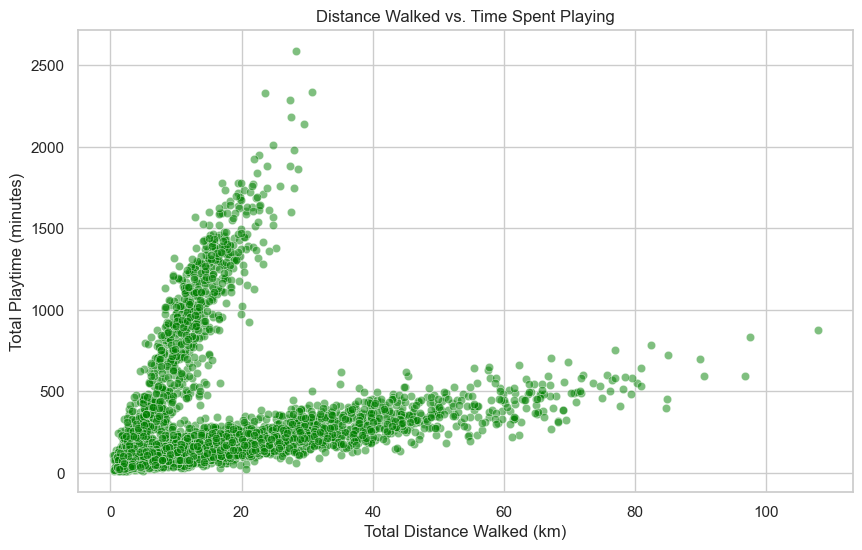

In [38]:
# Distance Walked vs. Time Spent in game
plt.figure(figsize=(10,6))
sns.scatterplot(x='Distance', y='Duration', data=summersesstrx, alpha=0.5, color='green')
plt.title('Distance Walked vs. Time Spent Playing')
plt.xlabel('Total Distance Walked (km)')
plt.ylabel('Total Playtime (minutes)')
plt.show()


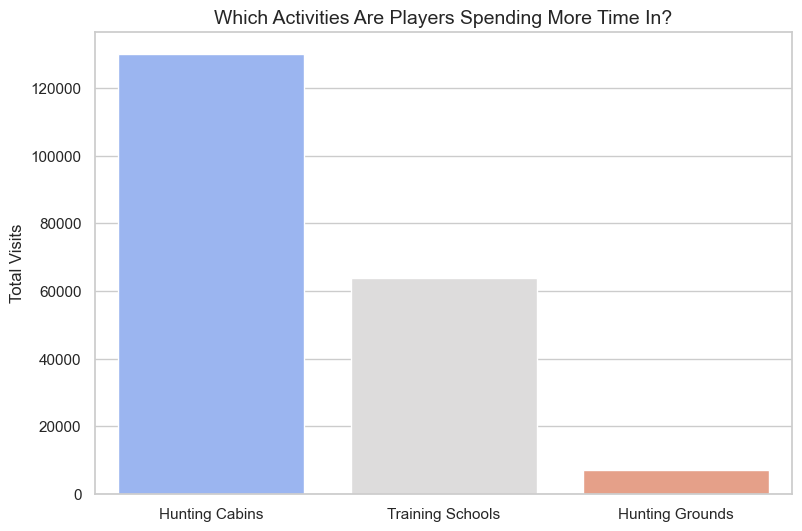

In [39]:
# Set theme for better aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12, 'legend.fontsize': 10})


#  Bar Chart: Spending Across Gameplay Activities
activity_labels = ["Hunting Cabins", "Training Schools", "Hunting Grounds"]
activity_spending = [
    active_summer_fin_trx["Huntingcabins"].sum(),
    active_summer_fin_trx["Trainingschools"].sum(),
    active_summer_fin_trx["Huntinggrounds"].sum()
]

plt.figure(figsize=(9,6))
sns.barplot(x=activity_labels, y=activity_spending, palette="coolwarm")
plt.ylabel("Total Visits")
plt.title("Which Activities Are Players Spending More Time In?")
plt.show()

### **Spending Behavior & Player Value**

In [41]:
customer_revenue = summerfintrx.groupby("CustomerID")["monetary_value"].sum().reset_index()
customer_revenue = customer_revenue.sort_values(by="monetary_value", ascending=False)
# Calculate cumulative revenue share
customer_revenue["CumulativeRevenue"] = customer_revenue["monetary_value"].cumsum()
customer_revenue["CumulativeRevenuePerc"] = customer_revenue["CumulativeRevenue"] / customer_revenue["monetary_value"].sum()
# Calculate cumulative customer share
customer_revenue["CumulativeCustomerPerc"] = np.arange(1, len(customer_revenue)+1) / len(customer_revenue)
# Find the % of customers contributing to 80% of revenue
top_customers_80 = customer_revenue[customer_revenue["CumulativeRevenuePerc"] <= 0.80]
percentage_top_customers = len(top_customers_80) / len(customer_revenue) * 100

print(f"Percentage of customers contributing to 80% of total revenue: {percentage_top_customers:.2f}%")

Percentage of customers contributing to 80% of total revenue: 45.00%


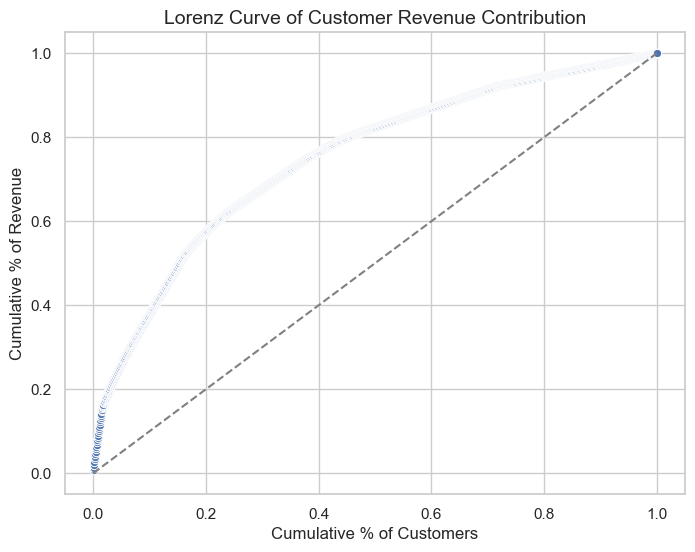

In [42]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=customer_revenue["CumulativeCustomerPerc"], y=customer_revenue["CumulativeRevenuePerc"], marker="o")
plt.plot([0,1], [0,1], linestyle="--", color="gray")  # Line of equality
plt.xlabel("Cumulative % of Customers")
plt.ylabel("Cumulative % of Revenue")
plt.title("Lorenz Curve of Customer Revenue Contribution")
plt.show()

While not as extreme as the traditional 80/20 rule, your revenue distribution still highlights a significant dependence on a subset of customers. Protecting and growing this segment should be a priority for long-term business sustainability. 

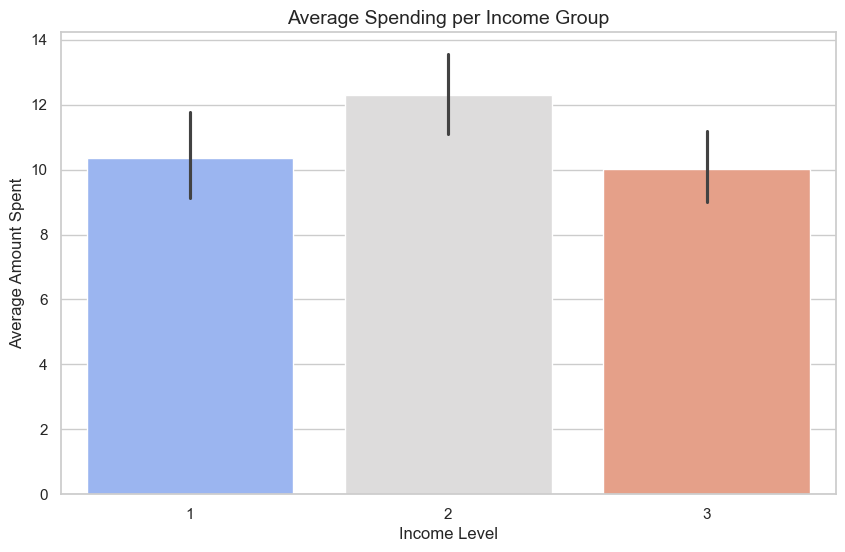

In [44]:
# Average Spending per Income Group 
plt.figure(figsize=(10,6))
sns.barplot(x='Income', y='monetary_value', data=active_summer_fin_trx, estimator=np.mean, palette='coolwarm')
plt.title('Average Spending per Income Group')
plt.xlabel('Income Level')
plt.ylabel('Average Amount Spent')
plt.show()

### *PURCHASE DATE Cohorts*

In [46]:
active_summer_fin_trx = active_summer_fin_trx.merge(
    customersegm[['CustomerID', 'segmfreq', 'segmrec']], 
    on='CustomerID', 
    how='left'
)

# Assign first purchase month as the cohort
active_summer_fin_trx['CohortMonth'] = active_summer_fin_trx['first_purchase'].dt.month


# Convert CohortMonth to categorical and order it for consistency
active_summer_fin_trx['CohortMonth'] = pd.Categorical(
    active_summer_fin_trx['CohortMonth'], 
    categories=[5, 6, 7, 8],  # Assuming purchases are in May, June, July, and August
    ordered=True
)

# Group players by first purchase month and analyze average spending behavior
lcgcoh = active_summer_fin_trx.groupby(['CohortMonth', 'segmfreq', 'segmrec'], observed=True, as_index=False).agg(
    avg_spent=('monetary_value', 'mean')
)

lcgcoh['CustomerID'] = 'Customer'  # Dummy x-axis label for consistency

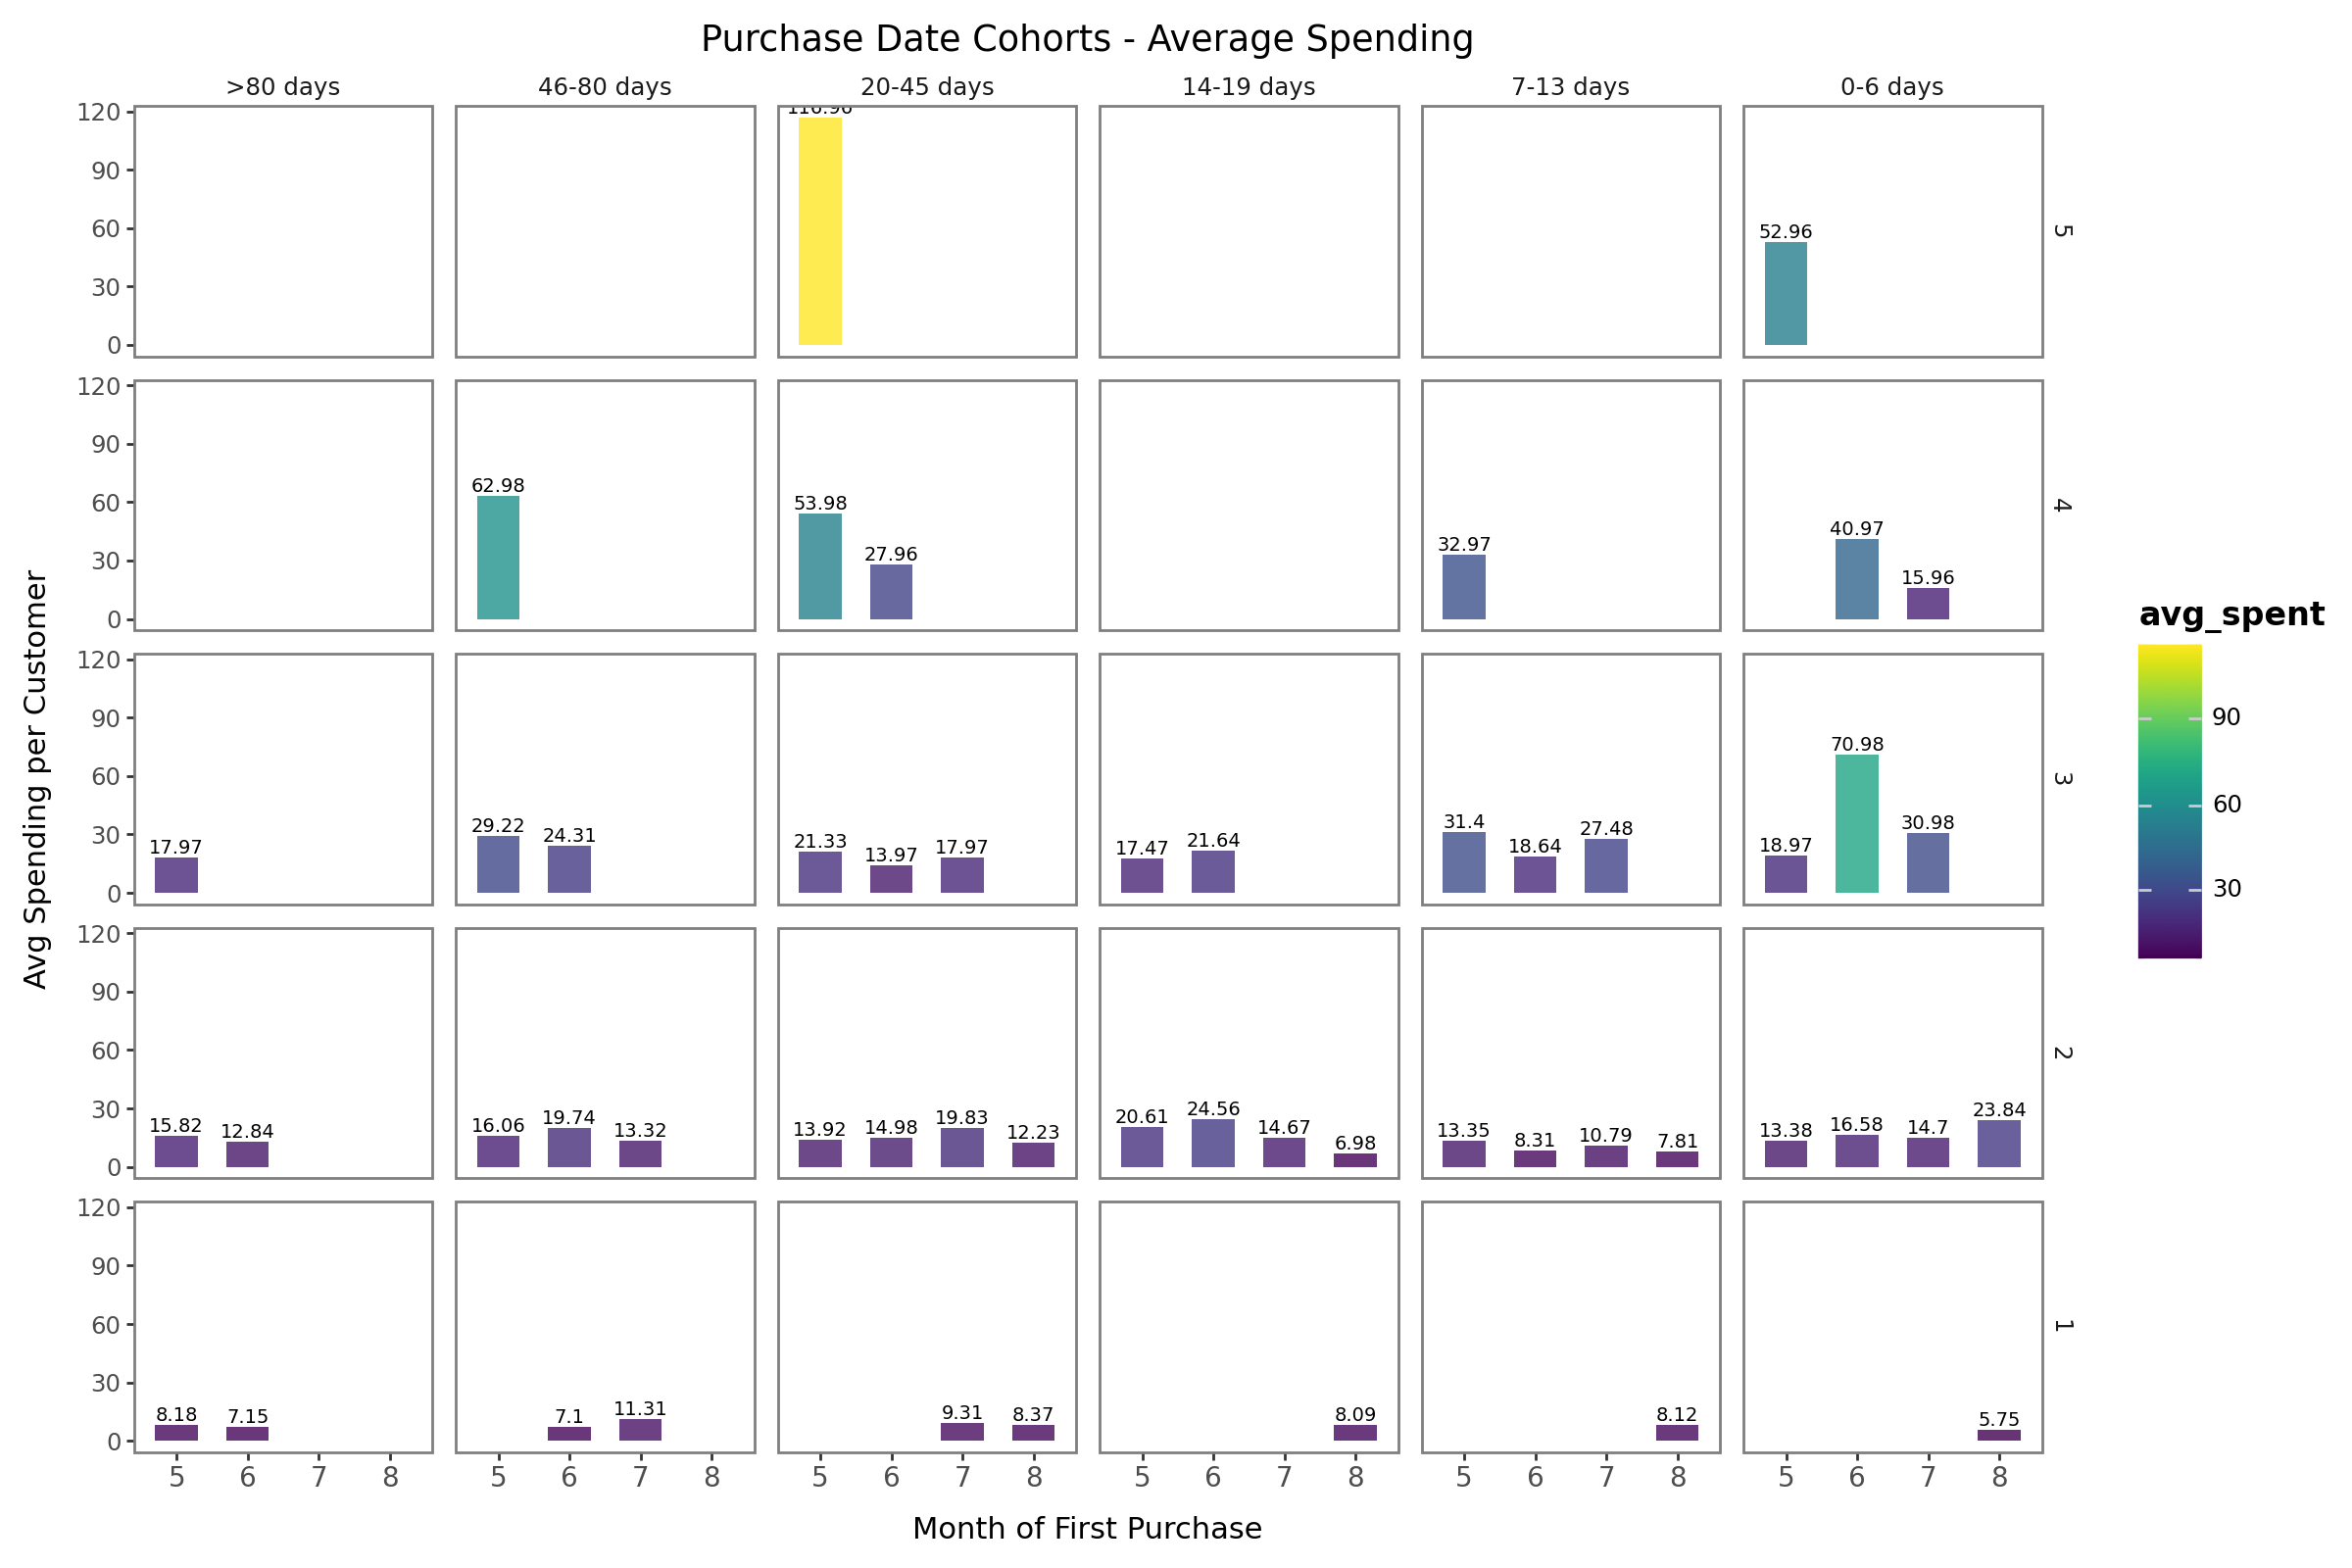

In [47]:

#Purchase Date Cohorts - Average Spending ###
plot5 = (
    ggplot(lcgcoh, aes(x='CohortMonth', y='avg_spent', fill='avg_spent')) +
    theme_bw() +
    theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        legend_title=element_text(size=12, weight="bold"),
        legend_position="right",
        strip_background=element_blank(),
        axis_text_x=element_text(size=10),
        figure_size=(12, 8)
    ) +
    geom_bar(stat='identity', position='dodge', alpha=0.8, width=0.6) +
    geom_text(aes(label='round(avg_spent, 2)'), va='bottom', size=7) +
    facet_grid('segmfreq ~ segmrec') +
    ggtitle("Purchase Date Cohorts - Average Spending") +
    xlab("Month of First Purchase") +
    ylab("Avg Spending per Customer")
)
plot5.show()

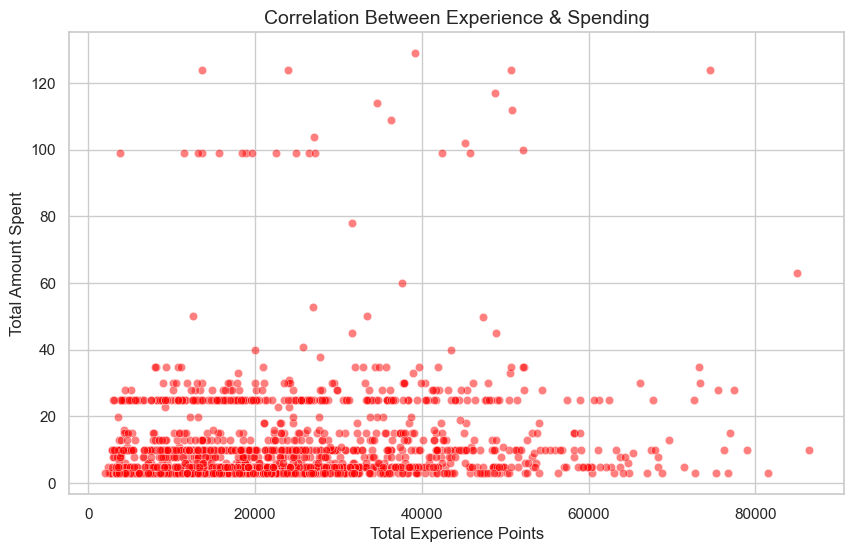

In [48]:
# Experience vs. Spending
plt.figure(figsize=(10,6))
sns.scatterplot(x='Experience', y='monetary_value', data=active_summer_fin_trx, alpha=0.5, color='red')
plt.title('Correlation Between Experience & Spending')
plt.xlabel('Total Experience Points')
plt.ylabel('Total Amount Spent')
plt.show()

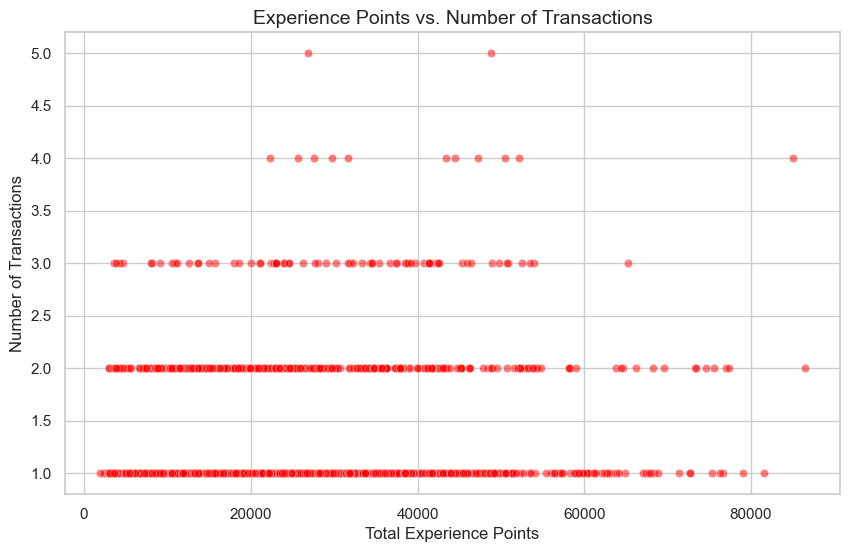

In [49]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Experience', y='frequency', data=active_summer_fin_trx, alpha=0.5, color='red')
plt.title('Experience Points vs. Number of Transactions')
plt.xlabel('Total Experience Points')
plt.ylabel('Number of Transactions')
plt.show()


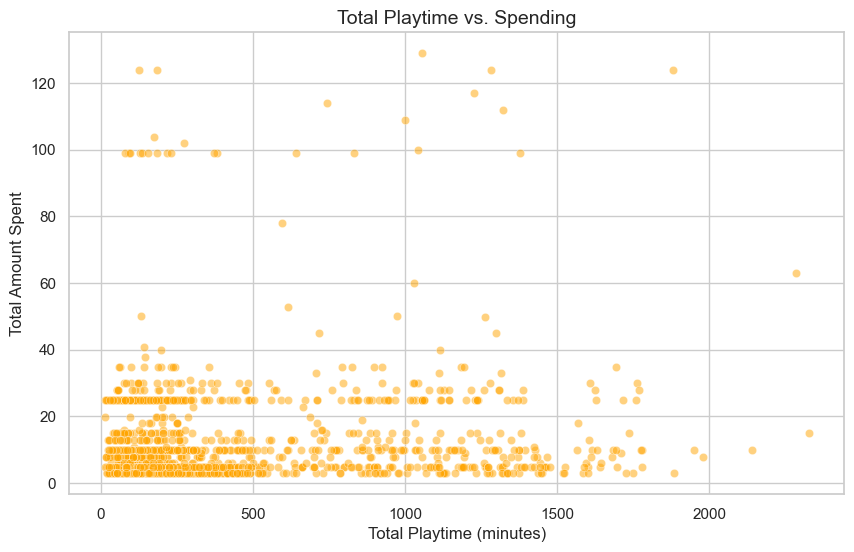

In [50]:
# Play Duration vs. Spending task 
plt.figure(figsize=(10,6))
sns.scatterplot(x='Duration', y='monetary_value', data=active_summer_fin_trx, alpha=0.5, color='orange')
plt.title('Total Playtime vs. Spending')
plt.xlabel('Total Playtime (minutes)')
plt.ylabel('Total Amount Spent')
plt.show()

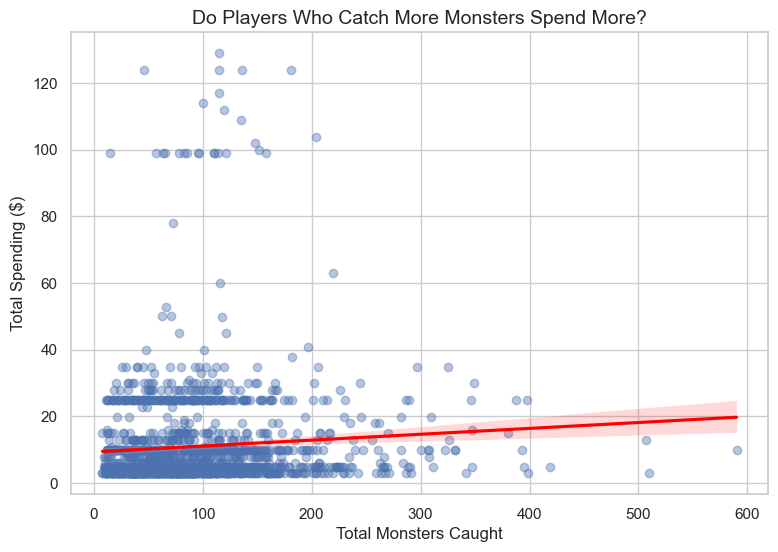

In [51]:
# Scatter Plot: Monsters Caught vs. Spending
plt.figure(figsize=(9,6))
sns.regplot(x=active_summer_fin_trx["Monsters"], 
            y=active_summer_fin_trx["monetary_value"], 
            scatter_kws={"alpha": 0.4}, line_kws={"color": "red"})
plt.xlabel("Total Monsters Caught")
plt.ylabel("Total Spending ($)")
plt.title("Do Players Who Catch More Monsters Spend More?")
plt.show()

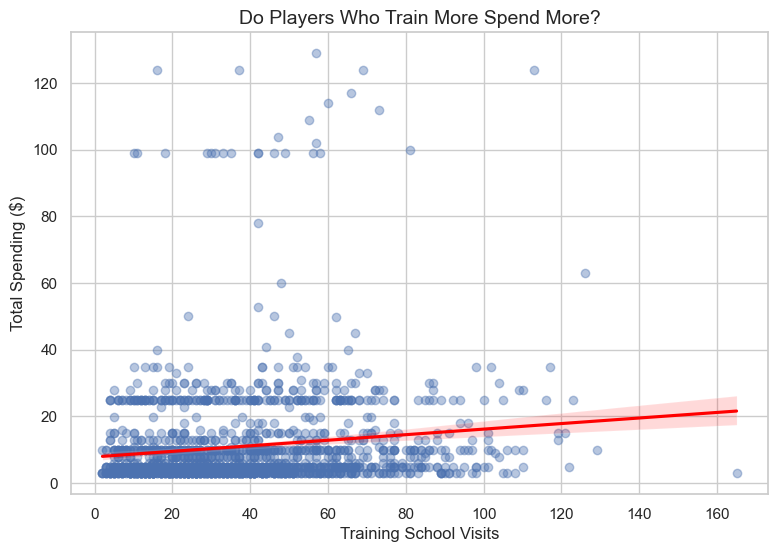

In [52]:
# Scatter Plot: Training School Visits vs. Spending
plt.figure(figsize=(9,6))
sns.regplot(x=active_summer_fin_trx["Trainingschools"], 
            y=active_summer_fin_trx["monetary_value"], 
            scatter_kws={"alpha": 0.4}, line_kws={"color": "red"})
plt.xlabel("Training School Visits")
plt.ylabel("Total Spending ($)")
plt.title("Do Players Who Train More Spend More?")
plt.show()

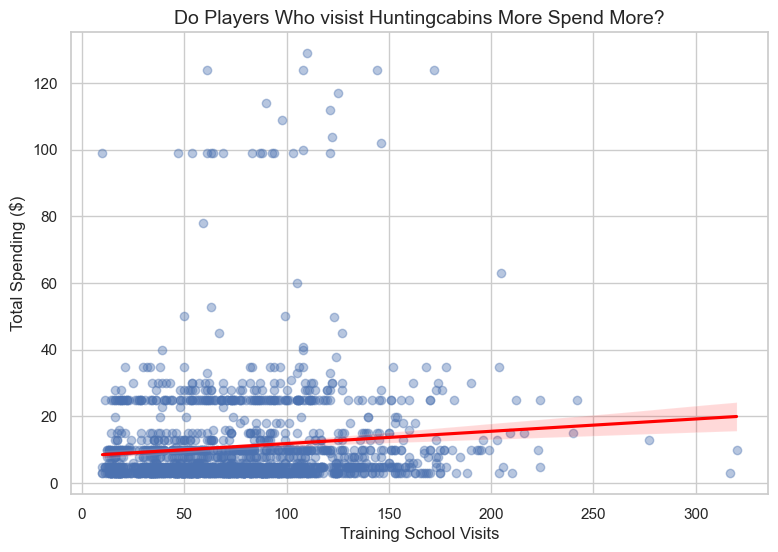

In [53]:
# Scatter Plot: Huntingcabins vs. Spending
plt.figure(figsize=(9,6))
sns.regplot(x=active_summer_fin_trx["Huntingcabins"], 
            y=active_summer_fin_trx["monetary_value"], 
            scatter_kws={"alpha": 0.4}, line_kws={"color": "red"})
plt.xlabel("Training School Visits")
plt.ylabel("Total Spending ($)")
plt.title("Do Players Who visist Huntingcabins More Spend More?")
plt.show()

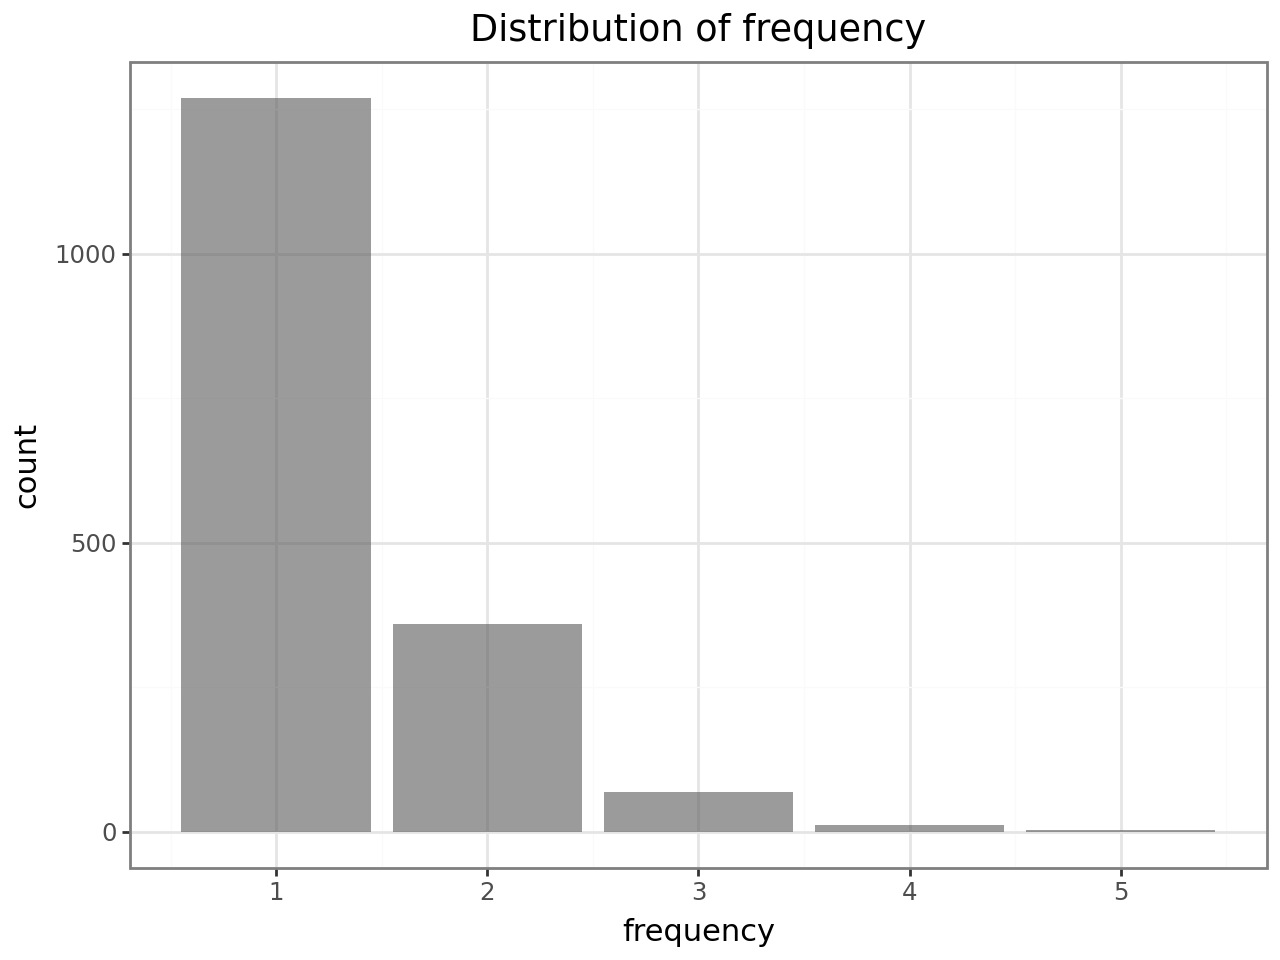

In [54]:
#distribution of frequency of number of transactions task 1
histfreq=(ggplot(active_summer_fin_trx, aes(x='frequency')) +
  theme_bw() +
  scale_x_continuous() +
  geom_bar(alpha=0.6) +  
  ggtitle("Distribution of frequency"))
histfreq.show()

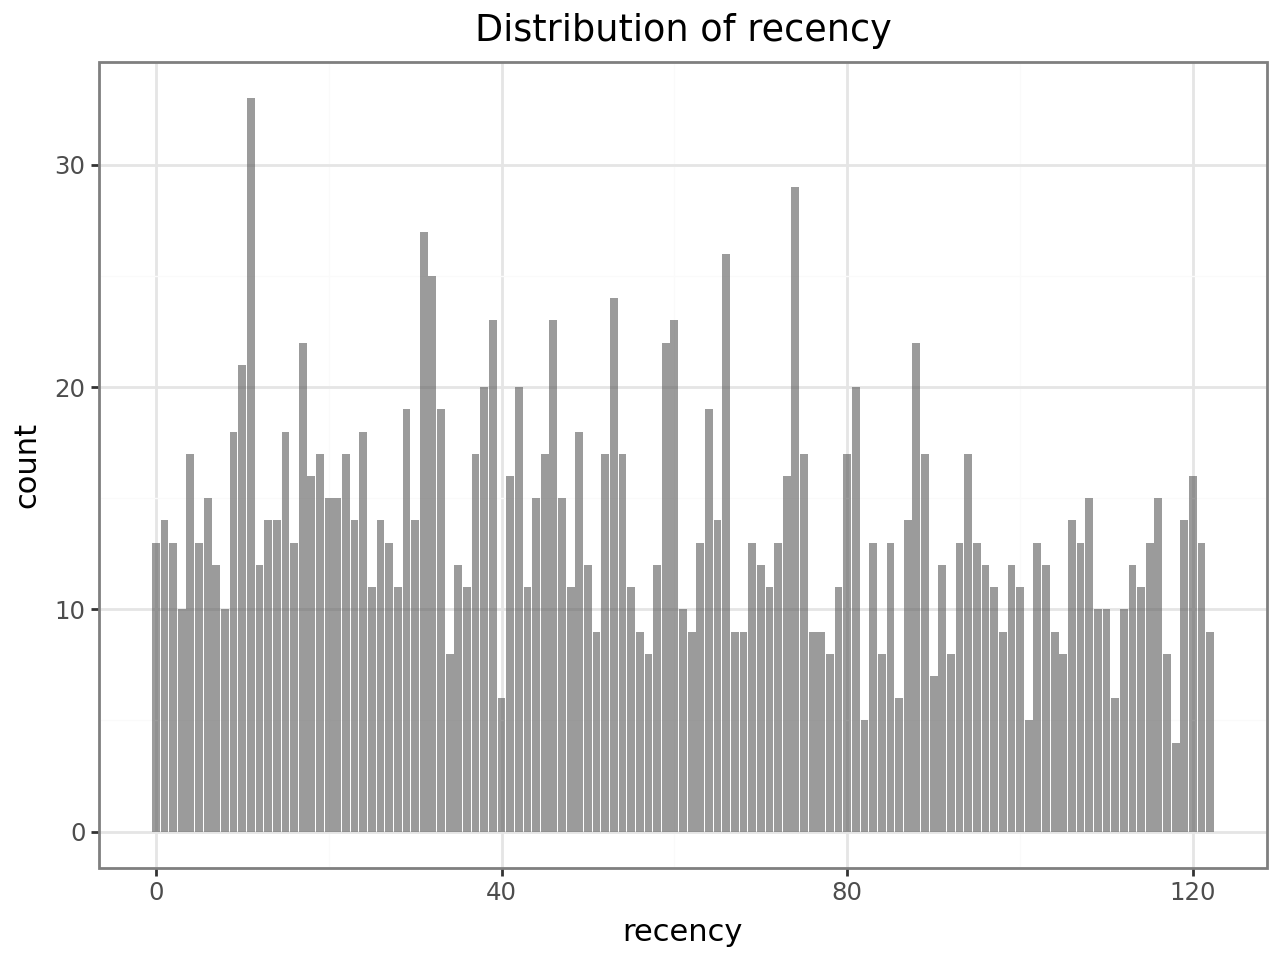

In [55]:
#distribution of recency of transactions task 1
histfreq=(ggplot(active_summer_fin_trx, aes(x='recency')) +
  theme_bw() +
  scale_x_continuous() +
  geom_bar(alpha=0.6) +  
  ggtitle("Distribution of recency"))
histfreq.show()

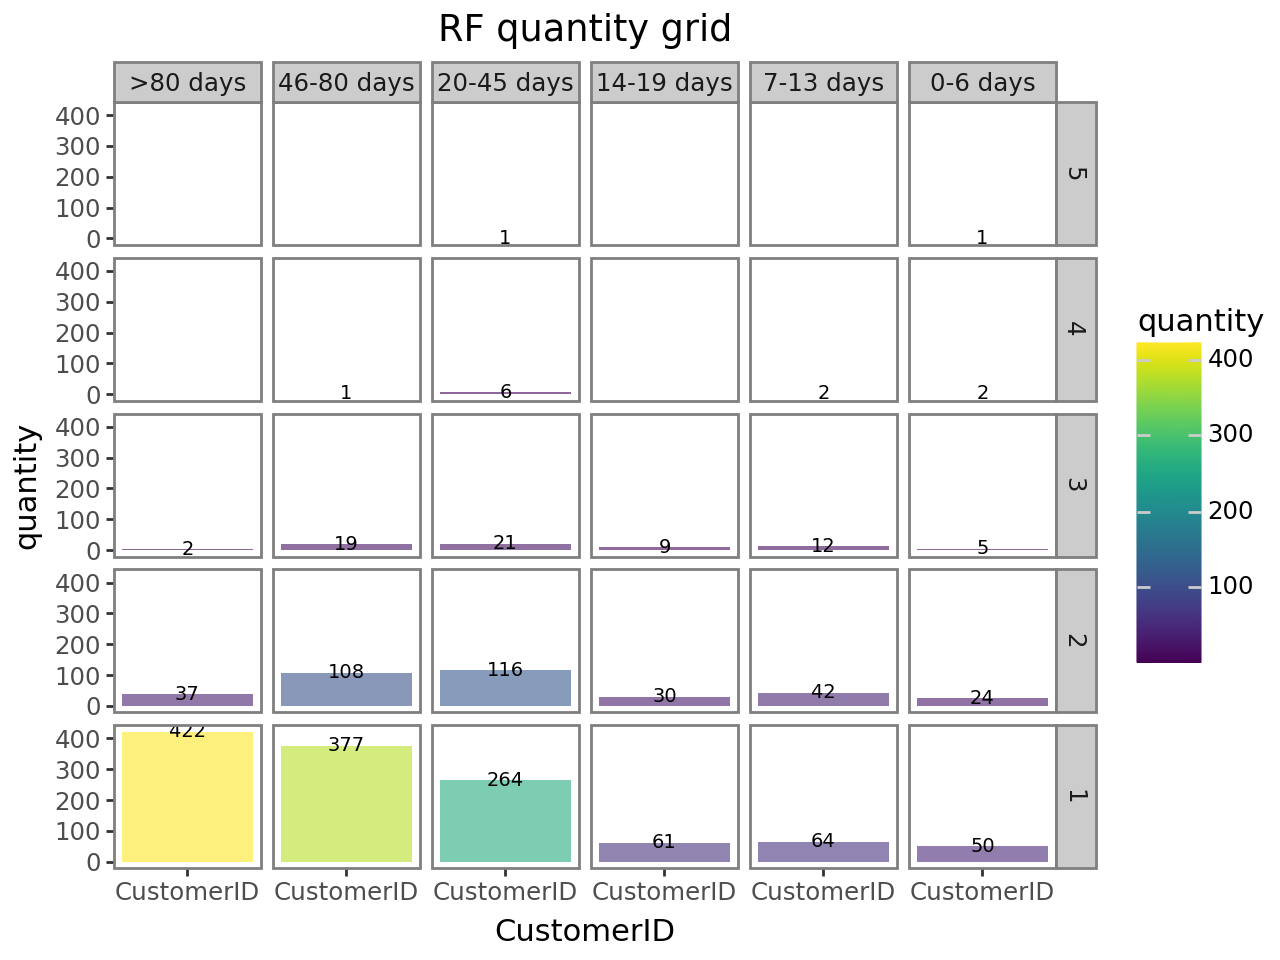

In [56]:
lcg=customersegm.groupby(['segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lcg['CustomerID']='CustomerID'

rfgrid=(ggplot(lcg, aes(x='CustomerID', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  #xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  #removes colored boxed behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  #stat="identity because y is a variable in the dataset scale makes the fill transparent
  geom_text(aes(y='quantity', label='quantity'), size=7) +#display the quantity label at the height of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
  #organises the bar chart around the r & f variables
  ggtitle("RF quantity grid"))
rfgrid.show()

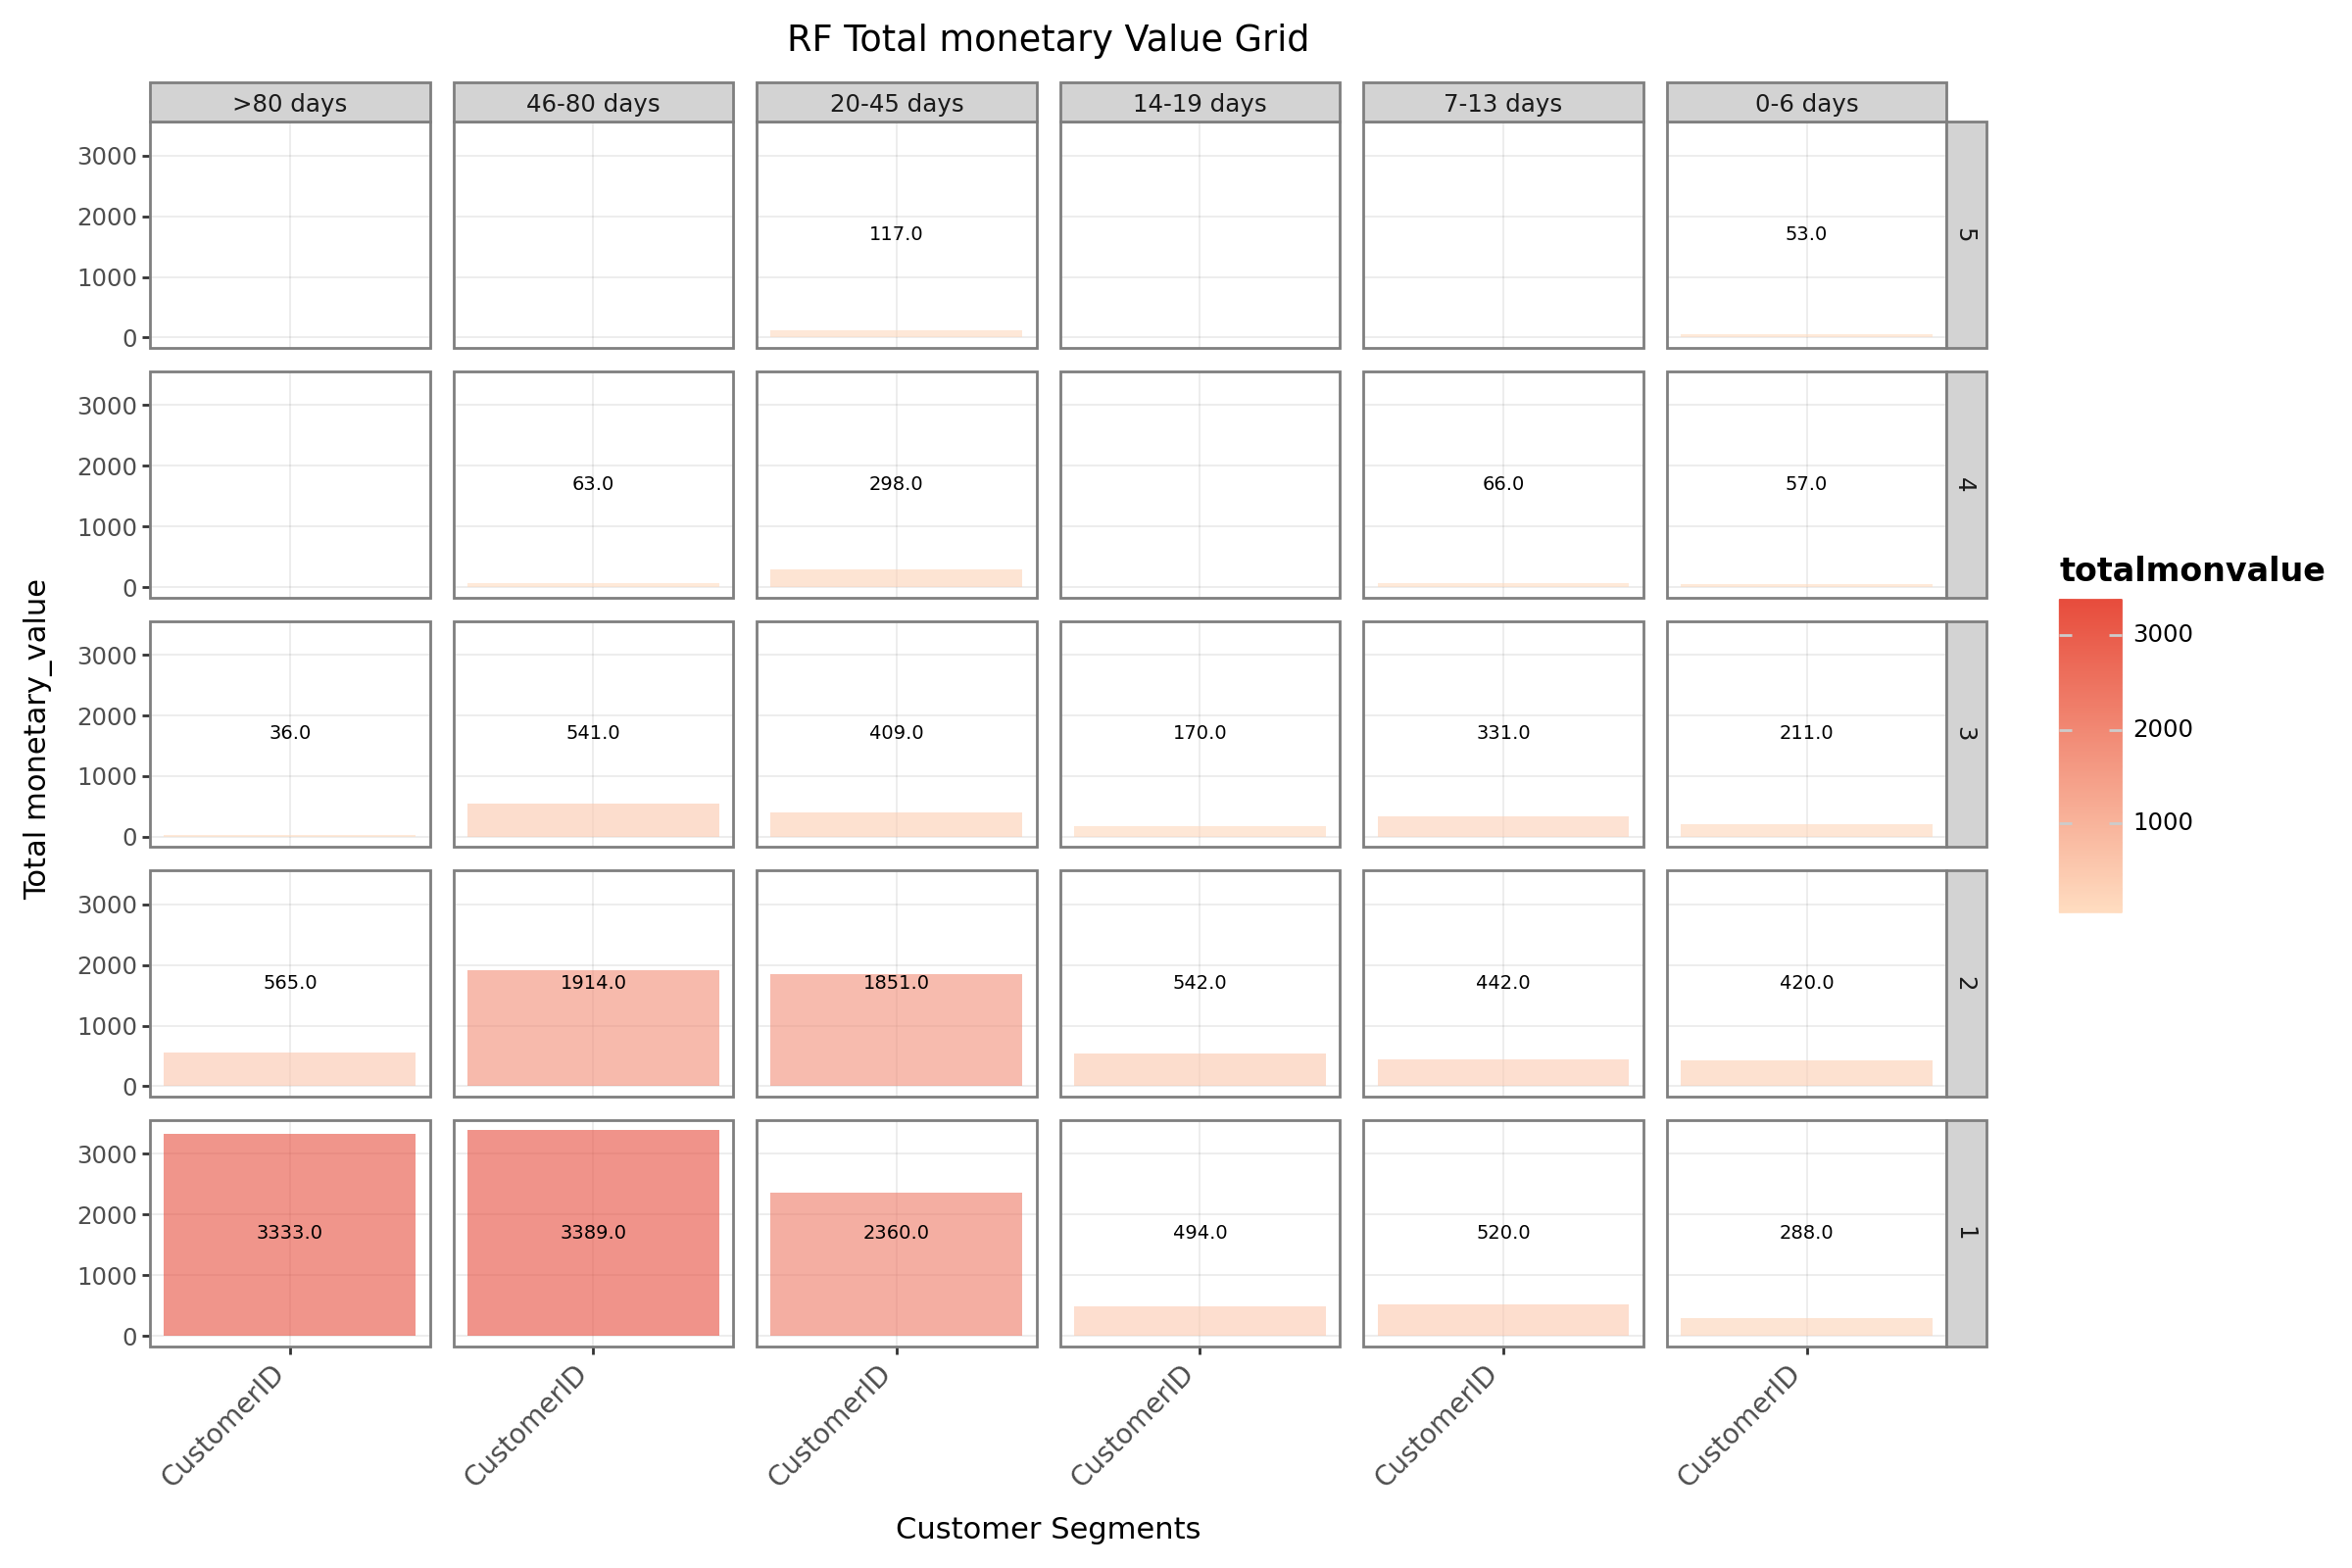

In [57]:
lcgtmon = customersegm.groupby(['segmfreq', 'segmrec'], observed=True, as_index=False).agg(
    totalmonvalue=('monetary_value', 'sum')  # Sum monetary_value values per RF segment
)
lcgtmon['CustomerID'] = 'CustomerID'  # Dummy x-axis label

plot4 = (ggplot(lcgtmon, aes(x='CustomerID', y='totalmonvalue', fill='totalmonvalue')) +
    theme_bw() +  
    theme(panel_grid_major=element_line(size=0.1, color="gray"),  
        panel_grid_minor=element_blank(),
        legend_title=element_text(size=12, weight="bold"),  
        legend_position="right",  
        strip_background=element_rect(fill="lightgray"),  
        axis_text_x=element_text(angle=45, ha='right', size=10),  # Rotate x-axis labels
        figure_size=(12, 8)) +  
    geom_bar(stat='identity', alpha=0.6) +  
    geom_text(aes(y='np.nanmax(totalmonvalue)/2', label='np.ceil(totalmonvalue)'), size=7) +  
    facet_grid('segmfreq ~ segmrec') +  
    ggtitle("RF Total monetary Value Grid") +
    xlab("Customer Segments") +
    ylab("Total monetary_value ") +
    scale_fill_gradient(low="#FFDDC1", high="#E74C3C")  # Color gradient from light to dark
)
plot4.show()

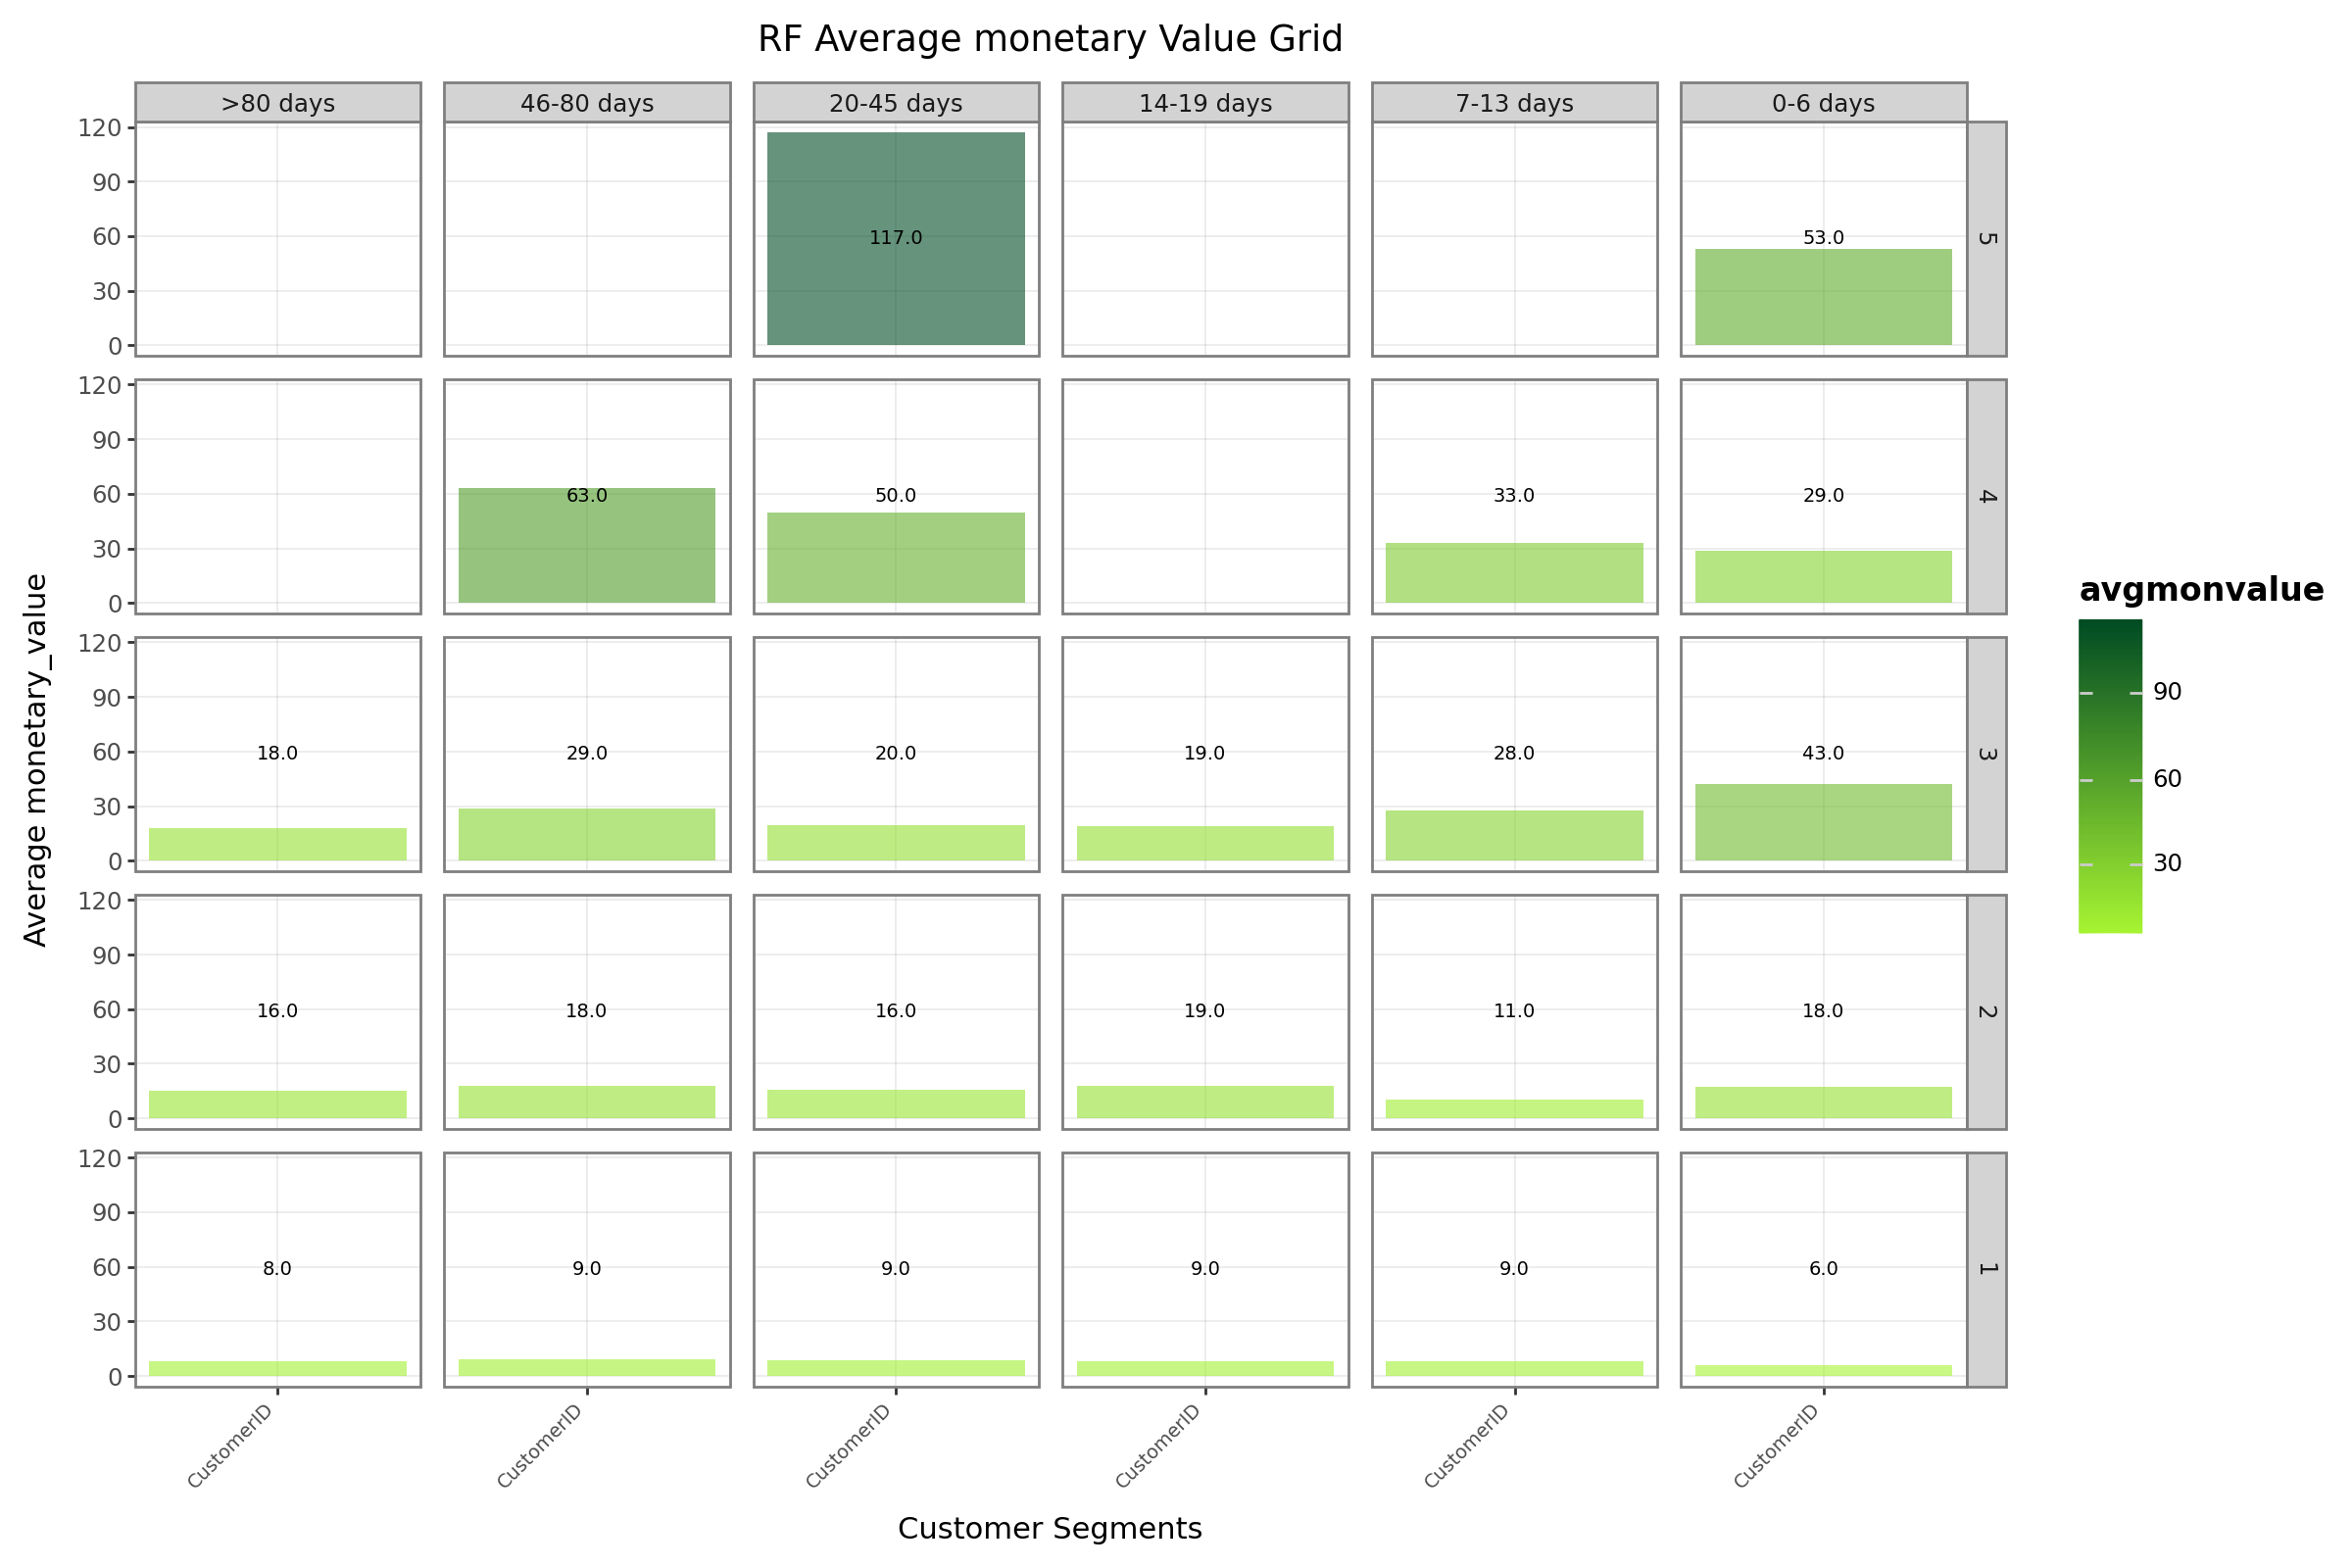

In [58]:
lcgmon = customersegm.groupby(['segmfreq', 'segmrec'], observed=True, as_index=False).agg(
    avgmonvalue=('monetary_value', 'mean')  # Sum monetary_value values per RF segment
)
lcgmon['CustomerID'] = 'CustomerID'  # Dummy x-axis label


plot5 = (ggplot(lcgmon, aes(x='CustomerID', y='avgmonvalue', fill='avgmonvalue')) +
    theme_bw() +  
    theme(panel_grid_major=element_line(size=0.1, color="gray"),  
        panel_grid_minor=element_blank(),
        legend_title=element_text(size=12, weight="bold"),  
        legend_position="right",  
        strip_background=element_rect(fill="lightgray"),  
        axis_text_x=element_text(angle=45, ha='right', size=7),  # Rotate x-axis labels
        figure_size=(12, 8)) +  
    geom_bar(stat='identity', alpha=0.6) +  
    geom_text(aes(y='np.nanmax(avgmonvalue)/2', label='np.ceil(avgmonvalue)'), size=7) +  
    facet_grid('segmfreq ~ segmrec') +  
    ggtitle("RF Average monetary Value Grid") +
    xlab("Customer Segments") +
    ylab("Average monetary_value ") +
    scale_fill_gradient(low="#A7F432", high="#004B23")  # Color gradient from light to dark
)
plot5.show()

### PLAYER BEHAVIOUR with frequency and recency

In [60]:
rfm_player_behavior = Summersesstrx.groupby('CustomerID', as_index=False).agg(
    frequency=('PlayID','count'),
    recency=('Date', lambda date: (today - date.max()).days),  # Days since last playing session
    date_min=('Date', 'min'),                    # First session date in the summer period
    Experience=('Experience', 'sum'),               # Total experience points
    Huntingcabins=('Huntingcabins', 'sum'),            # Total hunting cabins visited
    Trainingschools=('Trainingschools', 'sum'),          # Total training schools visited
    Huntinggrounds=('Huntinggrounds', 'sum'),           # Total hunting grounds visited
    Social=('Social', 'sum'),                   # Total social actions performed
    Monsters=('Monsters', 'sum'),                 # Total monsters caught
    Distance=('Distance', 'sum'),                  # Total distance walked
    Duration=('Duration', 'sum') 
)

In [61]:
playersegm=rfm_player_behavior.assign(
    segmfreq=lambda x: pd.cut(rfm_player_behavior['frequency'], 
                                              bins=[0,1,2,3,4,5,99],
                                              labels=["1", "2", "3",'4','5','>5']),
    segmrec=lambda x: pd.cut(rfm_player_behavior['recency'], 
                                              bins=[0,6,13,19,45,80,120],
                                              labels=["0-6 days", "7-13 days", "14-19 days",'20-45 days','46-80 days','>80 days']))

#convert to factor and reverse the order
playersegm['segmfreq']=pd.Categorical(playersegm['segmfreq'], categories=[">5","5", "4", "3","2","1"])
playersegm['segmrec']=pd.Categorical(playersegm['segmrec'], categories=[">80 days","46-80 days", "20-45 days", "14-19 days","7-13 days","0-6 days"])

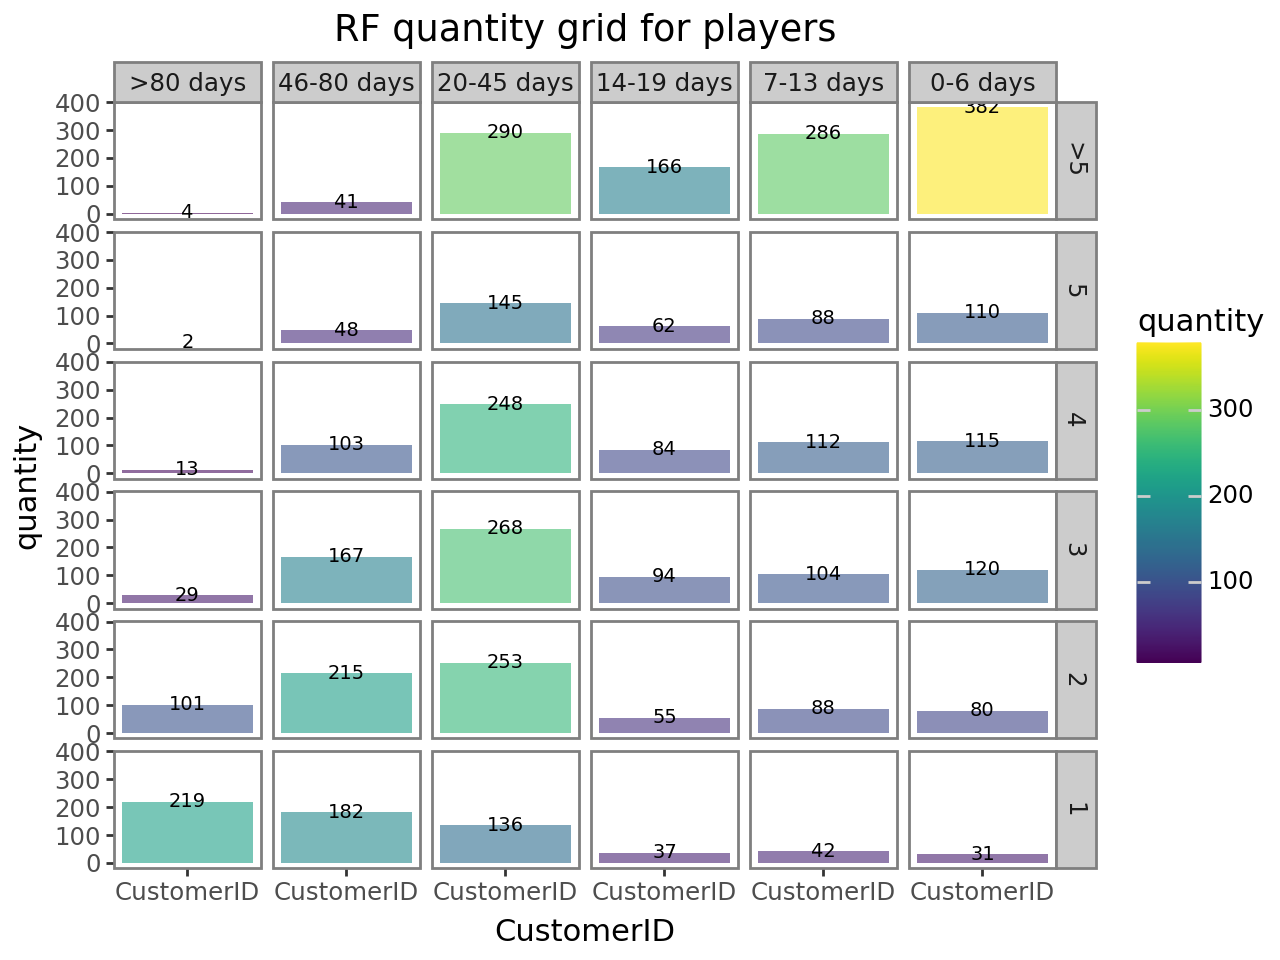

In [62]:
lpg=playersegm.groupby(['segmfreq','segmrec'],observed=True, as_index=False).agg(quantity=('CustomerID','count'))
lpg['CustomerID']='CustomerID'

plot7=(ggplot(lpg, aes(x='CustomerID', y='quantity',fill='quantity'))+#xvalue is the client factor that is the same for all y values
  #xvalue is the client factor that is the same for all y values
  theme_bw() +#layout theme
  theme(panel_grid = element_blank())+#removes colored box behind bar chart
  #removes colored boxed behind bar chart
  geom_bar(stat='identity', alpha=0.6) +#stat="identity bar chart based on y value, alpha controls transparency
  #stat="identity because y is a variable in the dataset scale makes the fill transparent
  geom_text(aes(y='quantity', label='quantity'), size=7) +#display the quantity label at the height of the bar
  facet_grid('segmfreq ~ segmrec')+#organises the bar chart around the r & f variables
  #organises the bar chart around the r & f variables
  ggtitle("RF quantity grid for players"))
plot7.show()

# Task 2: Analyze and visualize the differences among the four player types based on summer data

**Player Behavior Analysis:**

**How the different player types engage with the game ( play patterns, experience points, session duration, social interactions, etc...)**

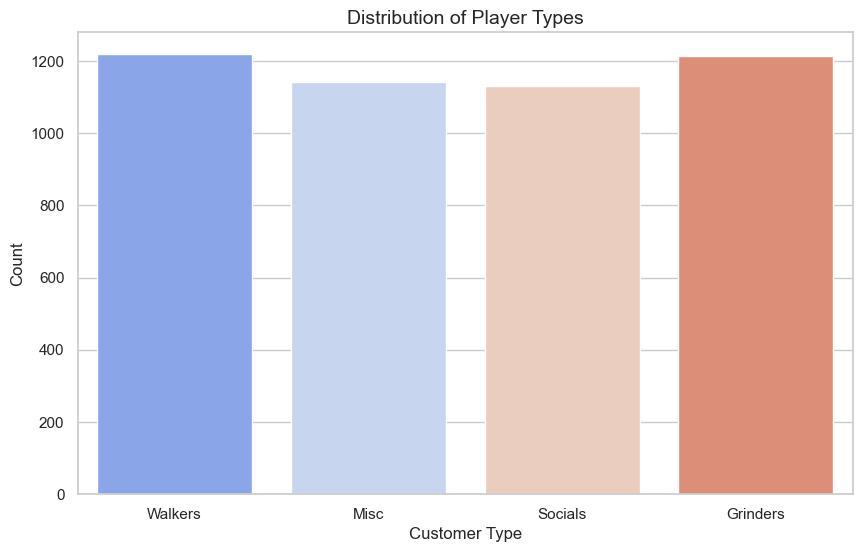

In [65]:
#Customer Type Distribution
plt.figure(figsize=(10,6))
sns.countplot(x='CustomerType', data=active_summer_customer_data, palette='coolwarm')
plt.title('Distribution of Player Types')
plt.xlabel('Customer Type')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], ['Walkers', 'Misc', 'Socials', 'Grinders'])
plt.show()

In [66]:
# Function to categorize customers into age groups
def categorize_age(age):
    if age <= 15:
        return '1. <15'
    elif 15 < age <= 25:
        return '2. 15-25'
    elif 25 < age <= 35:
        return '3. 25-35'
    elif 35 < age <= 45:
        return '4. 35-45'
    elif 45 < age <= 55:
        return '5. 45-55'
    else:
        return '6. 55+'

# Apply function to create age groups
active_summer_fin_trx['AgeGroup'] = active_summer_fin_trx['Age'].apply(categorize_age)

# Count the number of unique customers per (AgeGroup, CustomerType)
age_distribution = active_summer_fin_trx.groupby(['AgeGroup', 'CustomerType'], as_index=False).agg(
    Amount=('CustomerID', lambda x: len(pd.unique(x)))  # Unique customers per AgeGroup & CustomerType
)

# Compute the total number of customers in each AgeGroup across all CustomerTypes
total_per_agegroup = active_summer_fin_trx.groupby('AgeGroup', as_index=False).agg(
    TotalAgeGroup=('CustomerID', lambda x: len(pd.unique(x)))  # Total customers in each AgeGroup
)

# Merge total age group counts to normalize
age_distribution = age_distribution.merge(total_per_agegroup, on='AgeGroup', how='left')

# Calculate the percentage of each CustomerType within each AgeGroup
age_distribution['Percentage'] = (age_distribution['Amount'] / age_distribution['TotalAgeGroup']) * 100

# Compute the expected percentage of each CustomerType across all AgeGroups
expected_customer_type_distribution = active_summer_fin_trx.groupby('CustomerType', as_index=False).agg(
    ExpectedAmount=('CustomerID', lambda x: len(pd.unique(x)))
)
total_customers = active_summer_fin_trx['CustomerID'].nunique()
expected_customer_type_distribution['Percentage_Avg'] = (expected_customer_type_distribution['ExpectedAmount'] / total_customers) * 100
expected_customer_type_distribution.drop(columns=['ExpectedAmount'], inplace=True)

# Merge the expected distribution into the main table
age_distribution = age_distribution.merge(expected_customer_type_distribution, on='CustomerType', how='left')

# Calculate the Index for over/under-representation
age_distribution['Index'] = 100 * (age_distribution['Percentage'] / age_distribution['Percentage_Avg'])

# Sort for better readability
age_distribution = age_distribution.sort_values(['AgeGroup', 'CustomerType'])

# Display the final table
from IPython.display import display
display(age_distribution)


AgeGroup  CustomerType  Amount  TotalAgeGroup  Percentage  Percentage_Avg  \
0     1. <15             1      79            343   23.032070       24.254822   
1     1. <15             2      63            343   18.367347       19.871420   
2     1. <15             3     114            343   33.236152       29.807130   
3     1. <15             4      87            343   25.364431       26.066628   
4   2. 15-25             1      88            380   23.157895       24.254822   
5   2. 15-25             2      63            380   16.578947       19.871420   
6   2. 15-25             3     123            380   32.368421       29.807130   
7   2. 15-25             4     106            380   27.894737       26.066628   
8   3. 25-35             1     164            662   24.773414       24.254822   
9   3. 25-35             2     146            662   22.054381       19.871420   
10  3. 25-35             3     180            662   27.190332       29.807130   
11  3. 25-35             4     172            662   25.981873       26.066628   
12  4. 35-45             1      45            175   25.714286       24.254822   
13  4. 35-45             2      33            175   18.857143       19.871420   
14  4. 35-45             3      53            175   30.285714       29.807130   
15  4. 35-45             4      44            175   25.142857       26.066628   
16  5. 45-55             1      17             87   19.540230       24.254822   
17  5. 45-55             2      22             87   25.287356       19.871420   
18  5. 45-55             3      22             87   25.287356       29.807130   
19  5. 45-55             4      26             87   29.885057       26.066628   
20    6. 55+             1      22             64   34.375000       24.254822   
21    6. 55+             2      13             64   20.312500       19.871420   
22    6. 55+             3      18             64   28.125000       29.807130   
23    6. 55+             4      11             64   17.187500       26.066628   

         Index  
0    94.958727  
1    92.430972  
2   111.504030  
3    97.306149  
4    95.477489  
5    83.431115  
6   108.592879  
7   107.013217  
8   102.138099  
9   110.985427  
10   91.220899  
11   99.674854  
12  106.017212  
13   94.895798  
14  101.605602  
15   96.456118  
16   80.562249  
17  127.254902  
18   84.836601  
19  114.648729  
20  141.724398  
21  102.219669  
22   94.356618  
23   65.936799

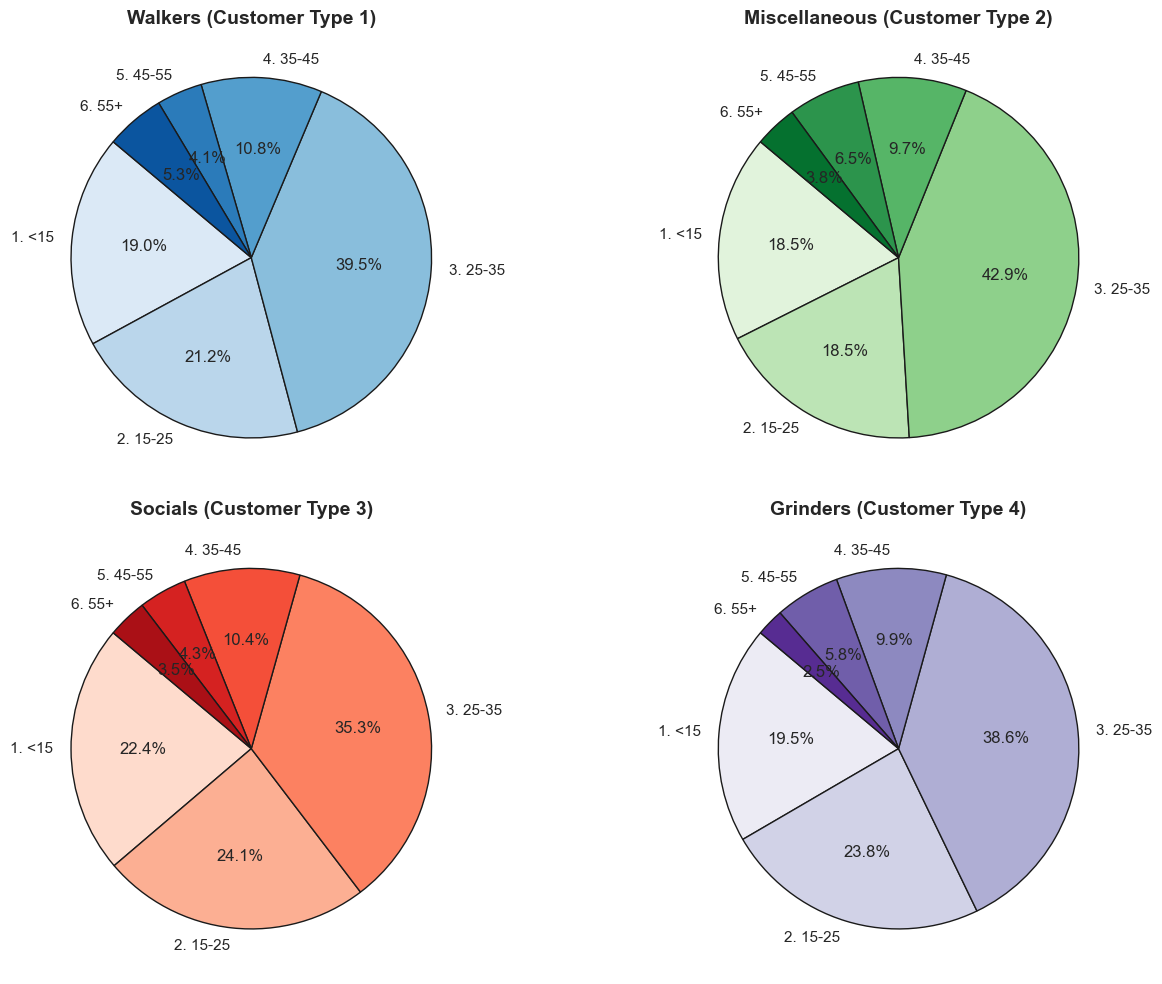

In [67]:
# Define player type names
player_types = {
    1: "Walkers",
    2: "Miscellaneous",
    3: "Socials",
    4: "Grinders"
}

# Define color palettes for each player type
color_palettes = {
    "Walkers": sns.color_palette("Blues", n_colors=6),
    "Miscellaneous": sns.color_palette("Greens", n_colors=6),
    "Socials": sns.color_palette("Reds", n_colors=6),
    "Grinders": sns.color_palette("Purples", n_colors=6),
}

# Create a figure with subplots for 4 customer types
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (customer_type, player_name) in enumerate(player_types.items()):
    # Extract data for the specific customer type
    data = age_distribution[age_distribution['CustomerType'] == customer_type]

    # Ensure correct sorting for consistency
    data = data.sort_values(by="AgeGroup")

    # Assign colors from the predefined palette
    colors = color_palettes[player_name]

    # Plot pie chart
    wedges, texts, autotexts = axes[idx].pie(
        data['Amount'],  # Use 'Amount' (number of unique customers per AgeGroup)
        labels=data['AgeGroup'],  
        autopct='%1.1f%%',  
        colors=colors,  
        startangle=140,  
        wedgeprops={"edgecolor": "k", 'linewidth': 1}  # Enhancing visibility
    )
    
    # Set bold title for each customer type
    axes[idx].set_title(f"{player_name} (Customer Type {customer_type})", fontsize=14, fontweight='bold')

# Adjust layout for readability
plt.tight_layout()
plt.show()

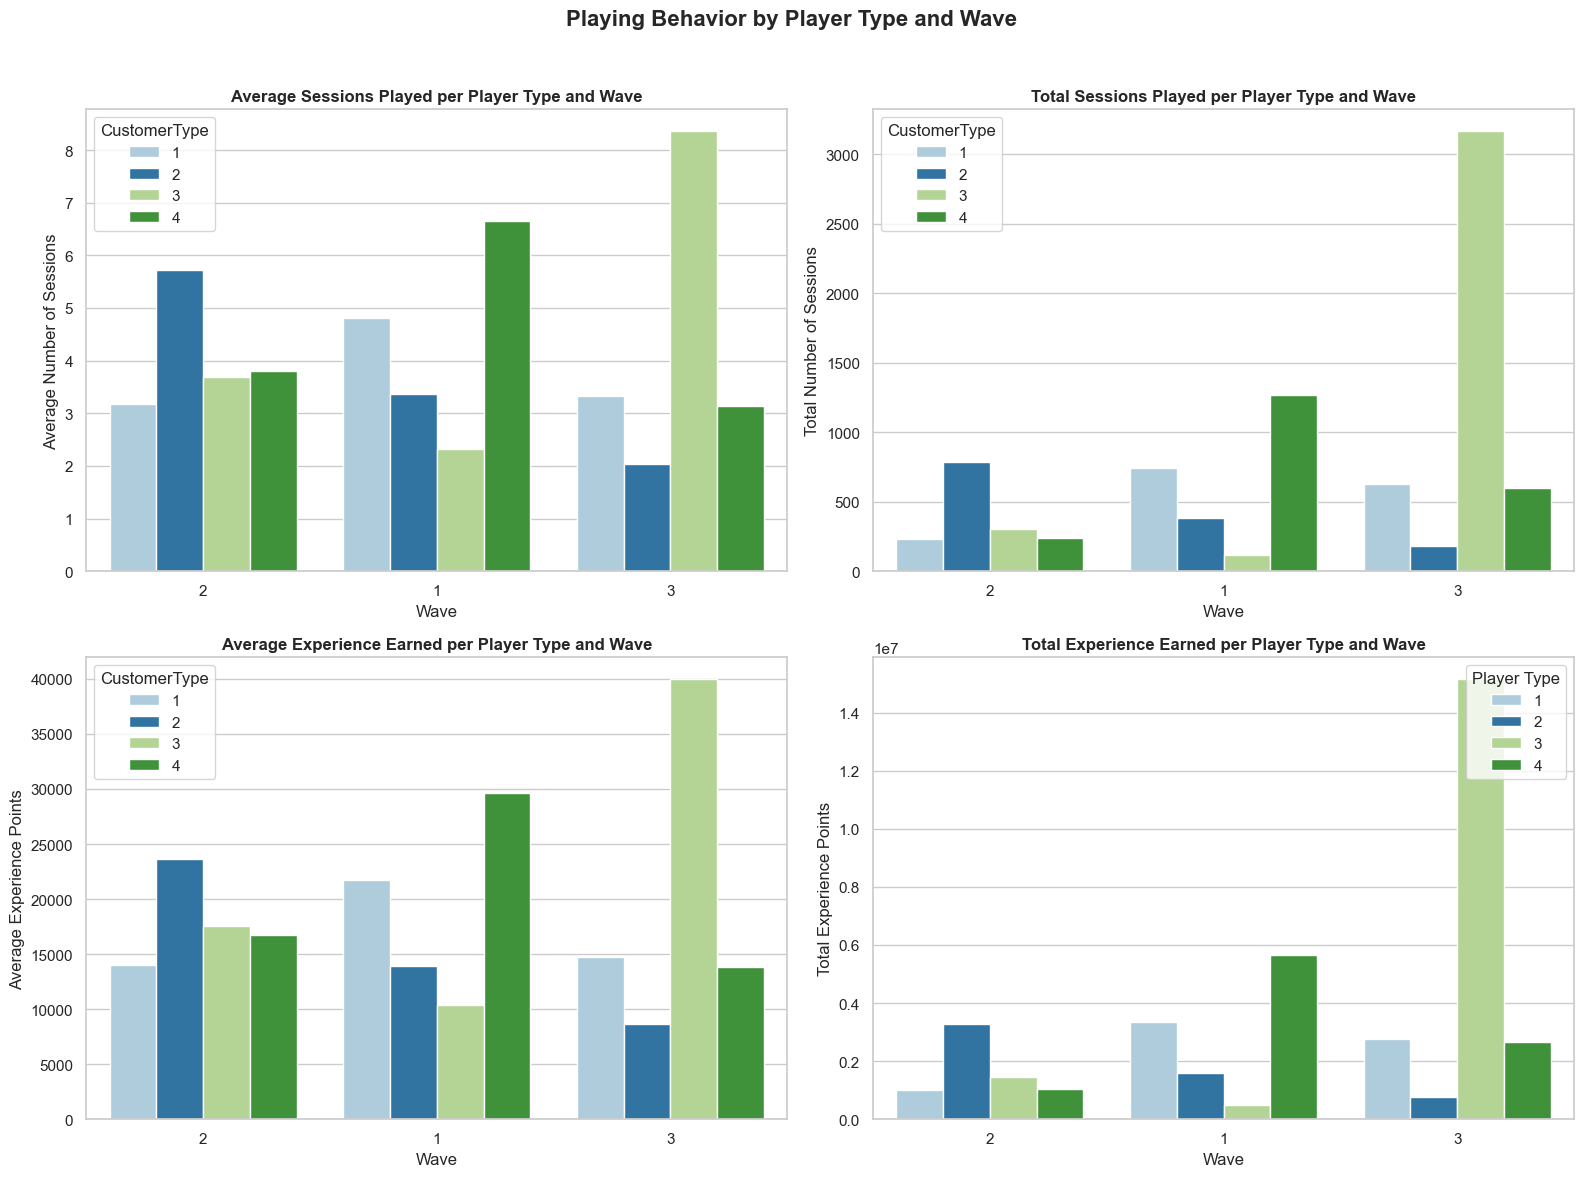

In [68]:
# Set figure style
sns.set_theme(style="whitegrid")

# Define color palette for Player Types
player_palette = {
    1: "#A6CEE3",  # Light Blue (Walkers)
    2: "#1F78B4",  # Medium Blue (Socials)
    3: "#B2DF8A",  # Light Green (Miscellaneous)
    4: "#33A02C"   # Dark Green (Grinders)
}

# Create subplots for Playing Behavior
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Playing Behavior by Player Type and Wave", fontsize=16, fontweight="bold")

# 1. Average Sessions Played per Player Type and Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='PlayID', hue='CustomerType', estimator='mean', ci=None, ax=axes[0, 0], palette=player_palette)
axes[0, 0].set_title("Average Sessions Played per Player Type and Wave", fontweight="bold")
axes[0, 0].set_xlabel("Wave")
axes[0, 0].set_ylabel("Average Number of Sessions")

# 2. Total Sessions Played per Player Type and Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='PlayID', hue='CustomerType', estimator='sum', ci=None, ax=axes[0, 1], palette=player_palette)
axes[0, 1].set_title("Total Sessions Played per Player Type and Wave", fontweight="bold")
axes[0, 1].set_xlabel("Wave")
axes[0, 1].set_ylabel("Total Number of Sessions")

# 3. Average Experience Earned per Player Type and Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='Experience', hue='CustomerType', estimator='mean', ci=None, ax=axes[1, 0], palette=player_palette)
axes[1, 0].set_title("Average Experience Earned per Player Type and Wave", fontweight="bold")
axes[1, 0].set_xlabel("Wave")
axes[1, 0].set_ylabel("Average Experience Points")

# 4. Total Experience Earned per Player Type and Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='Experience', hue='CustomerType', estimator='sum', ci=None, ax=axes[1, 1], palette=player_palette)
axes[1, 1].set_title("Total Experience Earned per Player Type and Wave", fontweight="bold")
axes[1, 1].set_xlabel("Wave")
axes[1, 1].set_ylabel("Total Experience Points")

# Adjust layout
plt.legend(title="Player Type", loc="upper right")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plots
plt.show()



The analysis of playing behavior by player type and wave reveals clear differences in engagement patterns. Grinders in Wave 3 stand out as the most active group, playing significantly more sessions on average and accumulating the highest total playtime. This suggests that these newer players are deeply engaged, potentially due to improvements in onboarding, game mechanics, or promotional efforts. Social players maintain a moderate level of engagement, while Walkers and Miscellaneous players consistently show lower session counts, indicating a more casual approach to gameplay.

Looking at experience accumulation, Grinders in Wave 3 once again dominate, earning the most experience points both on average and in total. This reinforces the idea that they are not just playing frequently but also maximizing their in-game progression. Social players and Walkers display more balanced but lower experience accumulation, which could mean they participate in the game at a steady pace without necessarily aiming for top-tier progression.

Overall, the data suggests that newer players, particularly Grinders, are more engaged than previous waves, while Walkers and Miscellaneous players may need targeted strategies to boost their activity levels. Encouraging Socials and Walkers to increase their engagement through tailored incentives or gameplay improvements could help create a more balanced and retained player base.

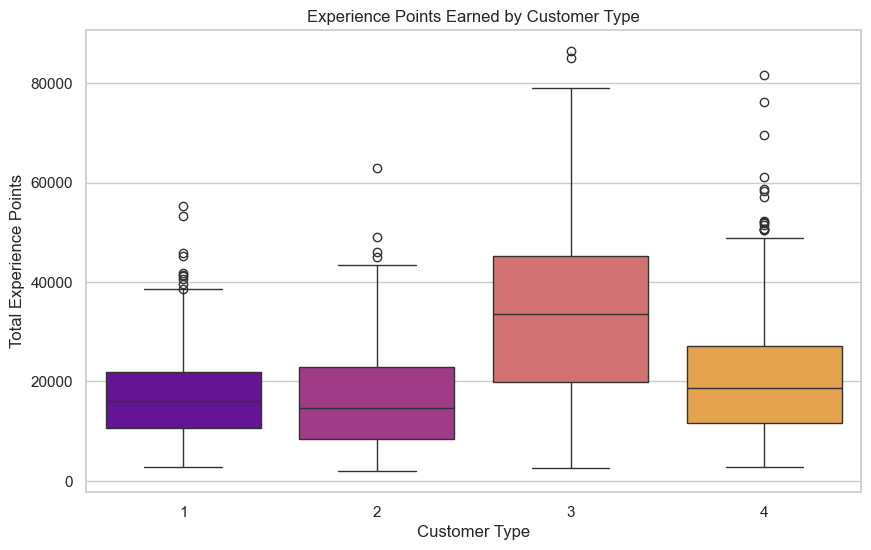

In [70]:
# Experience Points per Customer Type
plt.figure(figsize=(10,6))
sns.boxplot(x='CustomerType', y='Experience', data=active_summer_fin_trx, palette='plasma')
plt.title('Experience Points Earned by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Total Experience Points')
plt.show()

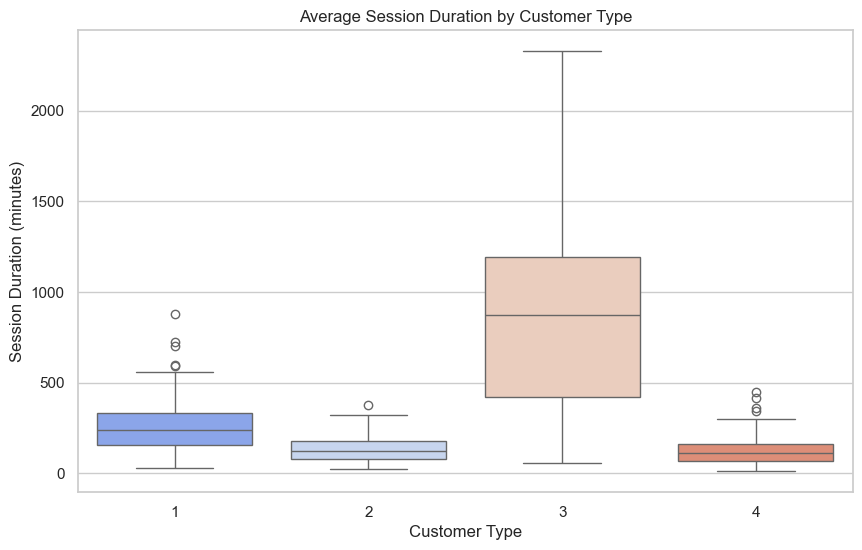

In [71]:
# Avg. Session Duration per Customer Type task 2 
plt.figure(figsize=(10,6))
sns.boxplot(x='CustomerType', y='Duration', data=active_summer_fin_trx, palette='coolwarm')
plt.title('Average Session Duration by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Session Duration (minutes)')
plt.show()

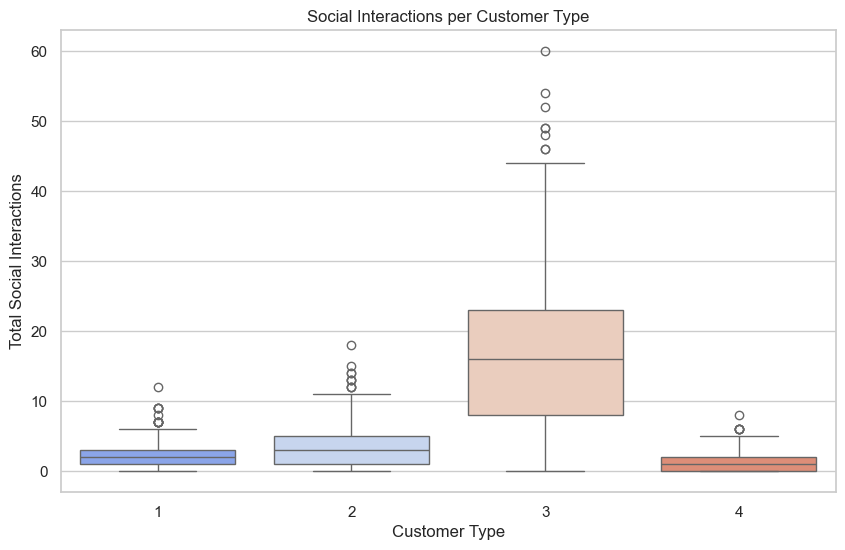

In [72]:
# Social Interactions per Customer Type
plt.figure(figsize=(10,6))
sns.boxplot(x='CustomerType', y='Social', data=active_summer_fin_trx, palette='coolwarm')
plt.title('Social Interactions per Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Total Social Interactions')
plt.show()

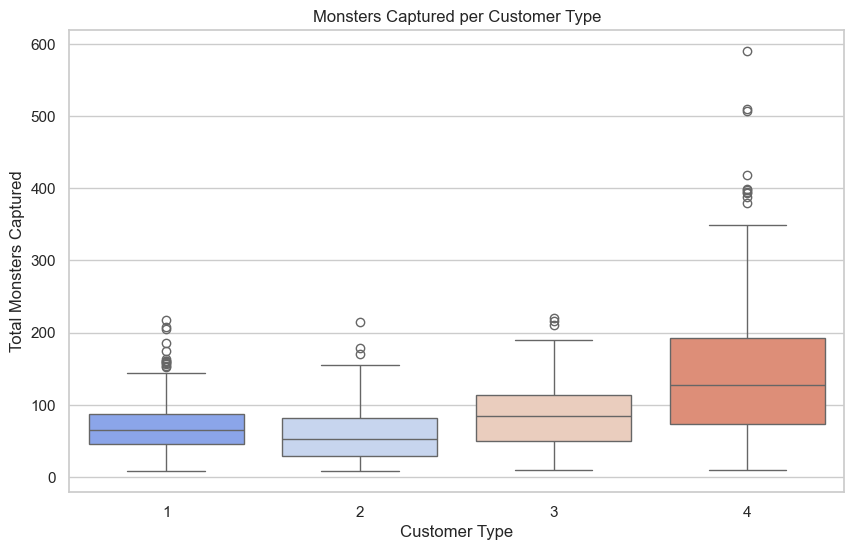

In [73]:
# Monsters Captured per Customer Type
plt.figure(figsize=(10,6))
sns.boxplot(x='CustomerType', y='Monsters', data=active_summer_fin_trx, palette='coolwarm')
plt.title('Monsters Captured per Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Total Monsters Captured')
plt.show()

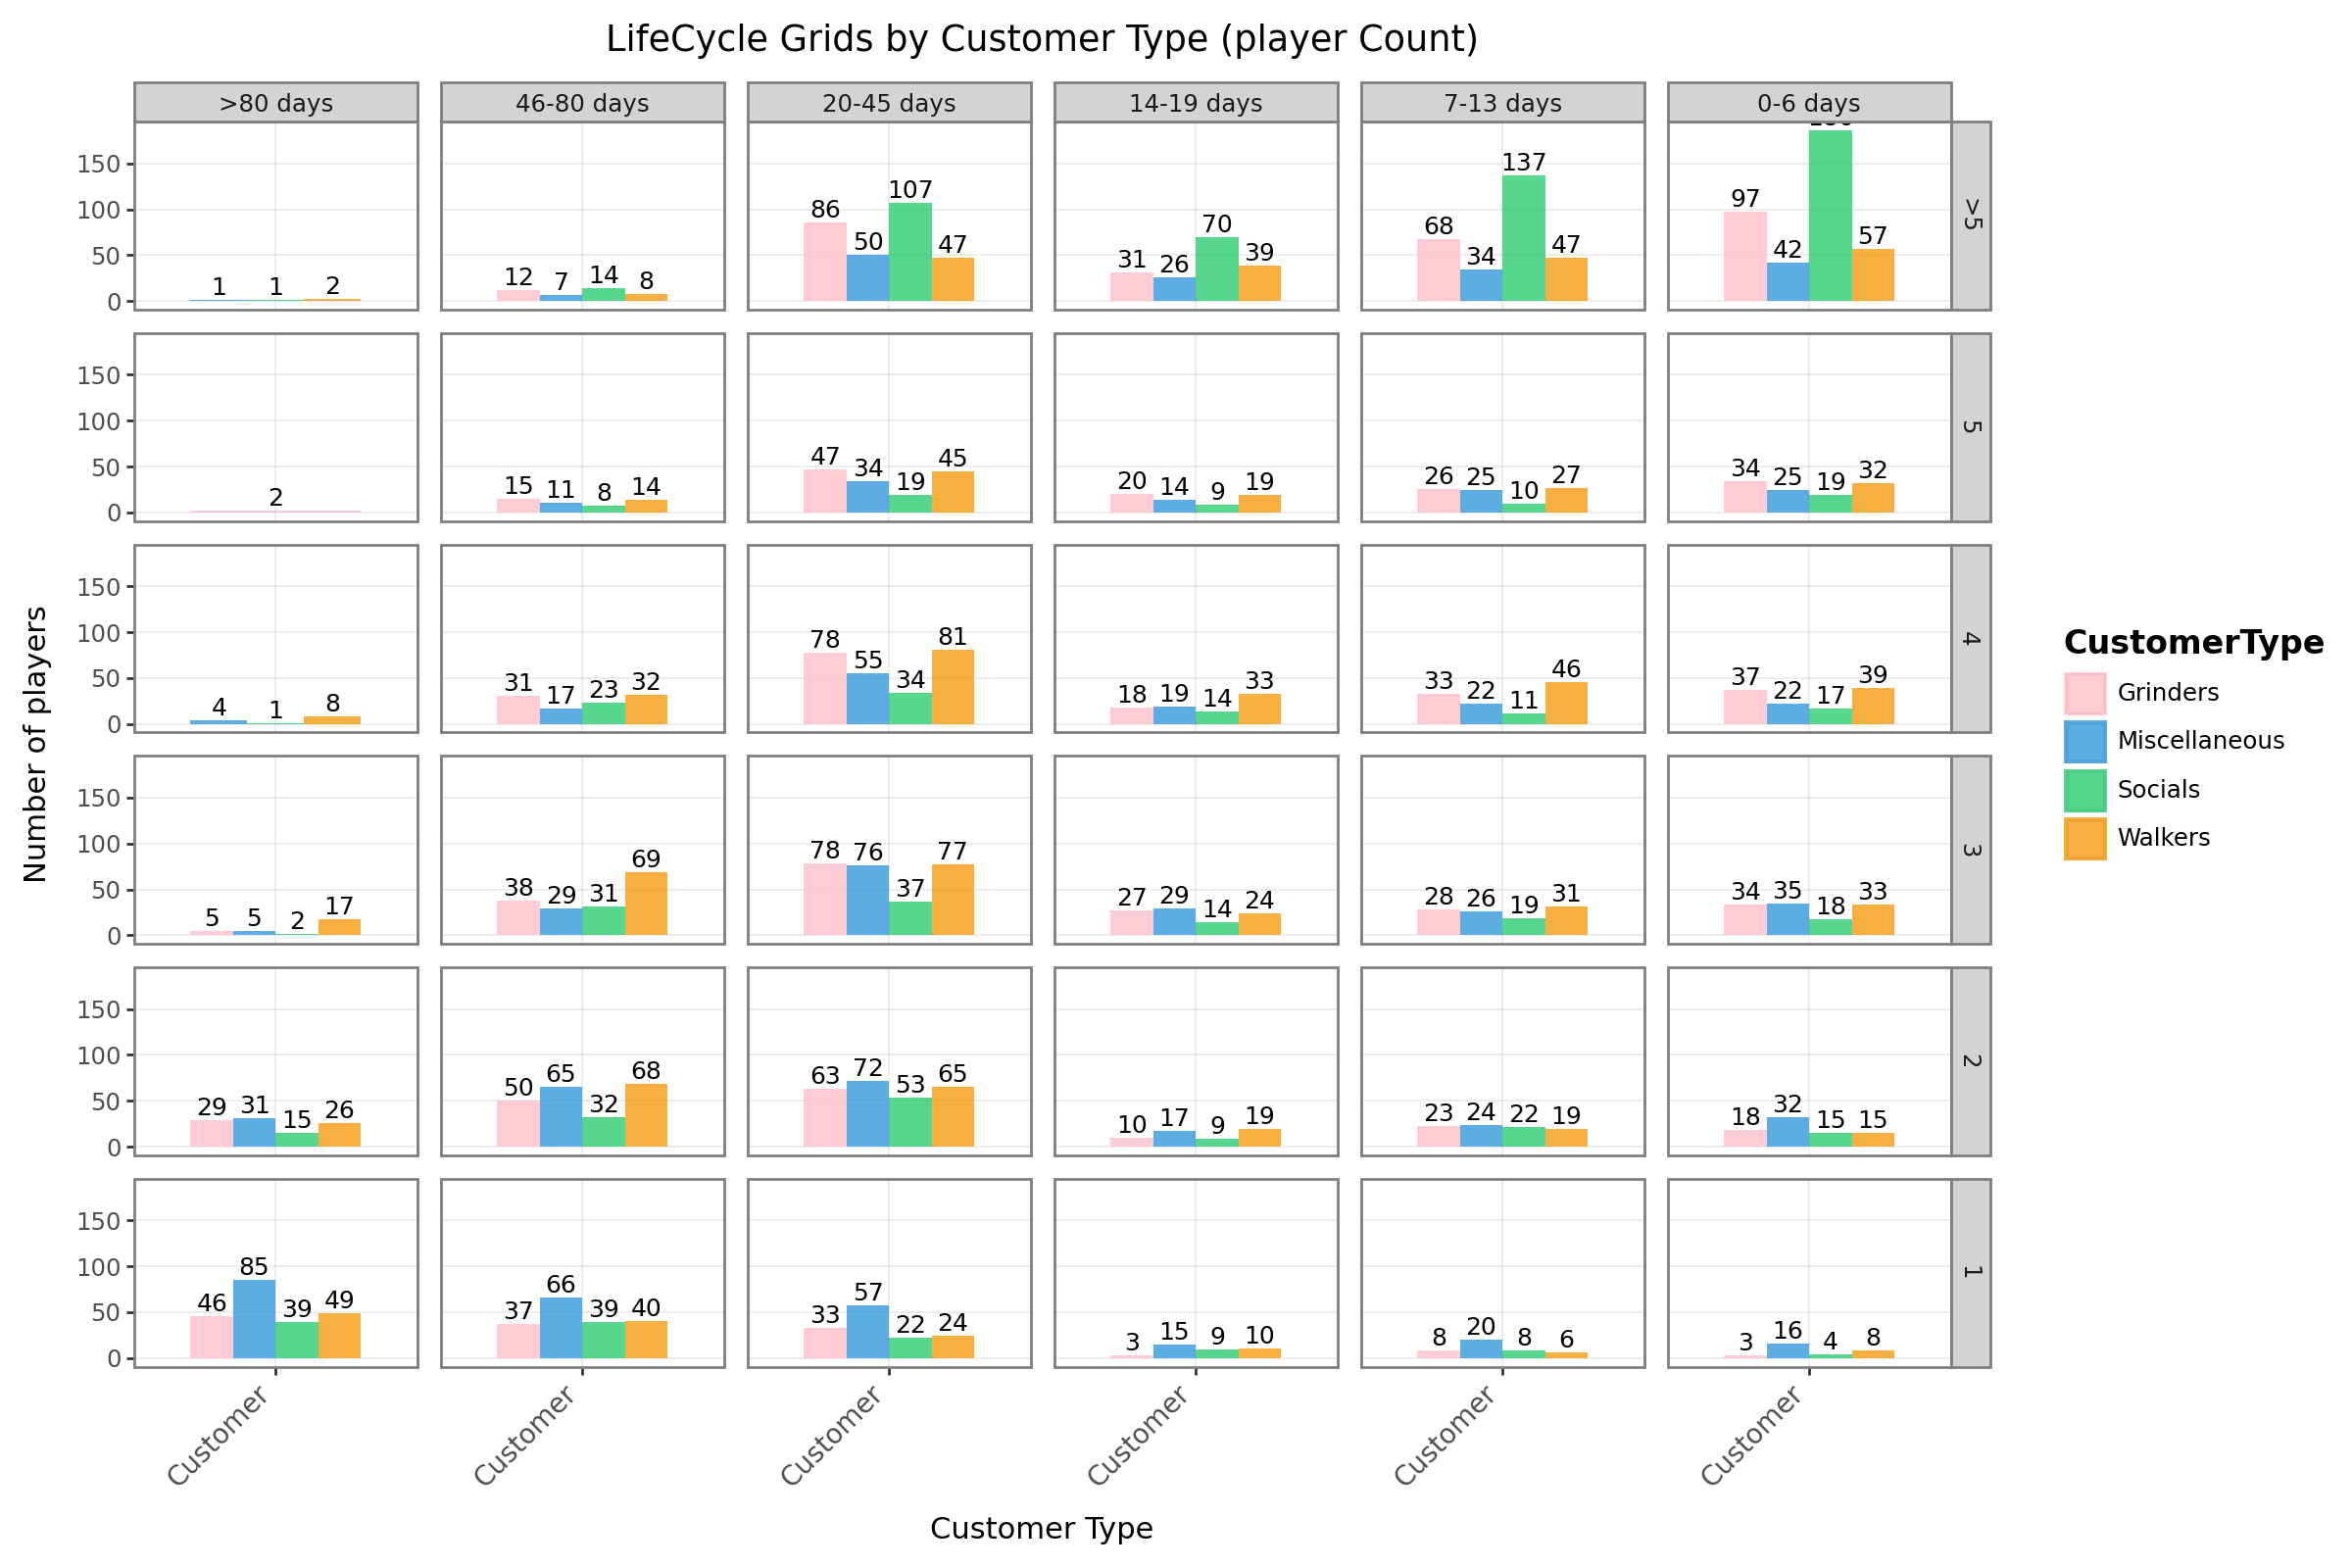

In [74]:
# Mapping CustomerType values to descriptive labels
playersegm = playersegm.merge(active_summer_customer_data[['CustomerID', 'CustomerType']], on='CustomerID', how='left')

playersegm['CustomerType'] = playersegm['CustomerType'].map({1: 'Walkers', 2: 'Miscellaneous', 3: 'Socials', 4: 'Grinders'})

lpgsub = playersegm.groupby(['CustomerType', 'segmfreq', 'segmrec'], observed=True, as_index=False).agg(quantity=('CustomerID', 'count'))
lpgsub['CustomerID'] = 'Customer'


plot8 = (ggplot(lpgsub, aes(x='CustomerID', y='quantity', fill='CustomerType')) +
    theme_bw() +  
    theme(
        panel_grid_major=element_line(size=0.1, color="gray"),  
        panel_grid_minor=element_blank(),
        legend_title=element_text(size=12, weight="bold"),  
        legend_position="right",  
        strip_background=element_rect(fill="lightgray"),  
        axis_text_x=element_text(angle=45, ha='right', size=10),  # Rotate x-axis labels
        figure_size=(12, 8)  
    ) +
    geom_bar(stat='identity', position='dodge', alpha=0.8, width=0.6) +  
    geom_text(aes(label='quantity'), position=position_dodge(width=0.6), va='bottom', size=9) +  
    facet_grid('segmfreq ~ segmrec') +  
    ggtitle("LifeCycle Grids by Customer Type (player Count)") +
    xlab("Customer Type") +
    ylab("Number of players") +
    scale_fill_manual(values=['#FFC0CB', '#3498DB', '#2ECC71', '#F39C12'])  
)


plot8.show()

### **Spending Behavior Analysis:**
**how different player types spend money in the game and their transaction behaviors**

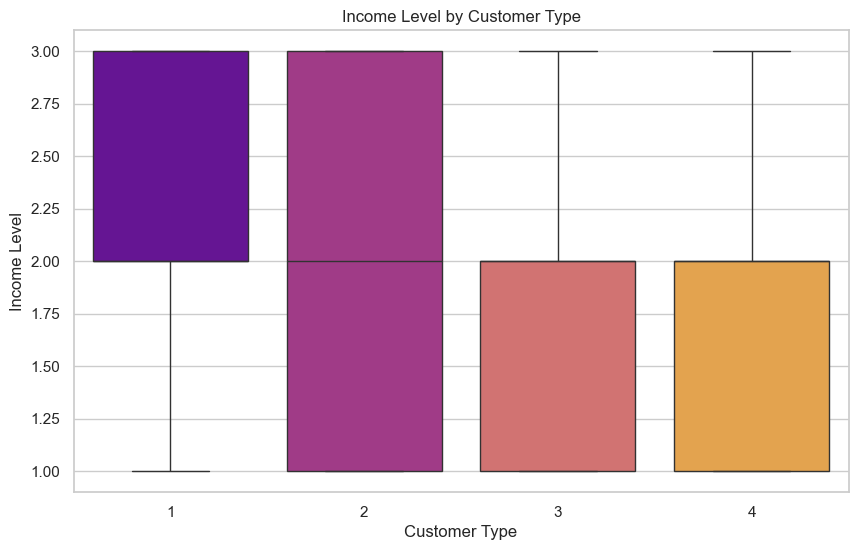

In [76]:
# Income Level by Customer Type
plt.figure(figsize=(10,6))
sns.boxplot(x='CustomerType', y='Income', data=active_summer_customer_data, palette='plasma')
plt.title('Income Level by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Income Level')
plt.show()

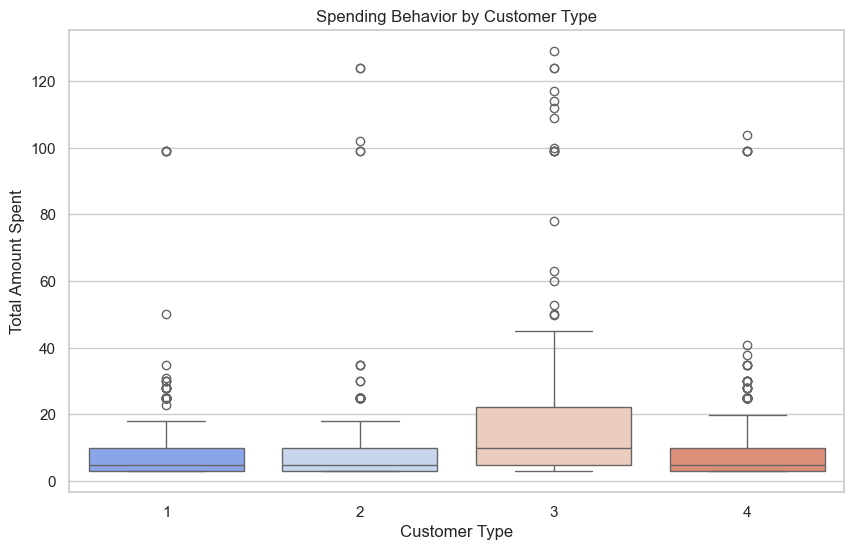

In [77]:
# Who Spends the Most? Who Spends the Least?
plt.figure(figsize=(10,6))
sns.boxplot(x='CustomerType', y='monetary_value', data=active_summer_fin_trx, palette='coolwarm')
plt.title('Spending Behavior by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Total Amount Spent')
plt.show()

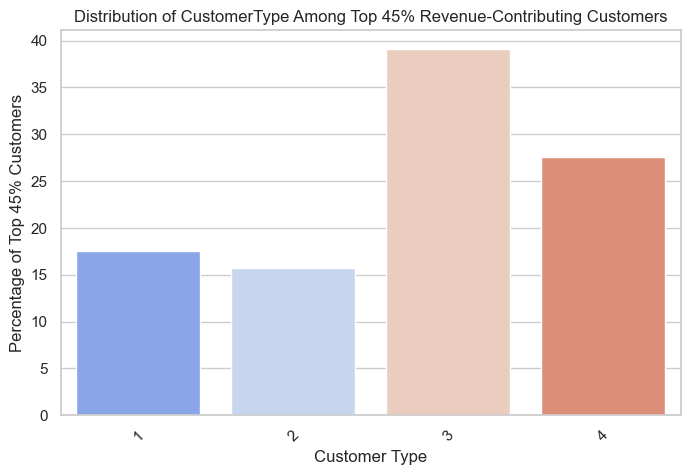

In [78]:
# Select the top 45% of customers who contribute to 80% of the revenue
top_45_percent_customers = customer_revenue.iloc[:int(len(customer_revenue) * 0.45)]
# Filter active_fall_customerdata to include only these top customers
top_customers_data = active_summer_customer_data[active_summer_customer_data["CustomerID"].isin(top_45_percent_customers["CustomerID"])]

# Count the occurrences of each CustomerType in the top 45% customers
customer_type_distribution = top_customers_data["CustomerType"].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 5))
sns.barplot(x=customer_type_distribution.index, y=customer_type_distribution.values, palette="coolwarm")
plt.xlabel("Customer Type")
plt.ylabel("Percentage of Top 45% Customers")
plt.title("Distribution of CustomerType Among Top 45% Revenue-Contributing Customers")
plt.xticks(rotation=45)
plt.show()

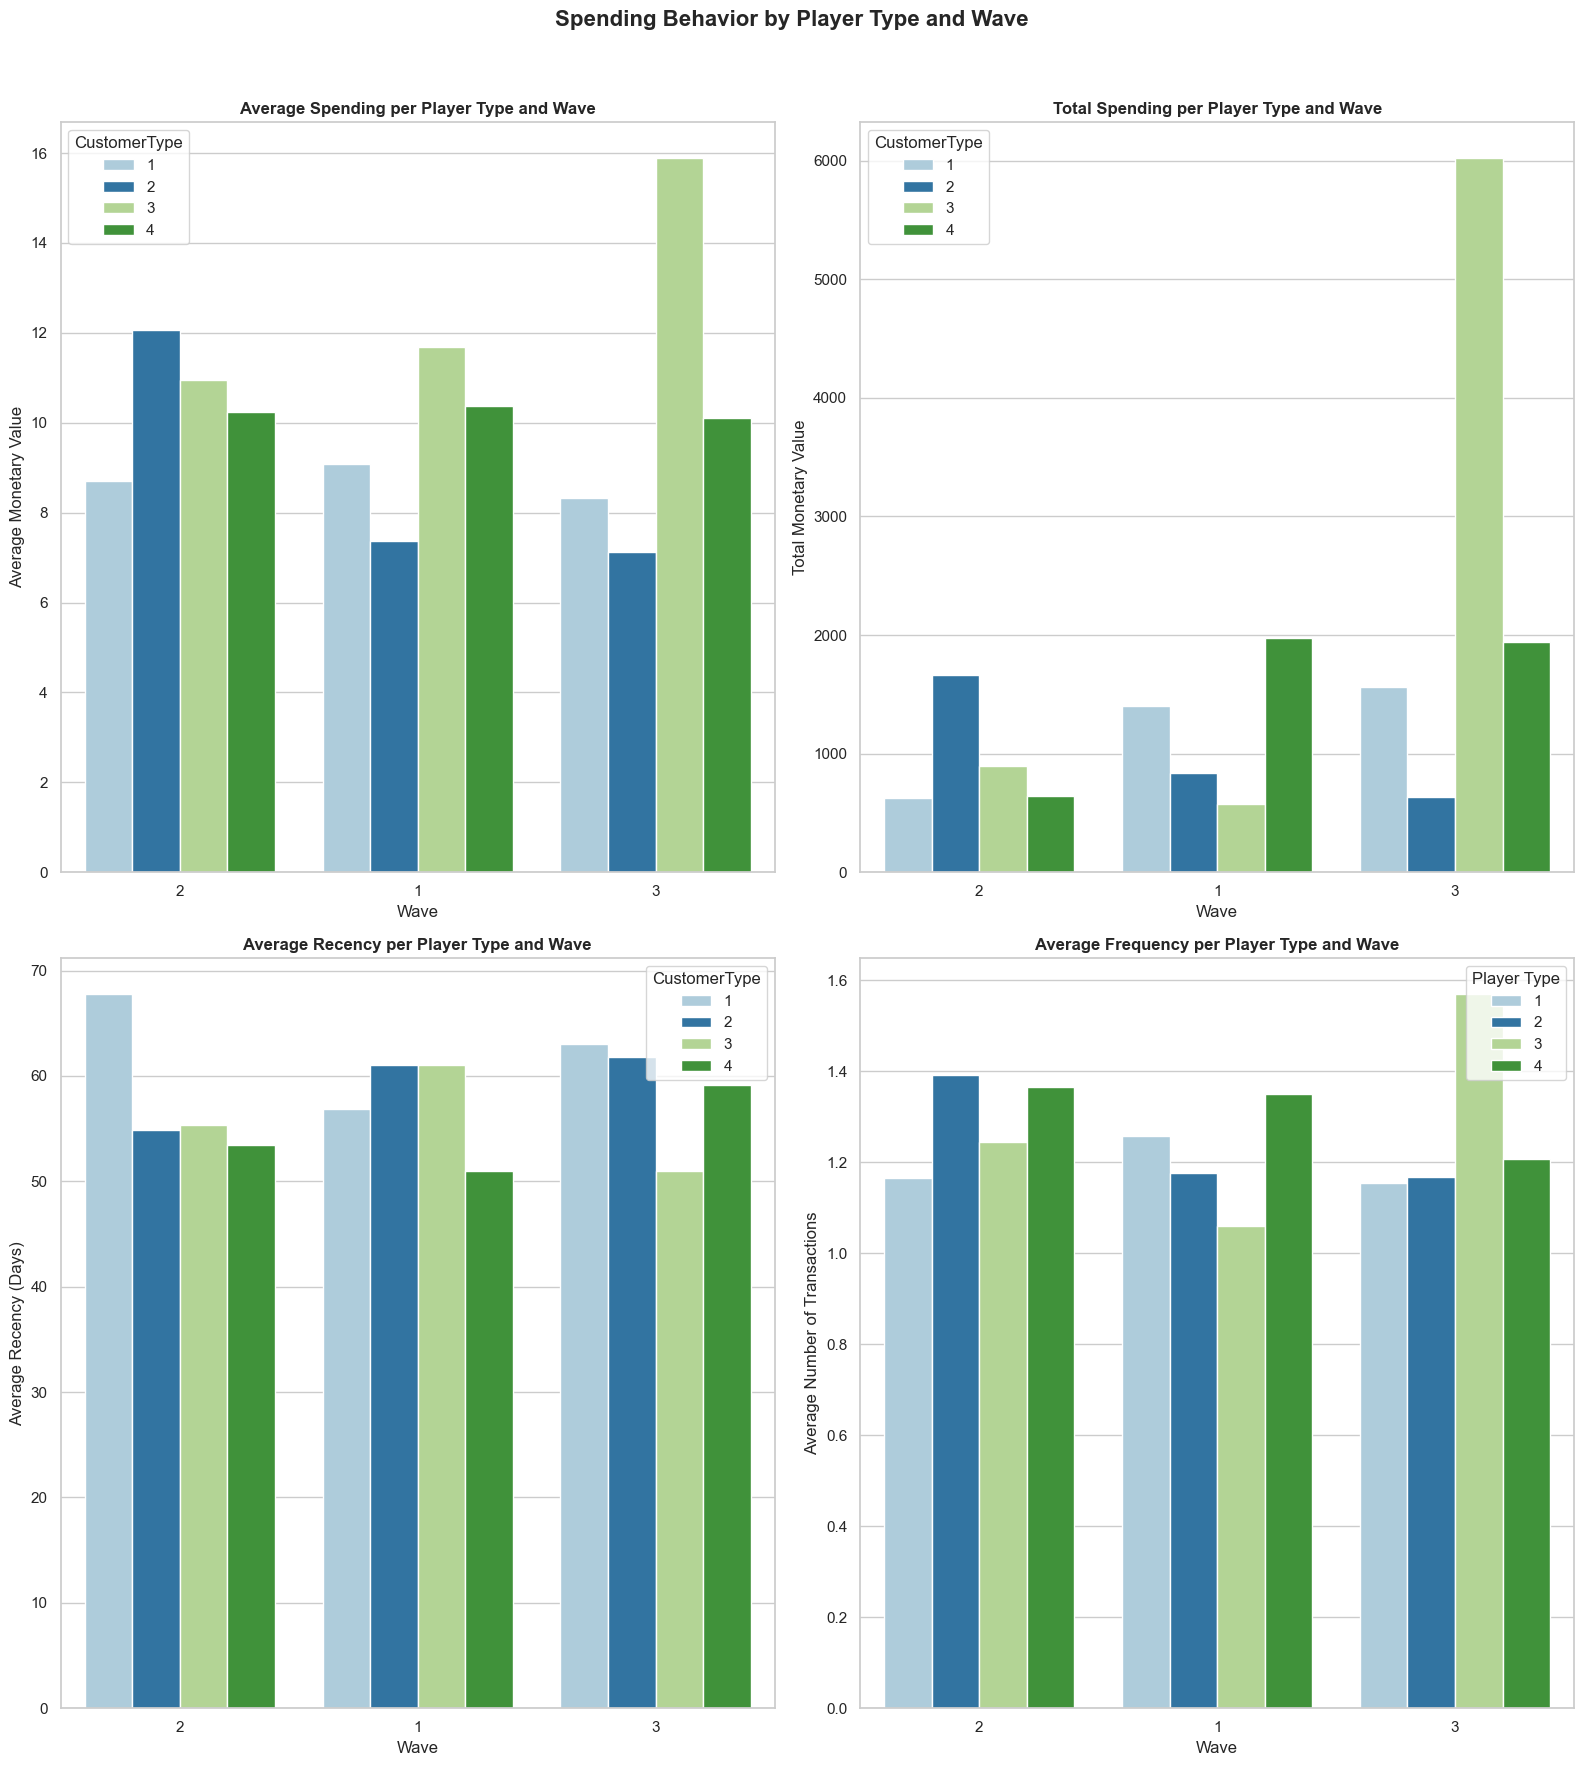

In [79]:
# Set figure style
sns.set_theme(style="whitegrid")

# Define color palette for Player Types
player_palette = {
    1: "#A6CEE3",  # Light Blue (Walkers)
    2: "#1F78B4",  # Medium Blue (Socials)
    3: "#B2DF8A",  # Light Green (Miscellaneous)
    4: "#33A02C"   # Dark Green (Grinders)
}

# Create subplots for Spending Behavior
fig, axes = plt.subplots(2, 2, figsize=(16, 18))
fig.suptitle("Spending Behavior by Player Type and Wave", fontsize=16, fontweight="bold")

# 1. Average Spending per Player Type and Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='monetary_value', hue='CustomerType', estimator='mean', ci=None, ax=axes[0, 0], palette=player_palette)
axes[0, 0].set_title("Average Spending per Player Type and Wave", fontweight="bold")
axes[0, 0].set_xlabel("Wave")
axes[0, 0].set_ylabel("Average Monetary Value")

# 2. Total Spending per Player Type and Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='monetary_value', hue='CustomerType', estimator='sum', ci=None, ax=axes[0, 1], palette=player_palette)
axes[0, 1].set_title("Total Spending per Player Type and Wave", fontweight="bold")
axes[0, 1].set_xlabel("Wave")
axes[0, 1].set_ylabel("Total Monetary Value")

# 3. Average Recency per Player Type and Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='recency', hue='CustomerType', estimator='mean', ci=None, ax=axes[1, 0], palette=player_palette)
axes[1, 0].set_title("Average Recency per Player Type and Wave", fontweight="bold")
axes[1, 0].set_xlabel("Wave")
axes[1, 0].set_ylabel("Average Recency (Days)")

# 4. Average Frequency per Player Type and Wave
sns.barplot(data=active_summer_fin_trx, x='Wave', y='frequency', hue='CustomerType', estimator='mean', ci=None, ax=axes[1, 1], palette=player_palette)
axes[1, 1].set_title("Average Frequency per Player Type and Wave", fontweight="bold")
axes[1, 1].set_xlabel("Wave")
axes[1, 1].set_ylabel("Average Number of Transactions")


# Adjust layout
plt.legend(title="Player Type", loc="upper right")
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plots
plt.show()


The spending behavior analysis by player type and wave highlights distinct differences in purchasing habits. Grinders in Wave 3 emerge as the highest spenders, both in terms of average and total spending, suggesting that newer engaged players are more willing to invest in the game. This aligns with their intense gameplay patterns observed earlier, indicating that they see value in purchasing in-game items or benefits to enhance their experience. Social players and Walkers show moderate spending across all waves, while Miscellaneous players tend to spend the least, reinforcing their more casual approach to the game.

The recency analysis shows that players in Wave 3 have a slightly lower average recency, meaning they have played more recently compared to older waves. This suggests that newer players are more active and engaged, while players from previous waves may have higher dropout rates or less frequent activity. However, the frequency of transactions remains relatively stable across all waves and player types, indicating that those who do spend tend to do so at a consistent rate, regardless of when they joined.

Overall, the data suggests that recent players, particularly Grinders, are significantly more invested in the game, both in terms of playtime and spending. While Social players maintain steady engagement, Walkers and Miscellaneous players exhibit lower spending and activity levels, indicating that they might require additional incentives to encourage higher in-game purchases.

**GRIDS**

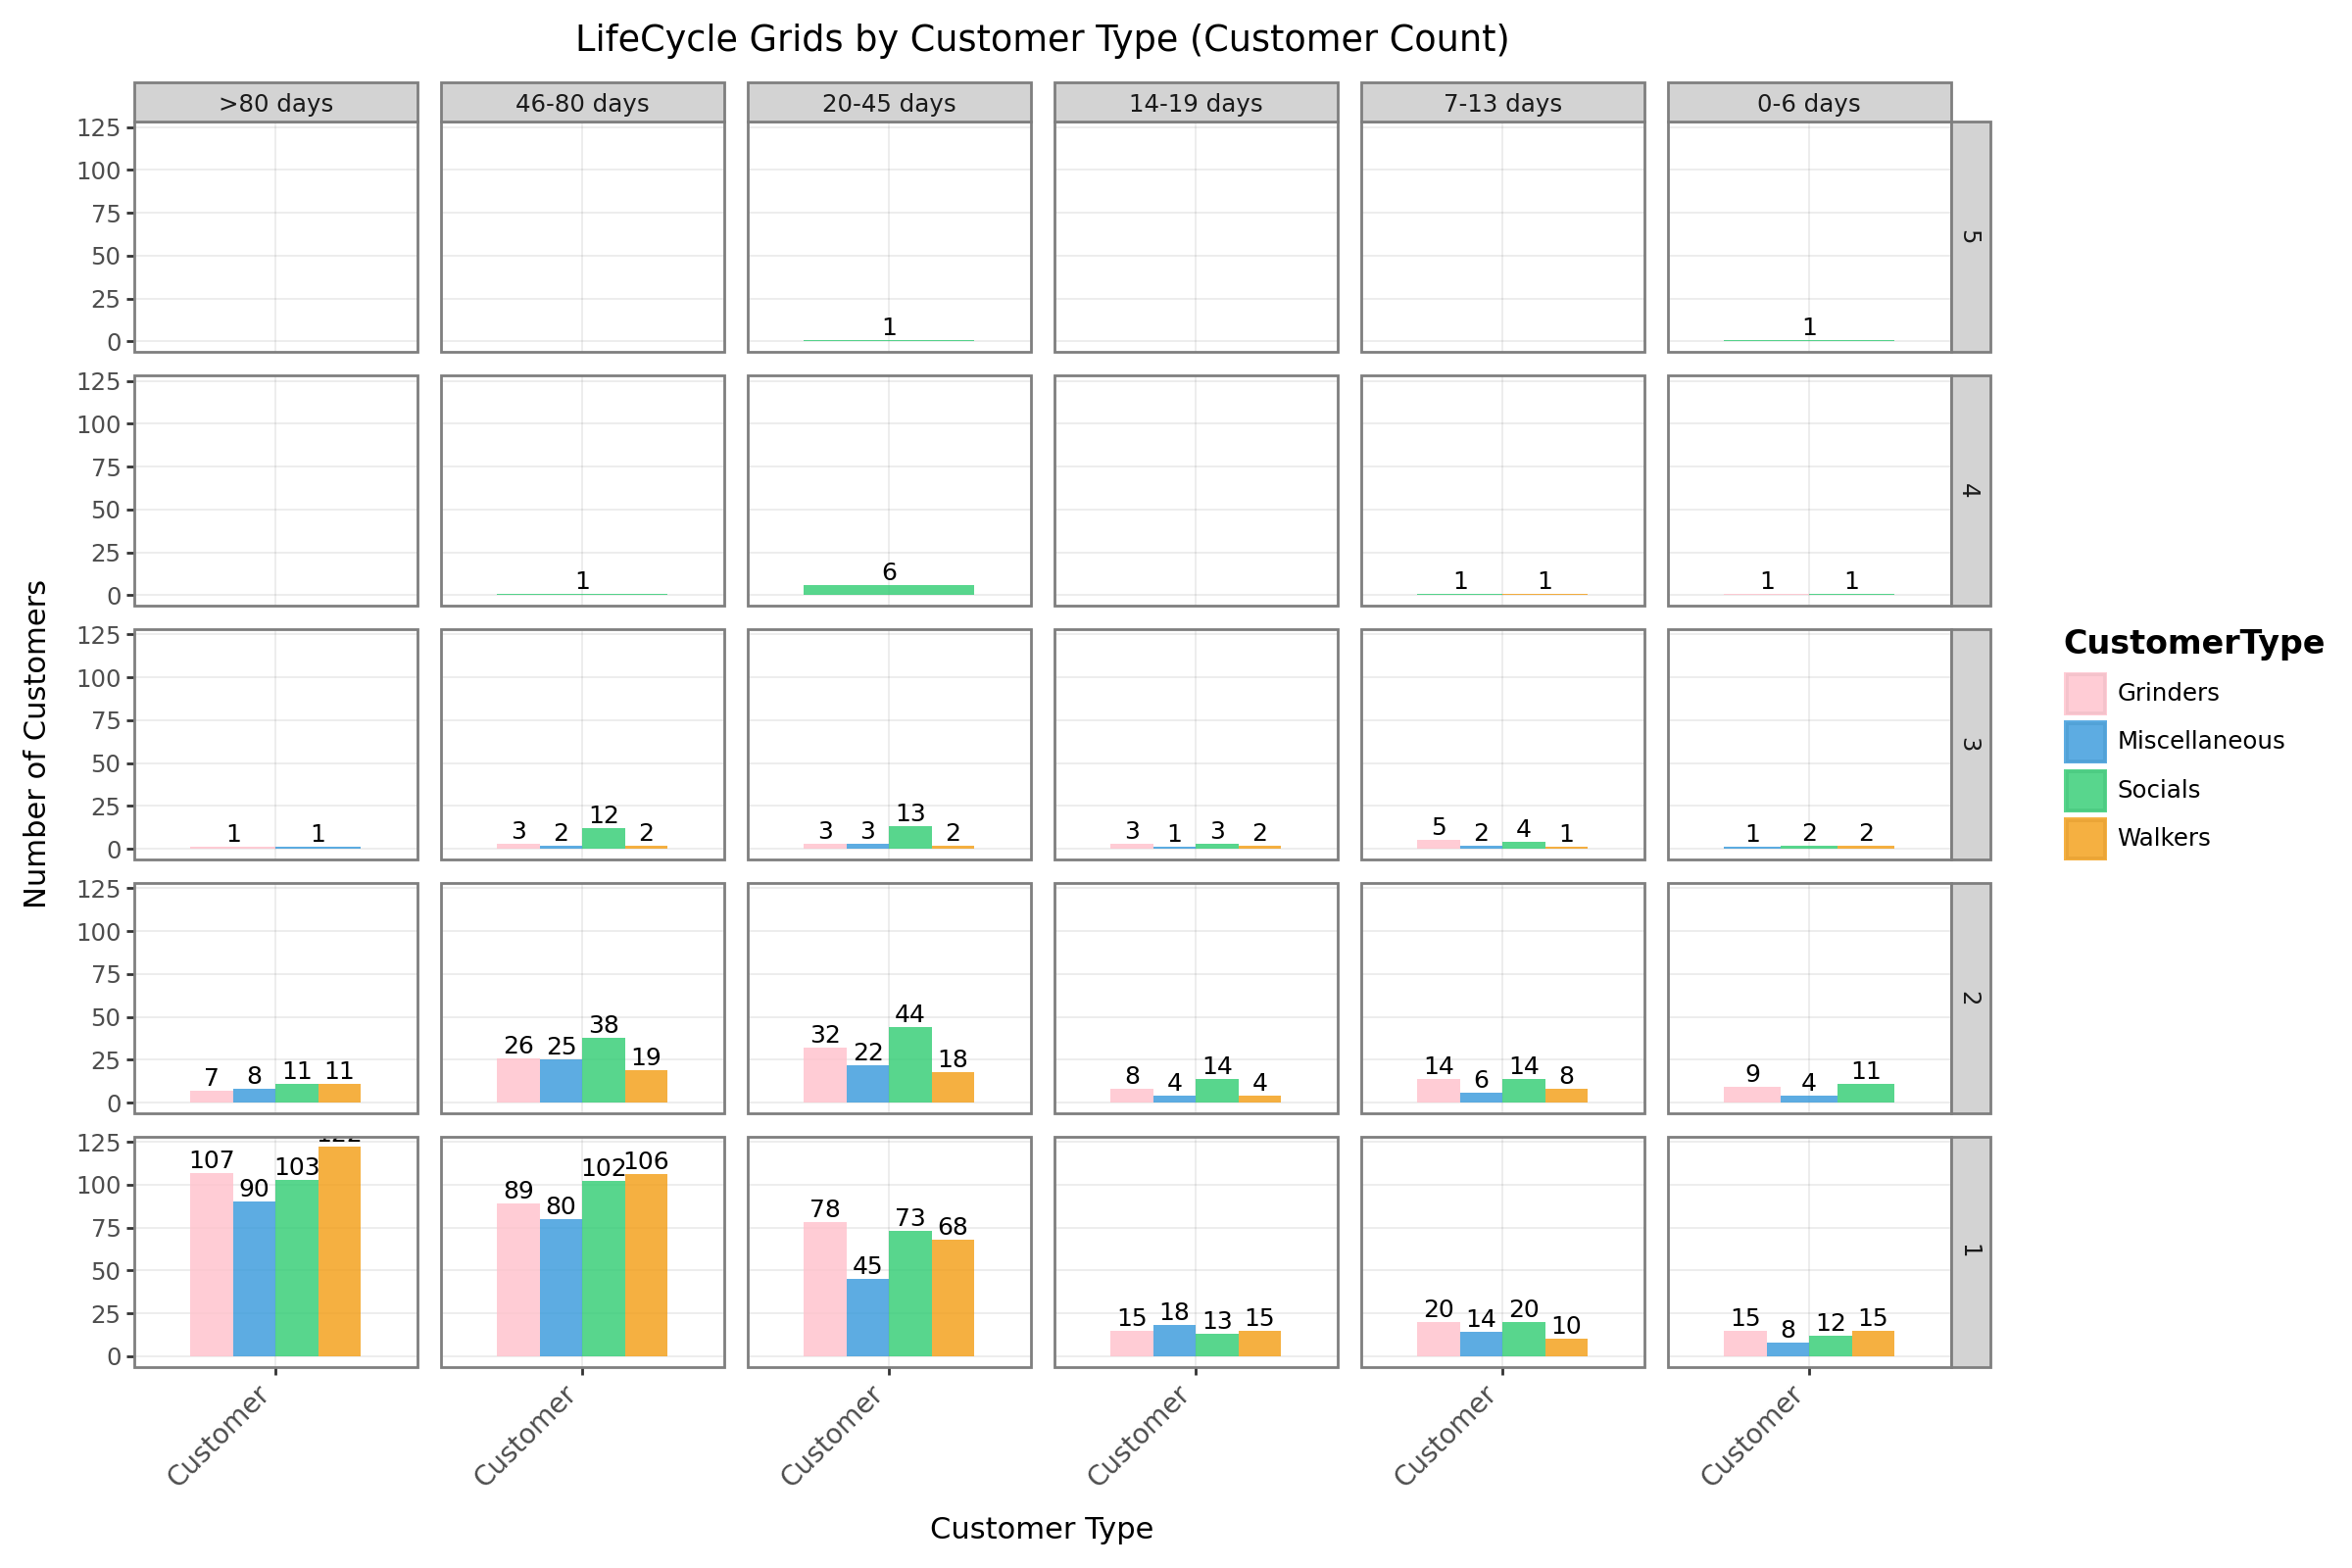

In [82]:
# Mapping CustomerType values to descriptive labels
customersegm['CustomerType'] = customersegm['CustomerType'].map({1: 'Walkers', 2: 'Miscellaneous', 3: 'Socials', 4: 'Grinders'})
lcgsub = customersegm.groupby(['CustomerType', 'segmfreq', 'segmrec'], observed=True, as_index=False).agg(quantity=('CustomerID', 'count'))
lcgsub['CustomerID'] = 'Customer'

plot2 = (ggplot(lcgsub, aes(x='CustomerID', y='quantity', fill='CustomerType')) +
    theme_bw() +  
    theme(
        panel_grid_major=element_line(size=0.1, color="gray"),  
        panel_grid_minor=element_blank(),
        legend_title=element_text(size=12, weight="bold"),  
        legend_position="right",  
        strip_background=element_rect(fill="lightgray"),  
        axis_text_x=element_text(angle=45, ha='right', size=10),  # Rotate x-axis labels
        figure_size=(12, 8)  
    ) +
    geom_bar(stat='identity', position='dodge', alpha=0.8, width=0.6) +  
    geom_text(aes(label='quantity'), position=position_dodge(width=0.6), va='bottom', size=9) +  
    facet_grid('segmfreq ~ segmrec') +  
    ggtitle("LifeCycle Grids by Customer Type (Customer Count)") +
    xlab("Customer Type") +
    ylab("Number of Customers") +
    scale_fill_manual(values=['#FFC0CB', '#3498DB', '#2ECC71', '#F39C12'])  
)

plot2.show()

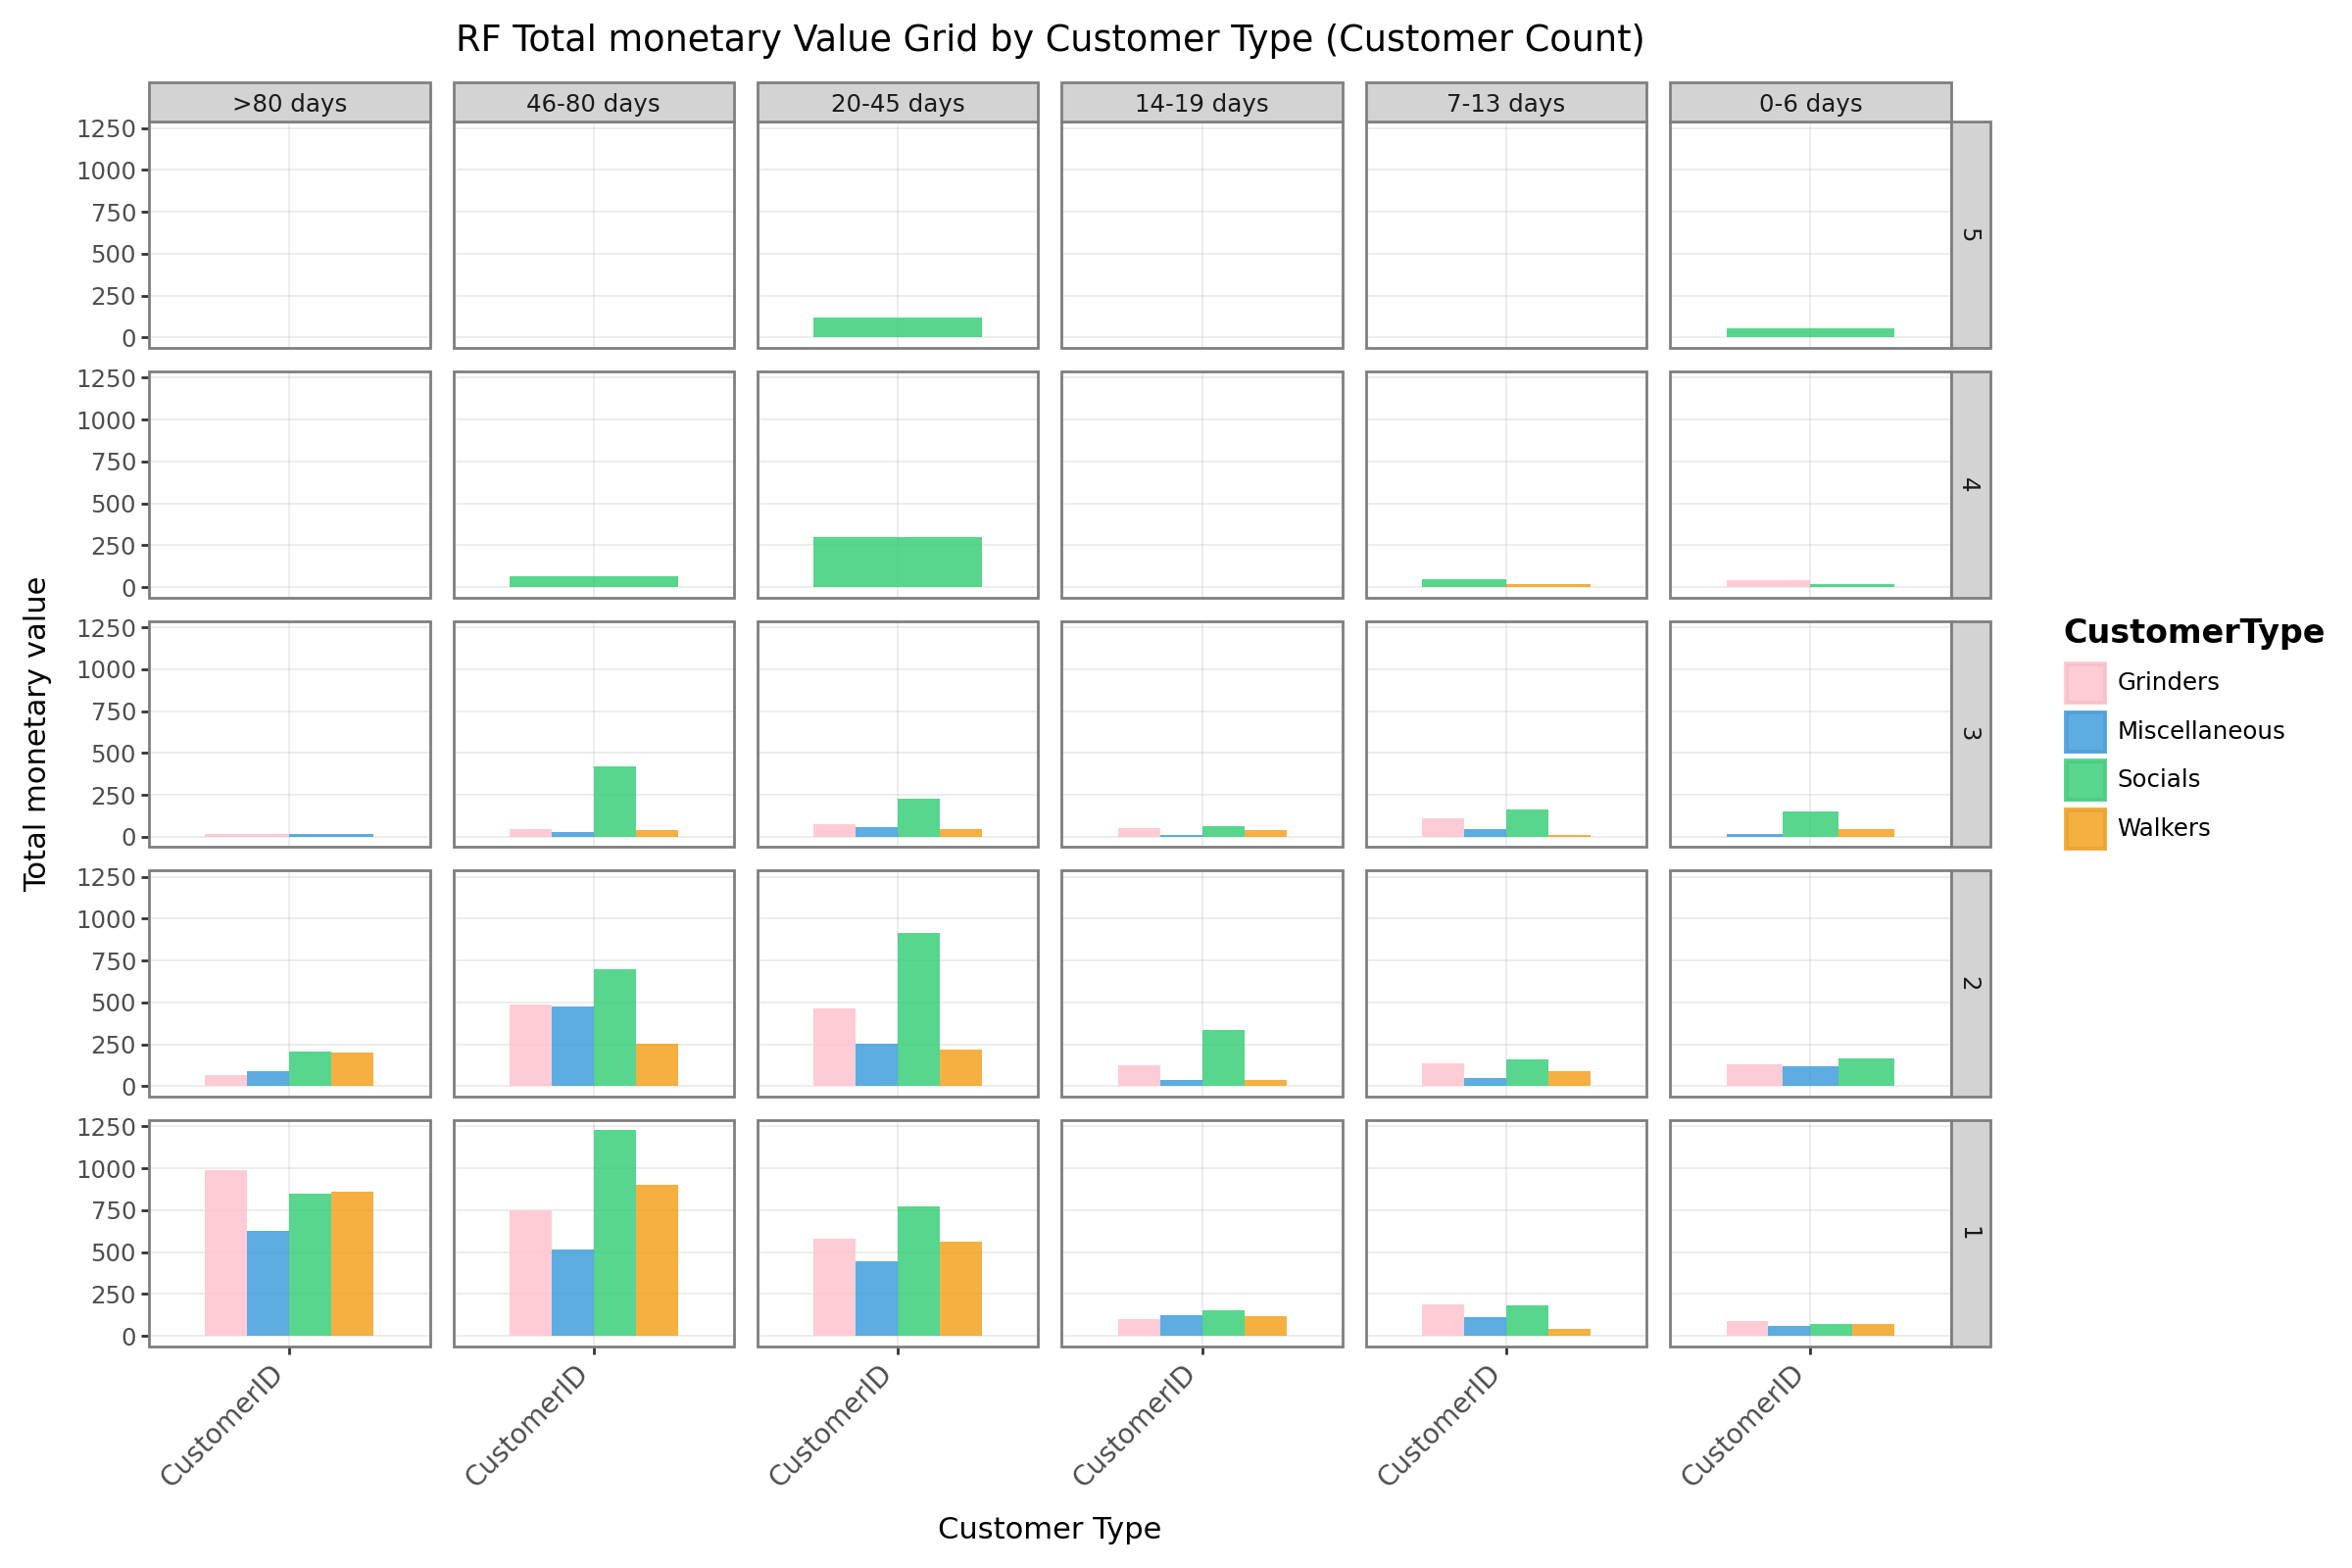

In [83]:
lcgtmon = customersegm.groupby(['CustomerType','segmfreq', 'segmrec'], observed=True, as_index=False).agg(
    totalmonvalue=('monetary_value', 'sum')  # Sum monetary_value values per RF segment
)
lcgtmon['CustomerID'] = 'CustomerID'  # Dummy x-axis label

plotlcgtmon = (ggplot(lcgtmon, aes(x='CustomerID', y='totalmonvalue', fill='CustomerType')) +
    theme_bw() +  
    theme(
        panel_grid_major=element_line(size=0.1, color="gray"),  
        panel_grid_minor=element_blank(),
        legend_title=element_text(size=12, weight="bold"),  
        legend_position="right",  
        strip_background=element_rect(fill="lightgray"),  
        axis_text_x=element_text(angle=45, ha='right', size=10),  # Rotate x-axis labels
        figure_size=(12, 8)  
    ) +
    geom_bar(stat='identity', position='dodge', alpha=0.8, width=0.6) +  
    facet_grid('segmfreq ~ segmrec') +  
    ggtitle("RF Total monetary Value Grid by Customer Type (Customer Count)") +
    xlab("Customer Type") +
    ylab("Total monetary value") +
    scale_fill_manual(values=['#FFC0CB', '#3498DB', '#2ECC71', '#F39C12'])  
)

plotlcgtmon.show()

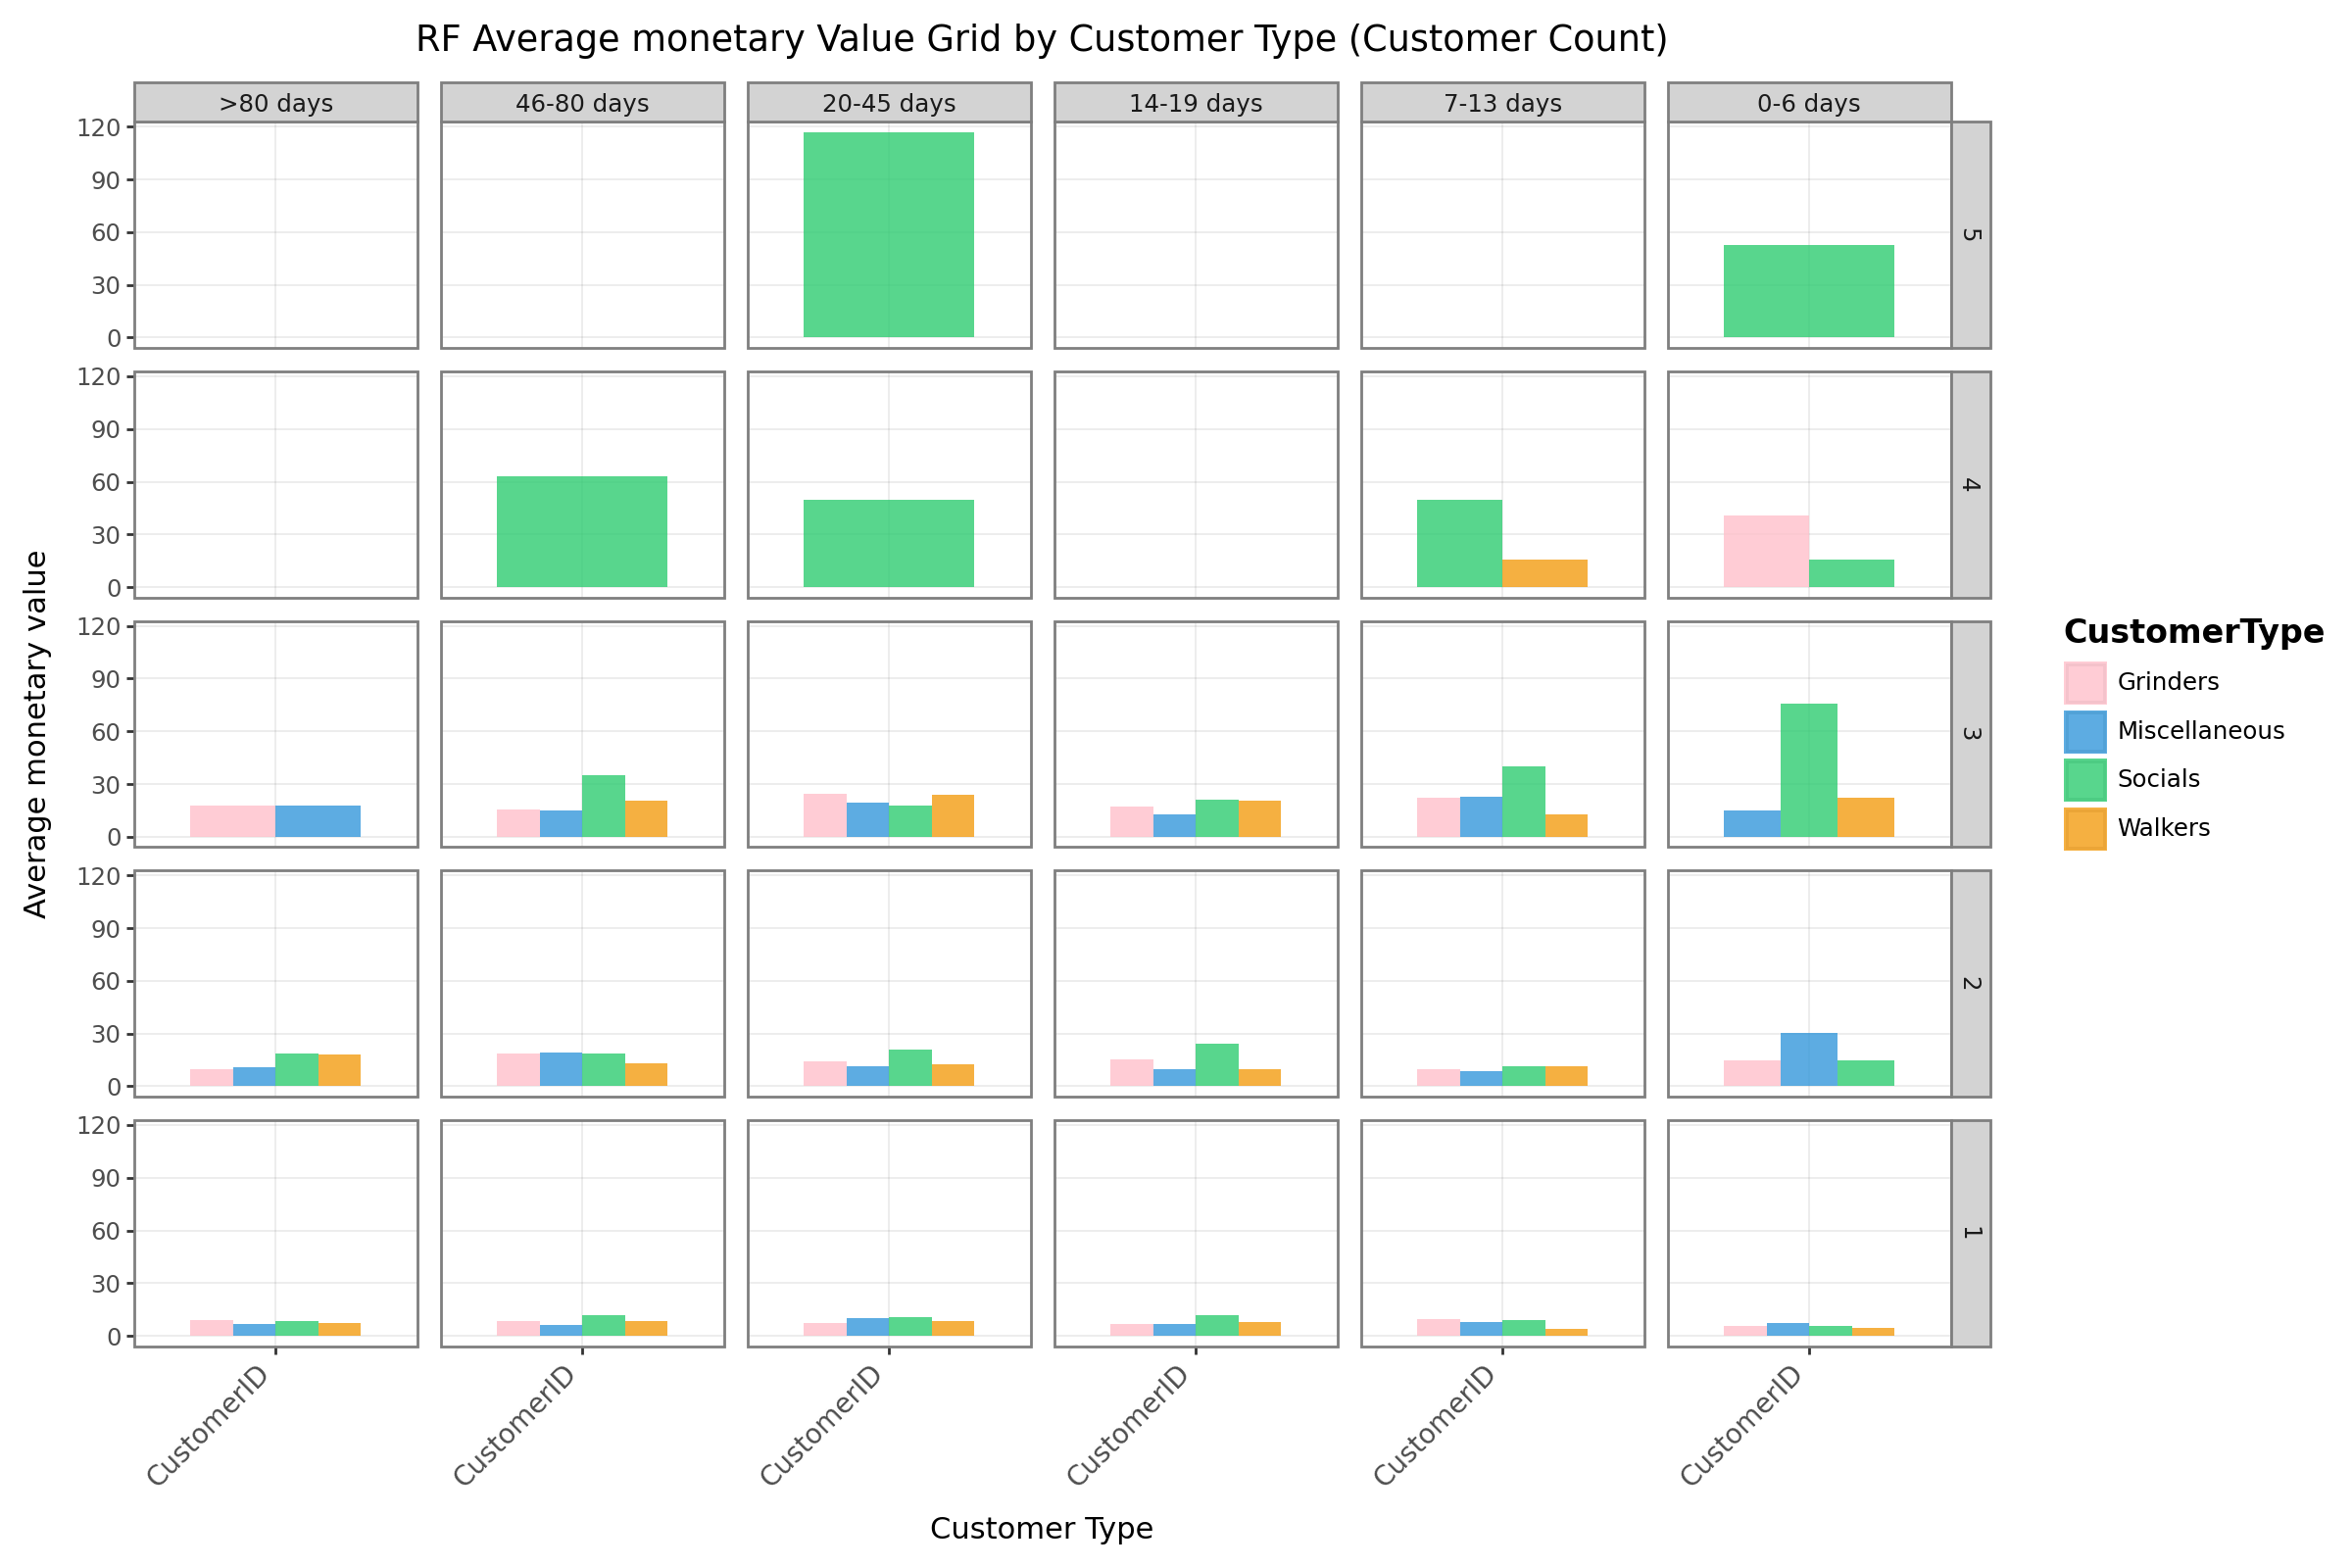

In [84]:
lcgvmon = customersegm.groupby(['CustomerType','segmfreq', 'segmrec'], observed=True, as_index=False).agg(
    avgmonvalue=('monetary_value', 'mean')  # avg monetary_value values per RF segment
)
lcgvmon['CustomerID'] = 'CustomerID'  # Dummy x-axis label

plotlcgvmon = (ggplot(lcgvmon, aes(x='CustomerID', y='avgmonvalue', fill='CustomerType')) +
    theme_bw() +  
    theme(
        panel_grid_major=element_line(size=0.1, color="gray"),  
        panel_grid_minor=element_blank(),
        legend_title=element_text(size=12, weight="bold"),  
        legend_position="right",  
        strip_background=element_rect(fill="lightgray"),  
        axis_text_x=element_text(angle=45, ha='right', size=10),  # Rotate x-axis labels
        figure_size=(12, 8)  
    ) +
    geom_bar(stat='identity', position='dodge', alpha=0.8, width=0.6) +  
    facet_grid('segmfreq ~ segmrec') +  
    ggtitle("RF Average monetary Value Grid by Customer Type (Customer Count)") +
    xlab("Customer Type") +
    ylab("Average monetary value") +
    scale_fill_manual(values=['#FFC0CB', '#3498DB', '#2ECC71', '#F39C12'])  
)

plotlcgvmon.show()

**DECILE ANALYSIS**

In [86]:
active_summer_fin_trx['Group'] = pd.qcut(active_summer_fin_trx['monetary_value'], q=3, labels=False)
valuegroup = active_summer_fin_trx.groupby('Group').agg(averagevalue=('monetary_value', 'mean'))
# Merge to maintain structure
deciletable = valuegroup.copy()
deciletable['Index'] = deciletable['averagevalue'] / deciletable['averagevalue'].mean() * 100
deciletable

averagevalue       Index
Group                          
0          3.923921   28.540078
1          8.925887   64.921166
2         28.396618  206.538756

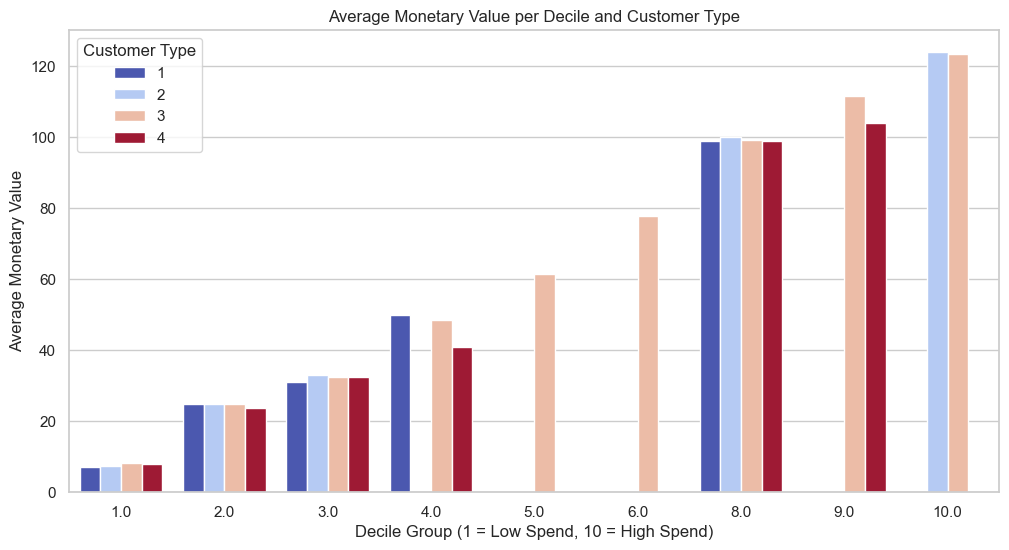

In [87]:
active_summer_fin_trx = active_summer_fin_trx.sort_values(by='monetary_value', ascending=False)
# Determine the number of unique values in 'monetary_value'
num_unique_values = active_summer_fin_trx['monetary_value'].nunique()

# Set initial number of bins (deciles)
num_bins = min(10, num_unique_values)  # Maximum 10 bins, but limited by unique values

# Get the number of unique monetary values
num_unique_values = active_summer_fin_trx['monetary_value'].nunique()

# Set the number of bins to at most 10, but limit it by unique values
num_bins = min(10, num_unique_values)

# Ensure at least 2 bins exist
if num_bins > 1:
    # Step 1: Generate bin edges using unique values, ensuring uniqueness
    _, bin_edges = np.histogram(active_summer_fin_trx['monetary_value'], bins=num_bins)

    # Step 2: Remove duplicate edges
    bin_edges = np.unique(bin_edges)

    # Step 3: Ensure at least 2 bin edges exist (so at least 1 valid bin)
    if len(bin_edges) > 2:
        # Step 4: Assign customers into deciles using clean bin edges
        active_summer_fin_trx['Monetary_Decile'] = pd.cut(
            active_summer_fin_trx['monetary_value'], bins=bin_edges, labels=range(1, len(bin_edges))
        )

        # Convert to numeric for further analysis
        active_summer_fin_trx['Monetary_Decile'] = pd.to_numeric(active_summer_fin_trx['Monetary_Decile'])

        # Compute average spending per decile & customer type
        decile_avg_value = active_summer_fin_trx.groupby(['Monetary_Decile', 'CustomerType']).agg(
        AverageValue=('monetary_value', 'mean')
        ).reset_index()
        plt.figure(figsize=(12,6))
        sns.barplot(x='Monetary_Decile', y='AverageValue', hue='CustomerType', data=decile_avg_value, palette='coolwarm')
        plt.title('Average Monetary Value per Decile and Customer Type')
        plt.xlabel('Decile Group (1 = Low Spend, 10 = High Spend)')
        plt.ylabel('Average Monetary Value')
        plt.legend(title="Customer Type")
        plt.show()

In [88]:
# Create RF segments using quartiles
active_summer_fin_trx['R_Quartile'] = pd.qcut(active_summer_fin_trx['recency'], 4, labels=[4, 3, 2, 1])  # Lower is better
active_summer_fin_trx['F_Quartile'] = pd.qcut(active_summer_fin_trx['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])  # Higher is better

# Create RF Score (combining Recency & Frequency)
active_summer_fin_trx['RF_Score'] = active_summer_fin_trx['R_Quartile'].astype(str) + active_summer_fin_trx['F_Quartile'].astype(str)

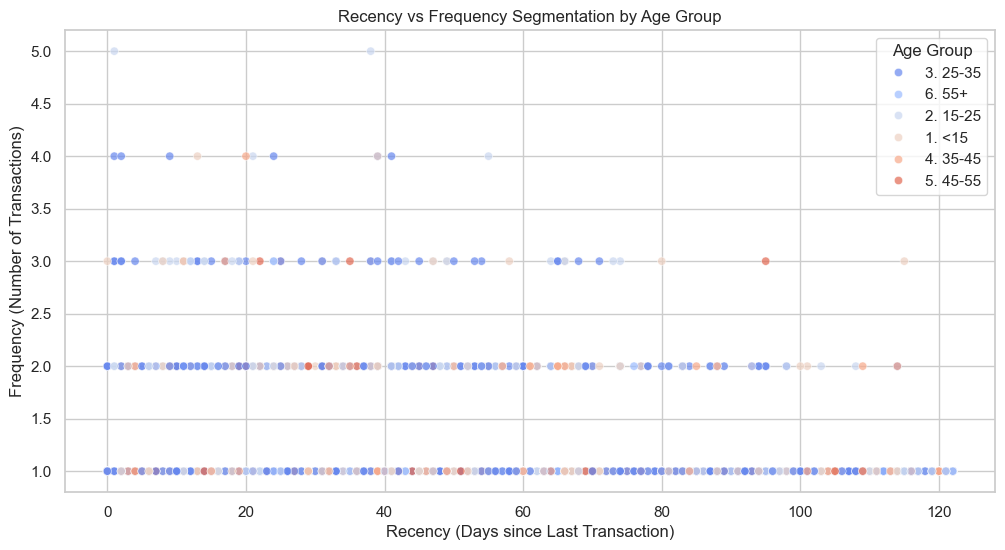

In [89]:
# Scatter Plot of Recency vs. Frequency by Age Group
plt.figure(figsize=(12,6))
sns.scatterplot(x='recency', y='frequency', hue='AgeGroup', data=active_summer_fin_trx, palette='coolwarm', alpha=0.7)
plt.title('Recency vs Frequency Segmentation by Age Group')
plt.xlabel('Recency (Days since Last Transaction)')
plt.ylabel('Frequency (Number of Transactions)')
plt.legend(title='Age Group')
plt.show()

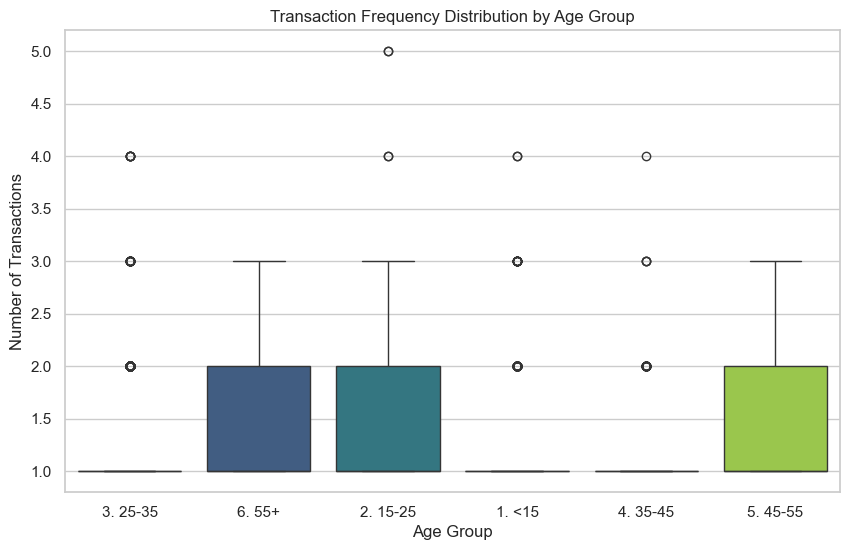

In [90]:
# Boxplot of Frequency per Age Group
plt.figure(figsize=(10,6))
sns.boxplot(x='AgeGroup', y='frequency', data=active_summer_fin_trx, palette='viridis')
plt.title('Transaction Frequency Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Transactions')
plt.show()

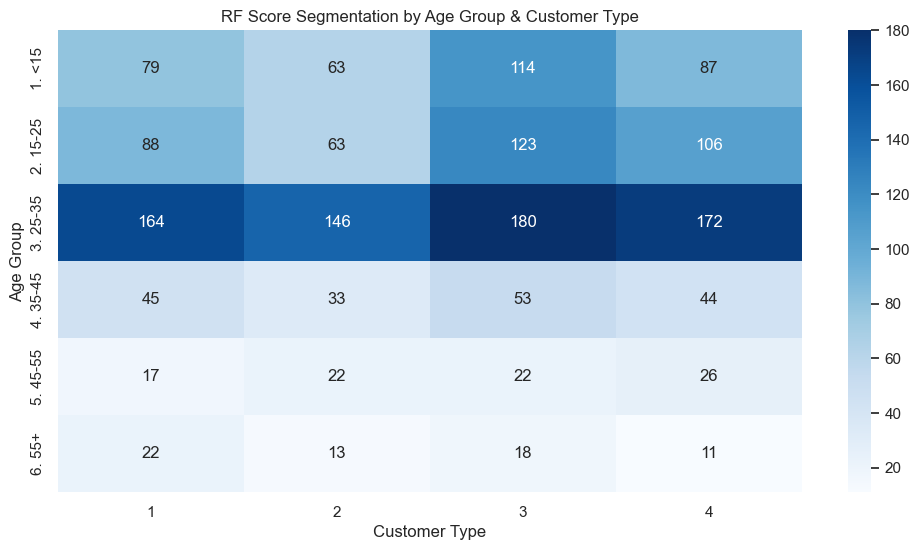

In [91]:
# Heatmap of RF Score Distribution by Age Group & Customer Type 
rf_heatmap = active_summer_fin_trx.groupby(['AgeGroup', 'CustomerType'], as_index=False).agg(Count=('CustomerID', 'count'))

# Pivot table to get AgeGroup as index and CustomerType as columns
rf_heatmap_pivot = rf_heatmap.pivot(index='AgeGroup', columns='CustomerType', values='Count')

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(rf_heatmap_pivot, cmap="Blues", annot=True, fmt="g")
plt.title('RF Score Segmentation by Age Group & Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Age Group')
plt.show()

 # TASK 3 

# CHURN ANALYSIS
 Calculate the churn behavior of the active player base during the fall, and develop and evaluate a churn model. For reference, CEVER Technologies defines churn as a player who executed at least one microtransaction in the summer period and did not perform any microtransactions during the fall of 2022.

In [94]:
fallsesstrx = pd.read_csv("fallsesstrx_case.csv", parse_dates=['Date'])
fallfintrx = pd.read_csv("fallfintrx_case.csv", parse_dates=['Date'])
fallsesstrx['Date'] = pd.to_datetime(fallsesstrx['Date'])
fallfintrx['Date'] = pd.to_datetime(fallfintrx['Date'])

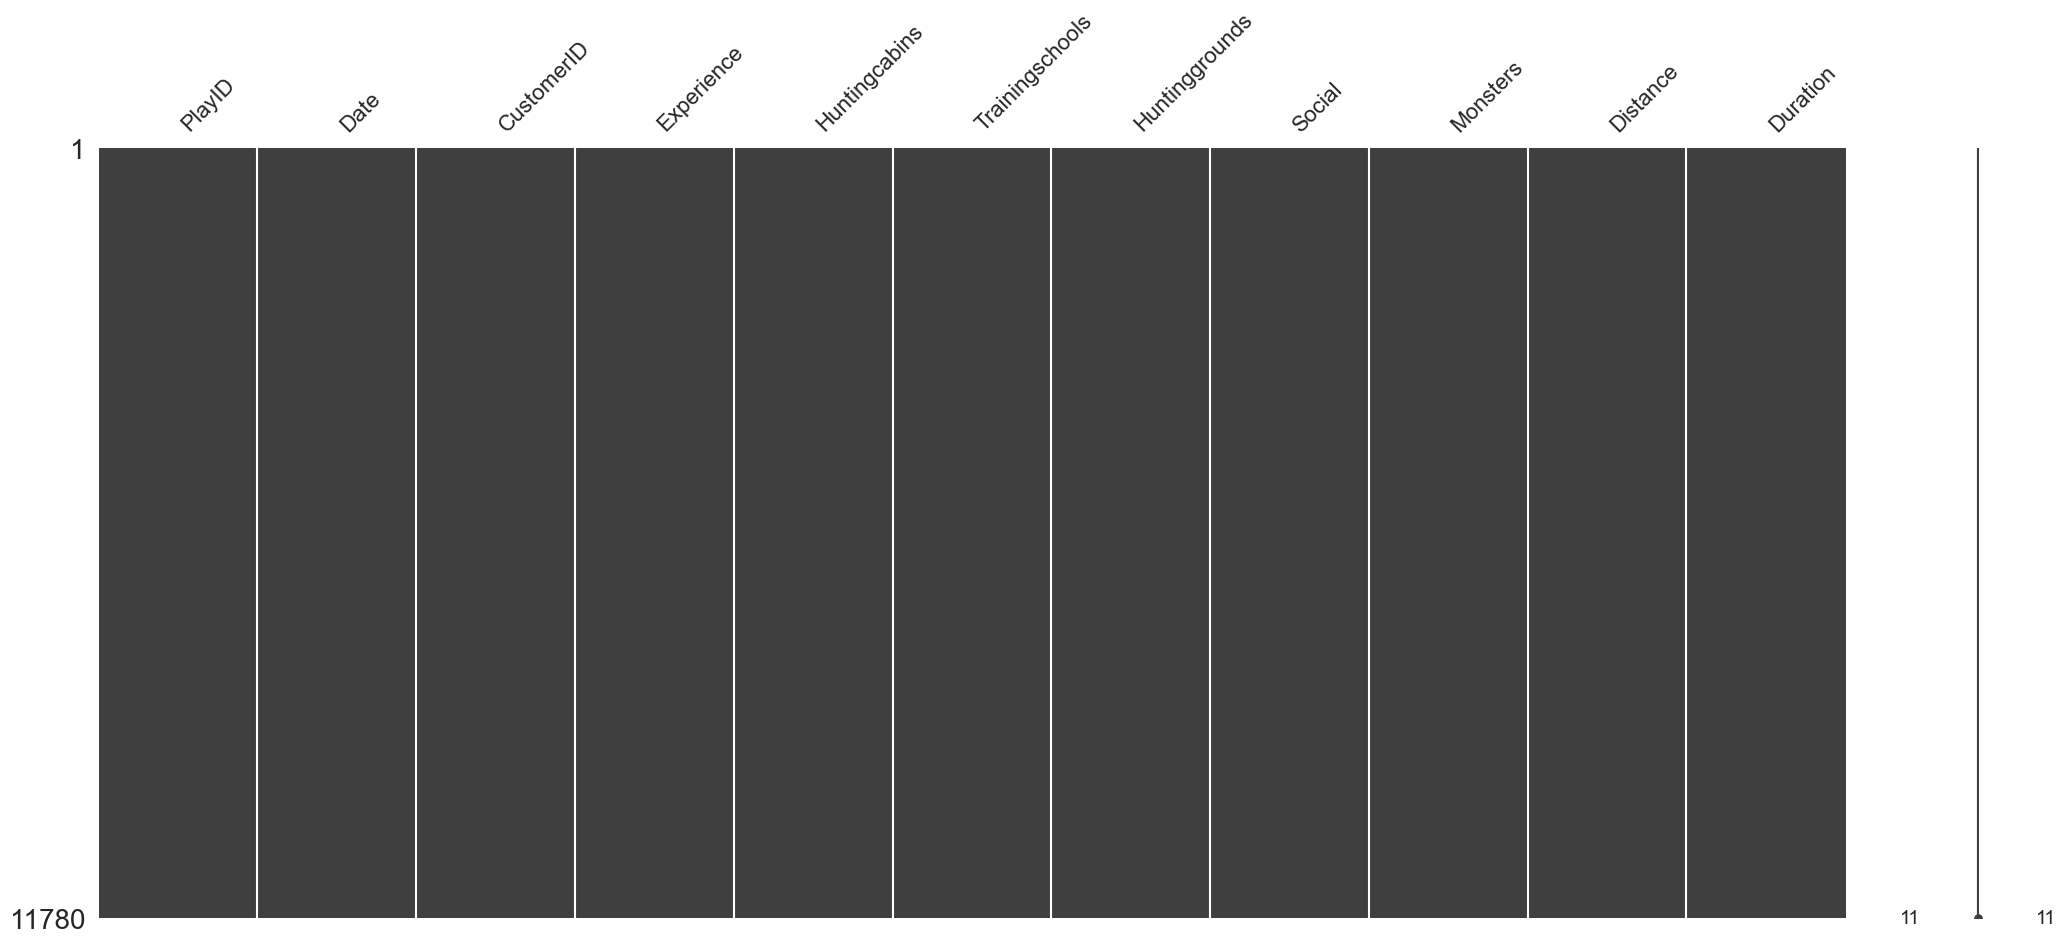

In [95]:
missingno.matrix(fallsesstrx)
plt.show()

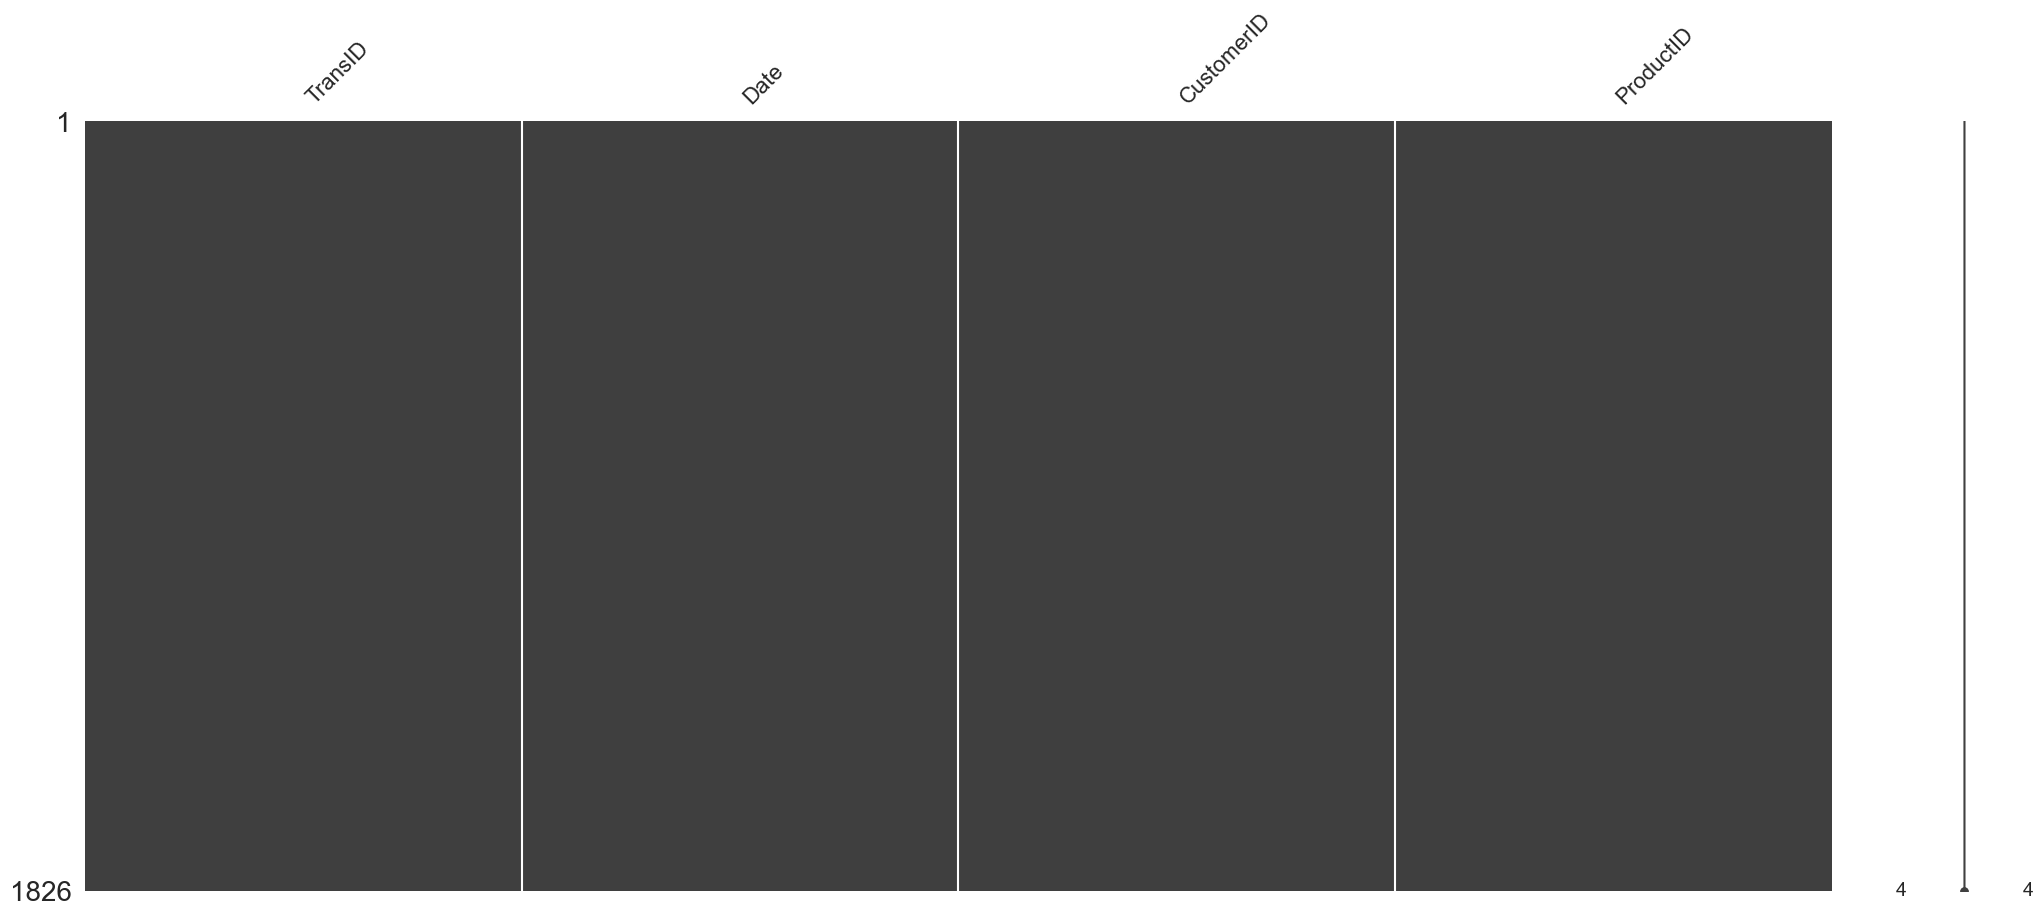

In [96]:
missingno.matrix(fallfintrx)
plt.show()

In [97]:
fallsesstrx = fallsesstrx.groupby('CustomerID', as_index=False).agg(
    PlayID=('PlayID','count'),                  
    date_min=('Date', 'min'),                      # First session date in the summer period
    date_max=('Date', 'max'),                      # last session date in the summer period
    Experience=('Experience', 'sum'),               # Total experience points
    Huntingcabins=('Huntingcabins', 'sum'),            # Total hunting cabins visited
    Trainingschools=('Trainingschools', 'sum'),          # Total training schools visited
    Huntinggrounds=('Huntinggrounds', 'sum'),           # Total hunting grounds visited
    Social=('Social', 'sum'),                   # Total social actions performed
    Monsters=('Monsters', 'sum'),                 # Total monsters caught
    Distance=('Distance', 'sum'),                  # Total distance walked
    Duration=('Duration', 'sum')                   # Total duration of play sessions
)

In [98]:
today=datetime.datetime.strptime('2022-12-31','%Y-%m-%d')    
# Replace ProductID with actual price values
fallfintrx['Amount_spent'] = fallfintrx['ProductID'].replace(product_price_mapping)

fallfintrx = fallfintrx.groupby('CustomerID', as_index=False).agg(
    frequency=('TransID', 'count'),  # Count of transactions per customer
    monetary_value=('Amount_spent', 'sum'),  # Total spending per customer
    recency=('Date', lambda date: (today - date.max()).days),  # Days since last transaction
    first_purchase=('Date', 'min'), # Date of first transaction
    last_purchase=('Date','max'), # Date of last transaction
    T=('Date', lambda x: (today - x.min()).days)
)
fallfintrx

CustomerID  frequency  monetary_value  recency first_purchase  \
0              2          2            7.98        7     2022-09-01   
1              5          1            4.99      121     2022-09-01   
2              9          1            4.99      121     2022-09-01   
3             10          1            2.99      121     2022-09-01   
4             17          1           25.00      121     2022-09-01   
...          ...        ...             ...      ...            ...   
1679        4987          3           17.97        4     2022-12-20   
1680        4988          1            2.99       11     2022-12-20   
1681        4989          1            9.99       11     2022-12-20   
1682        4997          2            7.98        0     2022-12-20   
1683        4998          1            2.99       10     2022-12-21   

     last_purchase    T  
0       2022-12-24  121  
1       2022-09-01  121  
2       2022-09-01  121  
3       2022-09-01  121  
4       2022-09-01  121  
...            ...  ...  
1679    2022-12-27   11  
1680    2022-12-20   11  
1681    2022-12-20   11  
1682    2022-12-31   11  
1683    2022-12-21   10  

[1684 rows x 7 columns]

In [99]:
fallsesstrx

CustomerID  PlayID   date_min   date_max  Experience  Huntingcabins  \
0              1       1 2022-10-18 2022-10-18        4816             16   
1              2       2 2022-09-01 2022-12-28        7562             39   
2              3       2 2022-10-08 2022-10-11        8591             19   
3              4       2 2022-10-24 2022-11-20        7625             35   
4              5       4 2022-09-01 2022-12-30       18001             63   
...          ...     ...        ...        ...         ...            ...   
4496        4996       1 2022-09-28 2022-09-28        4088             23   
4497        4997       4 2022-09-17 2022-10-18       16548             73   
4498        4998       4 2022-09-17 2022-12-18       19261             56   
4499        4999       4 2022-09-20 2022-12-25       22799             46   
4500        5000       1 2022-10-23 2022-10-23        2234             16   

      Trainingschools  Huntinggrounds  Social  Monsters  Distance    Duration  
0                  11               0       0        33  1.661707   17.906645  
1                  12               0       1        41  9.613087  115.751887  
2                   7               2      14        21  3.909540  189.235350  
3                  14               0       1        52  2.754386   38.554075  
4                  27               3       3        98  9.517120  102.270810  
...               ...             ...     ...       ...       ...         ...  
4496                4               0       4        15  5.884704   74.130482  
4497               25               1       4       109  6.480537  122.119685  
4498               31               5       9        53  8.115327  384.034130  
4499               20              12       6        48  8.993887  653.580756  
4500                4               0       0        10  1.338293   68.240329  

[4501 rows x 12 columns]

In [100]:
fallfintrx.describe()

CustomerID    frequency  monetary_value      recency  \
count  1684.000000  1684.000000     1684.000000  1684.000000   
mean   2453.175178     1.084323        9.023207    62.260689   
min       2.000000     1.000000        2.990000     0.000000   
25%    1199.500000     1.000000        2.990000    32.000000   
50%    2424.000000     1.000000        4.990000    62.000000   
75%    3744.250000     1.000000        9.990000    93.000000   
max    4998.000000     3.000000      108.990000   121.000000   
std    1446.355743     0.296570       12.245615    34.885847   

                      first_purchase                  last_purchase  \
count                           1684                           1684   
mean   2022-10-25 02:23:39.477434624  2022-10-29 17:44:36.484560640   
min              2022-09-01 00:00:00            2022-09-01 00:00:00   
25%              2022-09-27 00:00:00            2022-09-29 00:00:00   
50%              2022-10-25 00:00:00            2022-10-30 00:00:00   
75%              2022-11-21 00:00:00            2022-11-29 00:00:00   
max              2022-12-21 00:00:00            2022-12-31 00:00:00   
std                              NaN                            NaN   

                 T  
count  1684.000000  
mean     66.900238  
min      10.000000  
25%      40.000000  
50%      67.000000  
75%      95.000000  
max     121.000000  
std      31.975269

In [101]:
active_fall_customer_data = pd.merge(
    customerdata,
    fallsesstrx[['CustomerID']],
    on='CustomerID',
    how='inner'
)
active_fall_customer_data

CustomerID  CustomerType Registrationdate  Gender  Age  fallbonus  \
0              1             4       2021-09-30       1    8          0   
1              2             4       2022-04-06       1   27          0   
2              3             3       2020-05-24       0    7          0   
3              4             4       2021-09-21       0   11          0   
4              5             4       2021-07-08       1   16          1   
...          ...           ...              ...     ...  ...        ...   
4496        4996             1       2022-03-18       0   42          0   
4497        4997             4       2022-04-02       1   30          1   
4498        4998             3       2022-03-11       1    9          0   
4499        4999             3       2022-04-28       0   30          1   
4500        5000             3       2020-05-28       1   18          0   

      Income  Wave  walkers  socials  grinders  low_income  medium_income  \
0          1     2        0        0         1           1              0   
1          1     3        0        0         1           1              0   
2          2     1        0        1         0           0              1   
3          2     2        0        0         1           0              1   
4          1     2        0        0         1           1              0   
...      ...   ...      ...      ...       ...         ...            ...   
4496       3     3        1        0         0           0              0   
4497       2     3        0        0         1           0              1   
4498       3     3        0        1         0           0              0   
4499       2     3        0        1         0           0              1   
4500       2     1        0        1         0           0              1   

      first_wave  third_wave  
0              0           0  
1              0           1  
2              1           0  
3              0           0  
4              0           0  
...          ...         ...  
4496           0           1  
4497           0           1  
4498           0           1  
4499           0           1  
4500           1           0  

[4501 rows x 15 columns]

In [102]:
fall_fin_sess = fallsesstrx.merge(fallfintrx, on="CustomerID", how="left")
# Fill NaN values with 0
fall_fin_sess.fillna(0, inplace=True)
num_players = fall_fin_sess[(fall_fin_sess['PlayID'] > 0) & (fall_fin_sess['frequency'] == 0)]['CustomerID'].nunique()
num_customers = fall_fin_sess[(fall_fin_sess['PlayID'] > 0) & (fall_fin_sess['frequency'] > 0)]['CustomerID'].nunique()
print(f"Number of customers who played at least once but never made a transaction in the fall: {num_players}")
print(f"Number of customers who played at least once and made at least one transaction in the fall: {num_customers}")

Number of customers who played at least once but never made a transaction in the fall: 2817
Number of customers who played at least once and made at least one transaction in the fall: 1684


In [103]:
summer_customers = set(summerfintrx["CustomerID"])
fall_customers = set(fallfintrx["CustomerID"])
new_fall_customers = fall_customers - summer_customers
totalcustomers=fallfintrx.shape[0]
# Count new customers in fallfintrx
new_fall_customers_count = len(new_fall_customers)
print(f"Percentage of new customers in fallfintrx (not in summerfintrx): {(new_fall_customers_count/totalcustomers)*100:.2f}%")

Percentage of new customers in fallfintrx (not in summerfintrx): 18.76%


In [104]:
paying_users_summer= (summerfintrx.shape[0]/summersesstrx.shape[0])*100
paying_users_fall= (fallfintrx.shape[0]/fallsesstrx.shape[0])*100
print('percentage of paying users in the summer: ',paying_users_summer )
print('percentage of paying users in the fall: ',paying_users_fall )

percentage of paying users in the summer:  36.38103338294705
percentage of paying users in the fall:  37.4139080204399


In [105]:
# Extract unique CustomerIDs from both datasets
session_customers = set(summersesstrx["CustomerID"]) # All players
paying_customers = summer_customers  # Paying players

# Identify free players (in sessions but not in transactions)
free_players_ids = session_customers - paying_customers

# Create a DataFrame for free players
free_players = pd.DataFrame(list(free_players_ids), columns=["CustomerID"])
free_players_converted = free_players["CustomerID"].isin(fallfintrx).sum()
print(f"Number of free players from summer who made a purchase in fall: {free_players_converted}")

Number of free players from summer who made a purchase in fall: 0


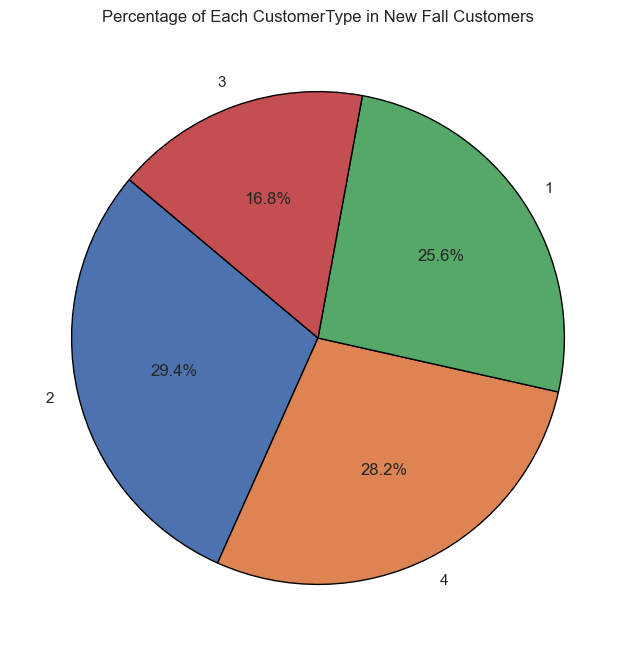

In [106]:
new_fall_customer_data = active_fall_customer_data[active_fall_customer_data["CustomerID"].isin(new_fall_customers)]
customer_type_counts = new_fall_customer_data["CustomerType"].value_counts()
# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(customer_type_counts, labels=customer_type_counts.index, autopct='%1.1f%%', 
        startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Percentage of Each CustomerType in New Fall Customers")
plt.show()

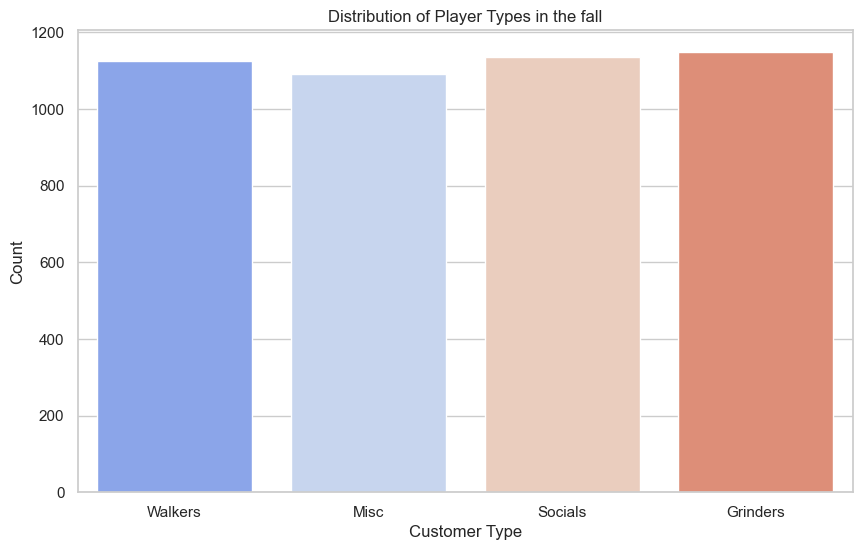

In [107]:
#Customer Type Distribution
plt.figure(figsize=(10,6))
sns.countplot(x='CustomerType', data=active_fall_customer_data, palette='coolwarm')
plt.title('Distribution of Player Types in the fall')
plt.xlabel('Customer Type')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], ['Walkers', 'Misc', 'Socials', 'Grinders'])
plt.show()

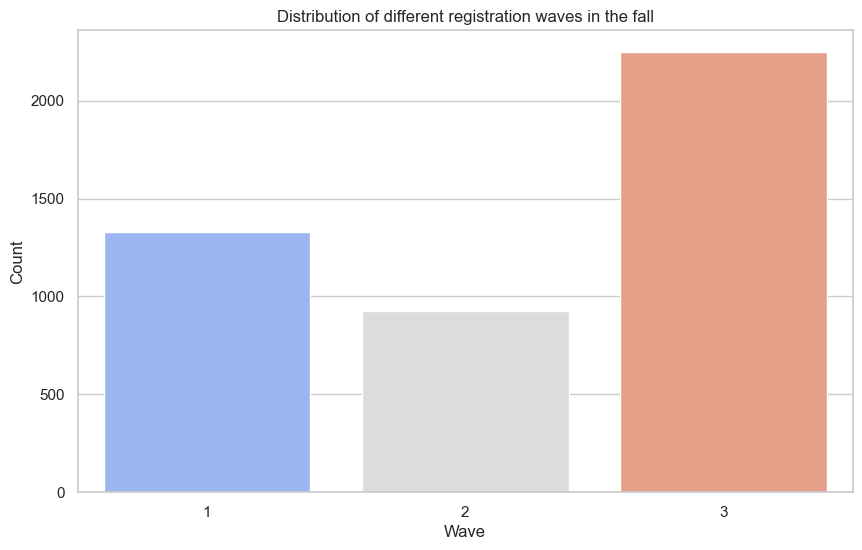

In [108]:
#Customer Type Distribution
plt.figure(figsize=(10,6))
sns.countplot(x='Wave', data=active_fall_customer_data, palette='coolwarm')
plt.title('Distribution of different registration waves in the fall')
plt.xlabel('Wave')
plt.ylabel('Count')
plt.show()

In [109]:
# Identify churners and non-churners
non_churners = summer_customers & fall_customers  # Present in both datasets
churners = summer_customers - fall_customers  # Present in summer but not in fall

# Create the churn dataframe
churn_data = {
    'CustomerID': list(non_churners) + list(churners),
    'Churn_Status': ['non churner'] * len(non_churners) + ['churner'] * len(churners)

    
}

churn_data = pd.DataFrame(churn_data)
churn_data = churn_data.merge(summerfintrx, on="CustomerID", how="left")
churn_data = churn_data.merge(summersesstrx, on="CustomerID", how="left")
churn_data = churn_data.merge(active_summer_customer_data, on="CustomerID", how="left")
churn_data = churn_data.assign(
    Churn=[1 if Churn_Status == 'churner' else 0 for Churn_Status in churn_data['Churn_Status']],
)
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711 entries, 0 to 1710
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        1711 non-null   int64         
 1   Churn_Status      1711 non-null   object        
 2   frequency         1711 non-null   int64         
 3   monetary_value    1711 non-null   float64       
 4   recency           1711 non-null   int64         
 5   first_purchase    1711 non-null   datetime64[ns]
 6   T                 1711 non-null   int64         
 7   PlayID            1711 non-null   int64         
 8   date_min          1711 non-null   datetime64[ns]
 9   Experience        1711 non-null   int64         
 10  Huntingcabins     1711 non-null   int64         
 11  Trainingschools   1711 non-null   int64         
 12  Huntinggrounds    1711 non-null   int64         
 13  Social            1711 non-null   int64         
 14  Monsters          1711 n

## Who churn the most?

In [111]:
# Calculate churn rate
churn_rate = churn_data['Churn'].mean() * 100  
# Print the result
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 20.05%


In [112]:
churn_counts = churn_data["Churn"].value_counts(normalize=True)
print("Churn Rate:\n", churn_counts)

Churn Rate:
 Churn
0    0.799532
1    0.200468
Name: proportion, dtype: float64


In [113]:
df_churned = churn_data[churn_data["Churn"] == 1]

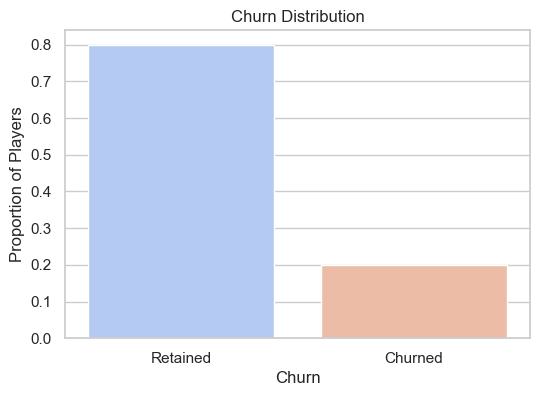

In [114]:
plt.figure(figsize=(6,4))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="coolwarm")
plt.xticks([0,1], ["Retained", "Churned"])
plt.ylabel("Proportion of Players")
plt.title("Churn Distribution")
plt.show()

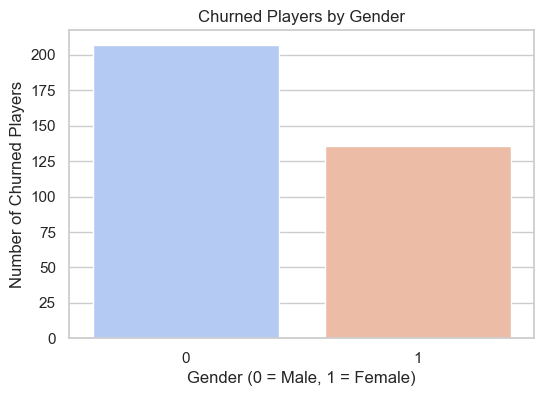

In [115]:
plt.figure(figsize=(6,4))
sns.countplot(x="Gender", data=df_churned, palette="coolwarm")
plt.xlabel("Gender (0 = Male, 1 = Female)")
plt.ylabel("Number of Churned Players")
plt.title("Churned Players by Gender")
plt.show()

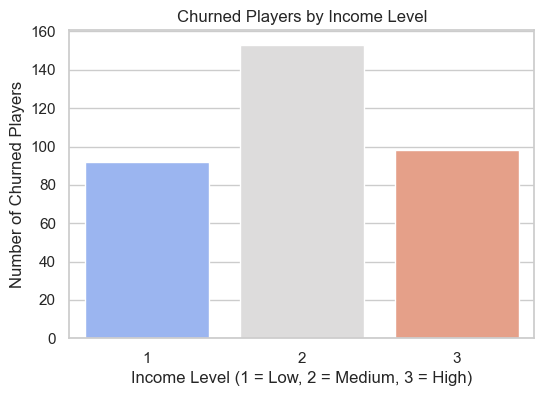

In [116]:
plt.figure(figsize=(6,4))
sns.countplot(x="Income", data=df_churned, palette="coolwarm")
plt.xlabel("Income Level (1 = Low, 2 = Medium, 3 = High)")
plt.ylabel("Number of Churned Players")
plt.title("Churned Players by Income Level")
plt.show()

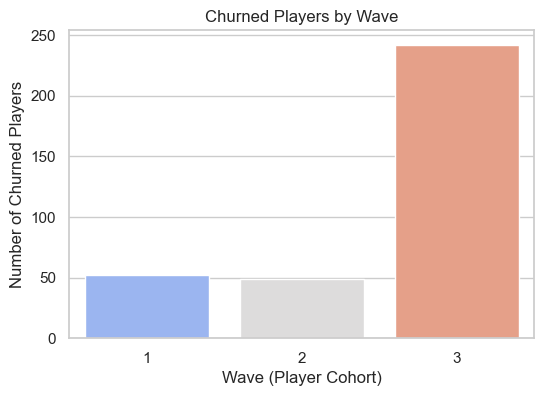

In [117]:
plt.figure(figsize=(6,4))
sns.countplot(x="Wave", data=df_churned, palette="coolwarm")
plt.xlabel("Wave (Player Cohort)")
plt.ylabel("Number of Churned Players")
plt.title("Churned Players by Wave")
plt.show()

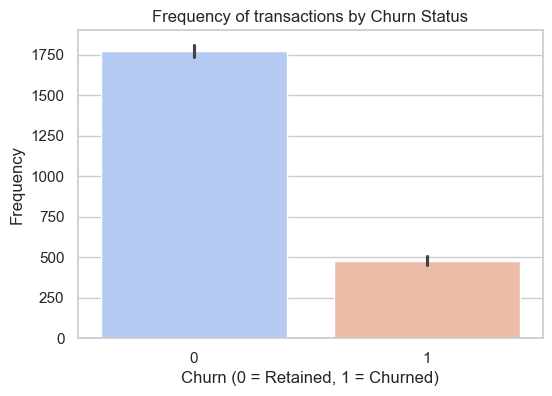

In [118]:
plt.figure(figsize=(6,4))
sns.barplot(x="Churn", y="frequency", data=churn_data, palette="coolwarm", estimator=sum)
plt.xlabel("Churn (0 = Retained, 1 = Churned)")
plt.ylabel("Frequency")
plt.title("Frequency of transactions by Churn Status")
plt.show()

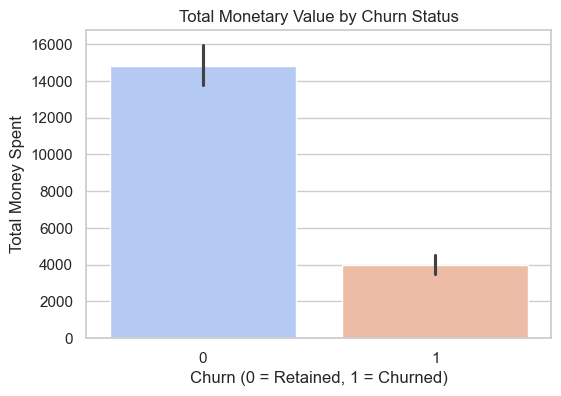

In [119]:
plt.figure(figsize=(6,4))
sns.barplot(x="Churn", y="monetary_value", data=churn_data, palette="coolwarm", estimator=sum)
plt.xlabel("Churn (0 = Retained, 1 = Churned)")
plt.ylabel("Total Money Spent")
plt.title("Total Monetary Value by Churn Status")
plt.show()

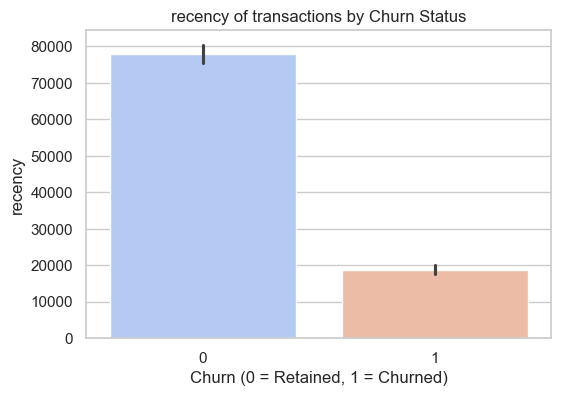

In [120]:
plt.figure(figsize=(6,4))
sns.barplot(x="Churn", y="recency", data=churn_data, palette="coolwarm", estimator=sum)
plt.xlabel("Churn (0 = Retained, 1 = Churned)")
plt.ylabel("recency")
plt.title("recency of transactions by Churn Status")
plt.show()

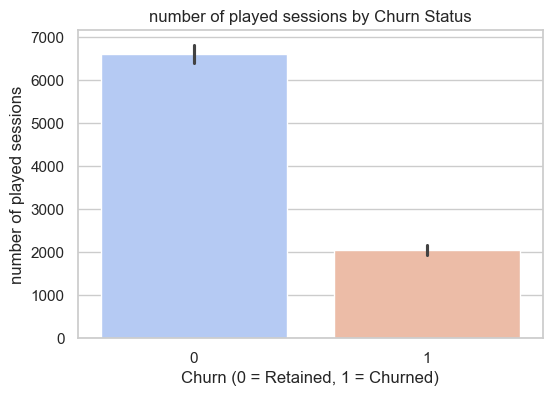

In [121]:
plt.figure(figsize=(6,4))
sns.barplot(x="Churn", y="PlayID", data=churn_data, palette="coolwarm", estimator=sum)
plt.xlabel("Churn (0 = Retained, 1 = Churned)")
plt.ylabel("number of played sessions")
plt.title("number of played sessions by Churn Status")
plt.show()

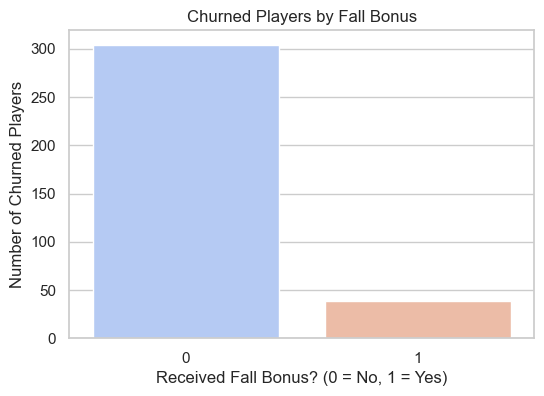

In [122]:
plt.figure(figsize=(6,4))
sns.countplot(x="fallbonus", data=df_churned, palette="coolwarm")
plt.xlabel("Received Fall Bonus? (0 = No, 1 = Yes)")
plt.ylabel("Number of Churned Players")
plt.title("Churned Players by Fall Bonus")
plt.show()

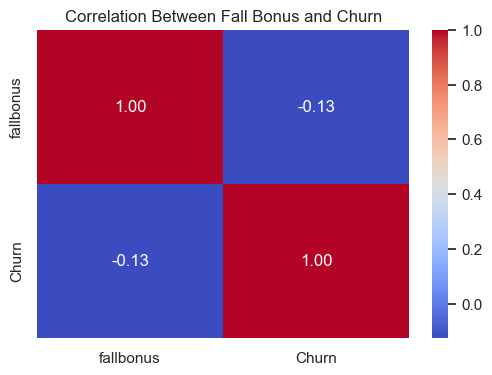

In [123]:
# Compute correlation matrix
corr_matrix = churn_data[["fallbonus", "Churn"]].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Fall Bonus and Churn")
plt.show()

In [124]:
# Group by CustomerType and calculate churn rate
churn_by_type = churn_data.groupby("CustomerType")["Churn"].mean()
# Print churn rates
print(churn_by_type)

CustomerType
1    0.115663
2    0.100000
3    0.425490
4    0.098655
Name: Churn, dtype: float64


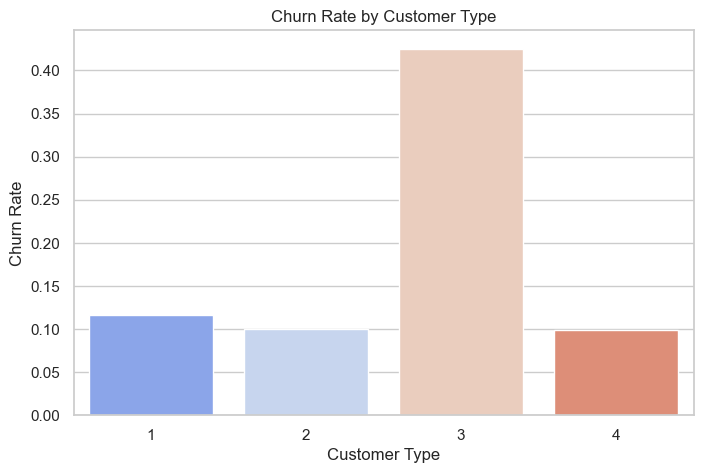

In [125]:
plt.figure(figsize=(8,5))
sns.barplot(x=churn_by_type.index, y=churn_by_type.values, palette="coolwarm")
plt.xlabel("Customer Type")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Customer Type")
plt.show()

## Churn Prediction

In [127]:
churn=churn_data[['walkers','socials','fallbonus','grinders','Age','Gender','Churn','medium_income','frequency','monetary_value','low_income','recency','PlayID','Experience','Huntingcabins','Trainingschools','Huntinggrounds','Social','Monsters','Distance','third_wave','first_wave','Duration']]
churn

walkers  socials  fallbonus  grinders  Age  Gender  Churn  \
0           0        0          1         1   16       1      0   
1           1        0          0         0   34       1      0   
2           1        0          0         0   17       0      0   
3           0        0          0         0   12       1      0   
4           1        0          1         0    9       0      0   
...       ...      ...        ...       ...  ...     ...    ...   
1706        0        1          0         0    7       1      1   
1707        0        1          0         0   27       0      1   
1708        0        1          0         0   49       0      1   
1709        1        0          0         0   34       1      1   
1710        0        1          0         0   40       1      1   

      medium_income  frequency  monetary_value  ...  Experience  \
0                 0          3           19.97  ...        3554   
1                 1          1            4.99  ...       32474   
2                 0          1            4.99  ...       40512   
3                 0          1            4.99  ...       14621   
4                 0          1            2.99  ...       19109   
...             ...        ...             ...  ...         ...   
1706              0          2            7.98  ...       33792   
1707              1          1            4.99  ...       36807   
1708              1          2           27.99  ...       20838   
1709              0          1            2.99  ...       18620   
1710              0          1            9.99  ...       19410   

      Huntingcabins  Trainingschools  Huntinggrounds  Social  Monsters  \
0                16                5               0       1        21   
1               130               71               0       0       136   
2               158               60               0      12       208   
3                56               19               3       3        48   
4                83               36               0       1        76   
...             ...              ...             ...     ...       ...   
1706             95               52               9      19        90   
1707            101               66               9      15       101   
1708             54               33               7       8        51   
1709             95               31               0       0        81   
1710             36               19              10       7        39   

       Distance  third_wave  first_wave     Duration  
0      5.044083           0           0    11.655042  
1     49.734181           0           1   379.162098  
2     78.121554           0           1   513.388091  
3     20.213889           1           0   200.981482  
4     37.586099           1           0   386.341581  
...         ...         ...         ...          ...  
1706  13.424114           1           0   887.866420  
1707  15.058848           1           0  1189.338978  
1708   3.875978           1           0   476.110780  
1709  36.195389           1           0   381.973318  
1710   4.596673           0           0   268.946772  

[1711 rows x 23 columns]

I tried to normalize variables but it did not affect the prediction at all.

In [129]:
#from sklearn.preprocessing import Normalizer
#columns_to_normalize = ['Age', 'Gender', 'frequency', 'monetary_value', 'recency', 
#                     'PlayID', 'Experience', 'Huntingcabins', 'Trainingschools', 
#                        'Huntinggrounds', 'Social', 'Monsters', 'Distance', 'Duration']
#scaler = Normalizer()
#normalized_values = scaler.fit_transform(churn[columns_to_normalize])

#normalized_df = pd.DataFrame(normalized_values, columns=columns_to_normalize, index=churn.index)

#churn = churn.drop(columns=columns_to_normalize).join(normalized_df)
#churn

In [130]:
train, test = train_test_split(churn, test_size=0.3,random_state=1)

In [131]:
#is this a balanced dataset?
print('percentage churn in train dataset: ',np.round(np.mean(train['Churn'])*100,2))
print('percentage churn in test dataset: ',np.round(np.mean(test['Churn'])*100,2))

percentage churn in train dataset:  19.05
percentage churn in test dataset:  22.37


No, this dataset is imbalanced because one class (non-churners) is significantly more frequent than the other.
We could do an oversampling, however it would reduce our dataset too much

In [133]:
# Apply SMOTE to balance the dataset
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
#print("Class distribution after SMOTE:")
#print(pd.Series(y_train_resampled).value_counts())

<Axes: >

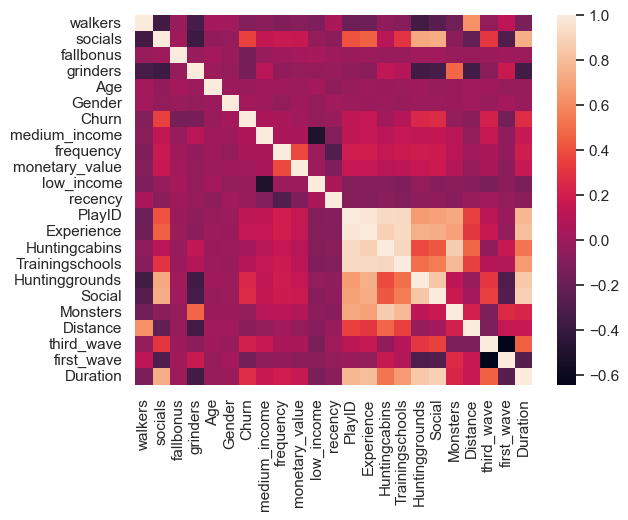

In [134]:
corrmatrixtrain=train.corr()
corrmatrixtest=test.corr()
sns.heatmap(train.corr())

What are the most correlated variables?
- PlayID and Experience 

They seem highly correlated (close to 1). Since both likely measure engagement, keep one (e.g., Experience if it's a better overall indicator).

- Huntingcabins, Trainingschools, Huntinggrounds, Social, Monsters

These appear to be strongly correlated with each other.
- Distance and Duration

Strong correlation suggests that players who play longer also travel more. You might drop one (e.g., keep Duration if it’s more indicative of engagement).

Frequency and Monetary_Value
These are closely correlated, meaning players who make more transactions also spend more. Keep one (monetary_value might be more informative).

In [136]:
logit_mod = smf.logit(formula='Churn ~ walkers+socials+grinders+Gender+Age+monetary_value+recency+Experience+Duration+fallbonus+first_wave+third_wave', data=train)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.409389
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 1197
Model:                          Logit   Df Residuals:                     1184
Method:                           MLE   Df Model:                           12
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                  0.1592
Time:                        16:29:47   Log-Likelihood:                -490.04
converged:                       True   LL-Null:                       -582.83
Covariance Type:            nonrobust   LLR p-value:                 3.029e-33
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3946      0.413     -5.796      0.000      -3.204      -1.585
walkers          

In [137]:
def forwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    

    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    

    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    

    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __forwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)
    
def backwardSelection(X, y, model_type ="linear",elimination_criteria = "aic", varchar_process = "dummy_dropfirst", sl=0.05):
    """
    Backward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    sl : Significance Level (default: 0.05)\n
    

    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    

    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    

    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression    
    """
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __backwardSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , sl=sl)

def __varcharProcessing__(X, varchar_process = "dummy_dropfirst"):
    
    dtypes = X.dtypes
    if varchar_process == "drop":   
        X = X.drop(columns = dtypes[dtypes == object].index.tolist())
        print("Character Variables (Dropped):", dtypes[dtypes == object].index.tolist())
    elif varchar_process == "dummy":
        X = pd.get_dummies(X,drop_first=False,dtype=int)
        print("Character Variables (Dummies Generated):", dtypes[dtypes == object].index.tolist())
    elif varchar_process == "dummy_dropfirst":
        X = pd.get_dummies(X,drop_first=True,dtype=int)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == object].index.tolist())
    else: 
        X = pd.get_dummies(X,drop_first=True,dtype=int)
        print("Character Variables (Dummies Generated, First Dummies Dropped):", dtypes[dtypes == object].index.tolist())
    
    X["intercept"] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]
    
    return X

def __forwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals=pd.concat([pvals,pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"])],ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<=sl]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    
        
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
                
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)

    return selected_cols, iterations_log,model

def __backwardSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", sl=0.05):
    
    iterations_log = ""
    last_eleminated = ""    
    cols = X.columns.tolist()

    def regressor(y,X, model_type=model_type):
        if model_type =="linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    for i in range(X.shape[1]):
        if i != 0 :          
            if elimination_criteria == "aic":
                criteria = model.aic
                new_model = regressor(y,X)
                new_criteria = new_model.aic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "bic":
                criteria = model.bic
                new_model = regressor(y,X)
                new_criteria = new_model.bic
                if criteria < new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "adjr2" and model_type =="linear":
                criteria = model.rsquared_adj
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared_adj
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break  
            elif elimination_criteria == "r2" and model_type =="linear":
                criteria = model.rsquared
                new_model = regressor(y,X)
                new_criteria = new_model.rsquared
                if criteria > new_criteria:
                    print("Regained : ", last_eleminated)
                    iterations_log += "\n"+str(new_model.summary())+"\nAIC: "+ str(new_model.aic) + "\nBIC: "+ str(new_model.bic)+"\n"
                    iterations_log += str("\n\nRegained : "+last_eleminated + "\n\n")
                    break   
            else: 
                new_model = regressor(y,X)
            model = new_model
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        else:
            model = regressor(y,X)
            iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
        maxPval = max(model.pvalues)
        cols = X.columns.tolist()
        if maxPval > sl:
            for j in cols:
                if (model.pvalues[j] == maxPval):
                    print("Eliminated :" ,j)
                    iterations_log += str("\n\nEliminated : "+j+ "\n\n")
                    
                    del X[j]
                    last_eleminated = j
        else:
            break
    print("Final Variables:", cols)
    iterations_log += "\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n"
    return cols, iterations_log,model

#Copyright 2019 Emirhan Kartal
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and
#limitations under the License.

def BidirectionalStepwiseSelection(X, y, model_type ="linear", elimination_criteria = "aic", varchar_process = "dummy_dropfirst", senter=0.05, sstay=0.05):
    
    """
    Forward Selection is a function, based on regression models, that returns significant features and selection iterations.\n
    Required Libraries: pandas, numpy, statmodels
    
    Parameters
    ----------
    X : Independent variables (Pandas Dataframe)\n
    y : Dependent variable (Pandas Series, Pandas Dataframe)\n
    model_type : 'linear' or 'logistic'\n
    elimination_criteria : 'aic', 'bic', 'r2', 'adjr2' or None\n
        'aic' refers Akaike information criterion\n
        'bic' refers Bayesian information criterion\n
        'r2' refers R-squared (Only works on linear model type)\n
        'r2' refers Adjusted R-squared (Only works on linear model type)\n
    varchar_process : 'drop', 'dummy' or 'dummy_dropfirst'\n
        'drop' drops varchar features\n
        'dummy' creates dummies for all levels of all varchars\n
        'dummy_dropfirst' creates dummies for all levels of all varchars, and drops first levels\n
    senter : Significance Level to be Selected in Forward Selection (default: 0.05)\n
    sstay : Significance Level to be Stayed in Backward Elimination (default: 0.05)\n
  
    Returns
    -------
    columns(list), iteration_logs(str)\n\n
    Not Returns a Model
    
    Tested On
    ---------
    Python v3.6.7, Pandas v0.23.4, Numpy v1.15.04, StatModels v0.9.0
    
    See Also
    --------
    https://en.wikipedia.org/wiki/Stepwise_regression
    """  
    
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    return __stepwiseSelectionRaw__(X, y, model_type = model_type,elimination_criteria = elimination_criteria , senter = senter, sstay = sstay)

def __stepwiseSelectionRaw__(X, y, model_type ="linear",elimination_criteria = "aic", senter=0.05, sstay=0.05):

    iterations_log = ""
    cols = X.columns.tolist()
    
    def regressor(y,X, model_type=model_type):
        if model_type == "linear":
            regressor = sm.OLS(y, X).fit()
        elif model_type == "logistic":
            regressor = sm.Logit(y, X).fit()
        else:
            print("\nWrong Model Type : "+ model_type +"\nLinear model type is seleted.")
            model_type = "linear"
            regressor = sm.OLS(y, X).fit()
        return regressor
    
    selected_cols = ["intercept"]
    other_cols = cols.copy()
    other_cols.remove("intercept")
    
    model = regressor(y, X[selected_cols])
    
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    
    for i in range(X.shape[1]):
        pvals = pd.DataFrame(columns = ["Cols","Pval"])
        for j in other_cols:
            model = regressor(y, X[selected_cols+[j]])
            pvals=pd.concat([pvals,pd.DataFrame([[j, model.pvalues[j]]],columns = ["Cols","Pval"])],ignore_index=True)
        pvals = pvals.sort_values(by = ["Pval"]).reset_index(drop=True)
        pvals = pvals[pvals.Pval<= senter]
        if pvals.shape[0] > 0:
            
            model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
            iterations_log += "\n" + str(i+1) + ". iteration"
            iterations_log += str("\nEntered : "+pvals["Cols"][0] + "\n")    
            iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"
                    

            for k in range(X[selected_cols+[pvals["Cols"][0]]].shape[1]):
                
                cols_backward = X[selected_cols+[pvals["Cols"][0]]].columns.tolist()
                pvals_backward = pd.DataFrame(columns = ["bw_Cols","bw_Pval"])

 
                for l in cols_backward:
                    pvals_backward = pd.concat([pvals_backward,pd.DataFrame([[l, model.pvalues[l]]],columns= ["bw_Cols","bw_Pval"])],ignore_index=True)
                    
                pvals_backward = pvals_backward.sort_values(by = ["bw_Pval"]).reset_index(drop=True)
                pvals_backward_drop = pvals_backward[pvals_backward.bw_Pval > sstay].reset_index(drop=True)

                if pvals_backward_drop.shape[0] > 0:
                    
                    
                    iterations_log += str("\nBackward Step Dropped : "+pvals_backward_drop["bw_Cols"][0] + "\n") 
                        
                    if pvals_backward_drop["bw_Cols"][0] in other_cols:
                        other_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                    
                    if pvals_backward_drop["bw_Cols"][0] in selected_cols:
                        selected_cols.remove(pvals_backward_drop["bw_Cols"][0])
                    else:
                        pass    
                           
                    model = regressor(y, X[selected_cols+[pvals["Cols"][0]]])
                    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"     
        
           
                else:
                    print("break : No need to Backward Elimination")
                    break
            
            
            if  elimination_criteria == "aic":
                new_criteria = model.aic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tAIC :", model.aic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break
            elif  elimination_criteria == "bic":
                new_criteria = model.bic
                if new_criteria < criteria:
                    print("Entered :", pvals["Cols"][0], "\tBIC :", model.bic)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break        
            elif  elimination_criteria == "r2" and model_type =="linear":
                new_criteria = model.rsquared
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tR2 :", model.rsquared)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("break : Criteria")
                    break           
            elif  elimination_criteria == "adjr2" and model_type =="linear":
                new_criteria = model.rsquared_adj
                if new_criteria > criteria:
                    print("Entered :", pvals["Cols"][0], "\tAdjR2 :", model.rsquared_adj)
                    selected_cols.append(pvals["Cols"][0])
                    other_cols.remove(pvals["Cols"][0])
                    criteria = new_criteria
                else:
                    print("Break : Criteria")
                    break
            else:
                print("Entered :", pvals["Cols"][0])
                selected_cols.append(pvals["Cols"][0])
                other_cols.remove(pvals["Cols"][0])            
            
        else:
            print("Break : Significance Level")
            break
        
    model = regressor(y, X[selected_cols])
    if elimination_criteria == "aic":
        criteria = model.aic
    elif elimination_criteria == "bic":
        criteria = model.bic
    elif elimination_criteria == "r2" and model_type =="linear":
        criteria = model.rsquared
    elif elimination_criteria == "adjr2" and model_type =="linear":
        criteria = model.rsquared_adj
    
    print(model.summary())
    print("AIC: "+str(model.aic))
    print("BIC: "+str(model.bic))
    print("Final Variables:", selected_cols)
    

    iterations_log += "\nFinal Selection and Model Statistics\n"
    
    for m in range(len(selected_cols)):
        iterations_log += "\n" + str(m+1) + str(". Final Variable :  "+ selected_cols[m]) 
           
    iterations_log += "\n\n"+str(model.summary())+"\nAIC: "+ str(model.aic) + "\nBIC: "+ str(model.bic)+"\n\n"


    return selected_cols, iterations_log,model


def prediction_stepwise(X,model,varchar_process = "dummy_dropfirst"):
    X = __varcharProcessing__(X,varchar_process = varchar_process)
    Xpred=X[np.intersect1d(X.columns,model[0])]#only select var retained from model
    Xpred=Xpred.reindex(columns=model[0])#sort them according to the sequence used in the model
    p=model[2].predict(Xpred)
    return p

In [138]:
X = train[['frequency','walkers','socials','grinders','Gender','Age','Experience','fallbonus','monetary_value','recency','Duration','first_wave','third_wave']]
Y = train['Churn']
bidirectional=BidirectionalStepwiseSelection(X,Y,model_type="logistic",elimination_criteria = "aic", varchar_process = "dummy_dropfirst",senter=0.05, sstay=0.05)
bidirectional[2].summary()

Character Variables (Dummies Generated, First Dummies Dropped): []
Optimization terminated successfully.
         Current function value: 0.486913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.476105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474055
         Iterations 6
Optimization te

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 1197
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                  0.1540
Time:                        16:29:48   Log-Likelihood:                -493.09
converged:                       True   LL-Null:                       -582.83
Covariance Type:            nonrobust   LLR p-value:                 1.132e-38
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.2540      0.145    -15.586      0.000      -2.537      -1.971
socials        1.5980      0.167      9.570      0.000       1.271       1.925
fallbonus     -1.3198      0.248     -5.316      0.000      -1.806      -0.833
third_wave     0.7042      0.172      4.083      0.000       0.366       1.042
==============================================================================
"""

In [139]:
Xtrain=train[np.intersect1d(train.columns,bidirectional[0])]#only select var retained from backbward selection
Xtrain=Xtrain.reindex(columns=bidirectional[0])#sort them according to the sequence used in the regression
Xtrain['intercept']=1#add constant variable
train['predict']=bidirectional[2].predict(Xtrain)#store prediction in corresponding dataset
Xtest=test[np.intersect1d(test.columns,bidirectional[0])]#only select var retained from backbward selection
Xtest=Xtest.reindex(columns=bidirectional[0])#sort them according to the sequence used in the regression
Xtest['intercept']=1#add constant variable
test['predict']=bidirectional[2].predict(Xtest)#store prediction in corresponding dataset
test

walkers  socials  fallbonus  grinders  Age  Gender  Churn  \
111         1        0          0         0   31       0      0   
126         1        0          0         0   28       1      0   
553         0        0          0         1   28       0      0   
885         0        0          0         1   33       1      0   
977         1        0          1         0    8       1      0   
...       ...      ...        ...       ...  ...     ...    ...   
1688        0        1          0         0   34       1      1   
698         1        0          0         0   28       0      0   
1463        0        1          1         0   23       0      1   
1007        0        0          0         0   44       0      0   
1181        0        0          0         0   31       1      0   

      medium_income  frequency  monetary_value  ...  Huntingcabins  \
111               1          1            2.99  ...            175   
126               1          1            2.99  ...            165   
553               0          1            2.99  ...            108   
885               1          2            7.98  ...             35   
977               1          1            4.99  ...             55   
...             ...        ...             ...  ...            ...   
1688              0          1           25.00  ...            105   
698               0          1            2.99  ...             96   
1463              1          1            2.99  ...            100   
1007              0          2            9.98  ...             30   
1181              0          1            4.99  ...             18   

      Trainingschools  Huntinggrounds  Social  Monsters   Distance  \
111                89               0       7       175  90.523796   
126                89               0       6       160  59.385424   
553                49               2       1       234   9.638096   
885                21               0       2        69   5.186339   
977                23               0       4        49  17.344281   
...               ...             ...     ...       ...        ...   
1688               53              15      13       113  14.307858   
698                54               0       2       101  47.804047   
1463               65              22      13        66  15.248495   
1007                8               2       1        30   5.689793   
1181                5               4       0        26   3.727566   

      third_wave  first_wave    Duration   predict  
111            0           1  597.480549  0.095007  
126            0           1  521.869721  0.095007  
553            0           1  139.240154  0.095007  
885            1           0   53.078581  0.175112  
977            0           0  141.004724  0.027283  
...          ...         ...         ...       ...  
1688           1           0  931.197953  0.512049  
698            0           1  301.416840  0.095007  
1463           1           0  868.346807  0.218977  
1007           0           0   41.155850  0.095007  
1181           1           0   55.640783  0.175112  

[514 rows x 24 columns]

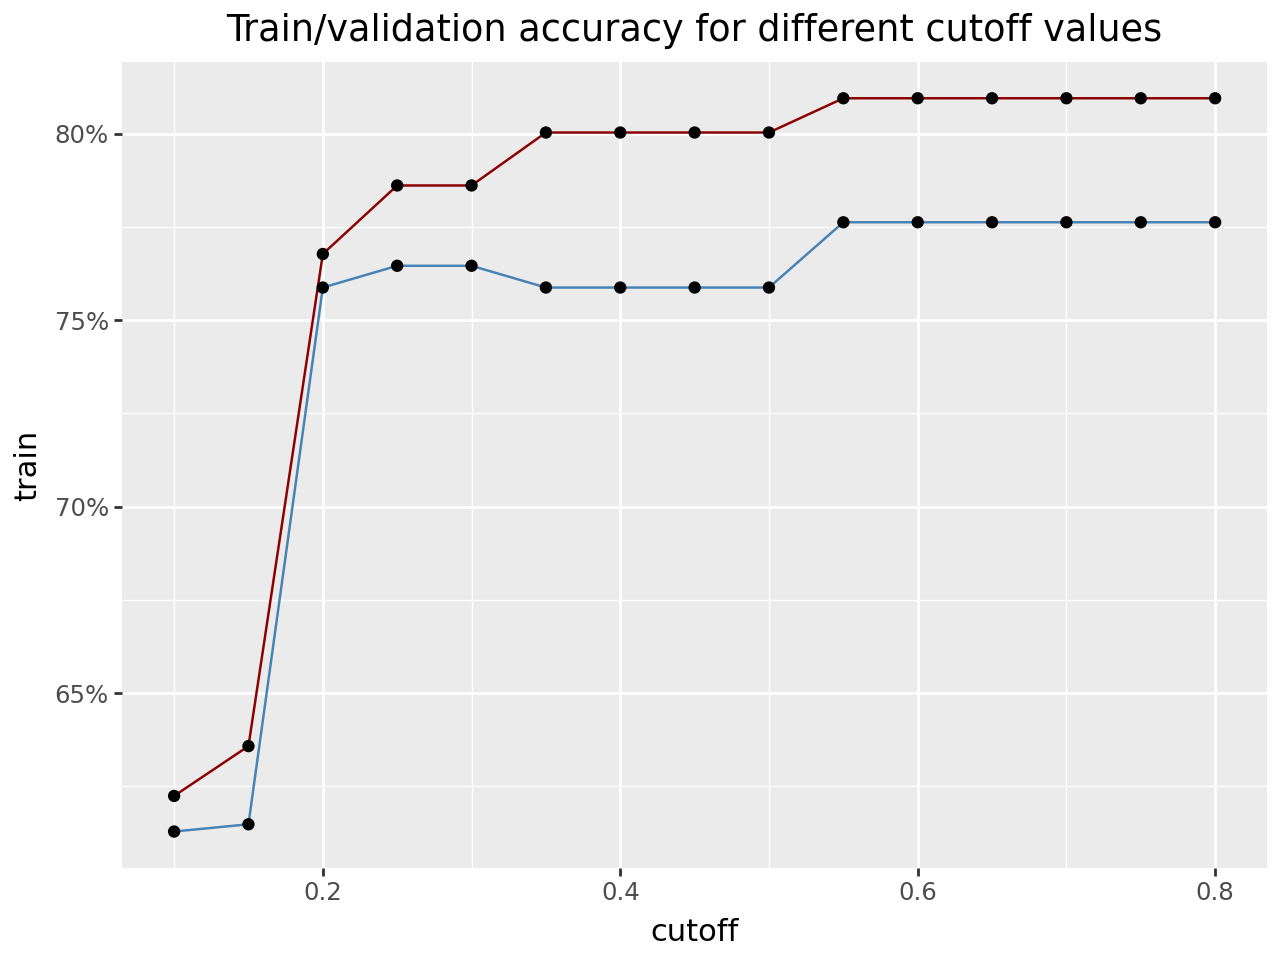

In [140]:
def AccuracyCutoffInfo(training,validation,depvar='Churn',pred='predict'):
    # change the cutoff value's range as you please
    cutoff=np.arange(0.1, 0.85, 0.05)
    cm_train=[0]*len(cutoff)
    cm_validation=[0]*len(cutoff)
    for i in range(0,len(cutoff)):  
        cm_train[i]=accuracy_score(training[depvar], training[pred]>cutoff[i])
        cm_validation[i]=accuracy_score(validation[depvar], validation[pred]>cutoff[i])
    accuracytable=pd.concat([pd.Series(cutoff).rename('cutoff'),pd.Series(cm_train).rename('train'),pd.Series(cm_validation).rename('validation')],axis=1)    
    accplot=(pn.ggplot(accuracytable, pn.aes(x='cutoff')) + 
    pn.geom_line( pn.aes(y = 'train'), color = "darkred")+
    pn.geom_line( pn.aes(y = 'validation'), color = "steelblue")+
    pn.geom_point(pn.aes(y = 'train'))+
    pn.geom_point(pn.aes(y = 'validation'))+
    pn.scale_y_continuous( labels=percent_format() ) +
    pn.ggtitle( "Train/validation accuracy for different cutoff values" ))
    accplot.show()
  
AccuracyCutoffInfo(train,test,depvar='Churn',pred='predict')

Estimation False Positive Cost:
Discount Value: Assuming an average in-game purchase (microtransaction) is approximately 87 dollars per player annually. 
(https://en.wikipedia.org/wiki/Free-to-play?utm_source=chatgpt.com)
 Offering a 10% discount would equate to dollars 8.70 per player.
Opportunity Cost: If the average revenue per user (ARPU) is dollars 90.16 annually, and offering unnecessary discounts reduces perceived game value, leading to a 10% drop in future spending, the opportunity cost would be dollars 9.02 per player. 
(https://scoop.market.us/gaming-monetization-statistics/?utm_source=chatgpt.com)
Retention Incentive Cost: In-Game Rewards: 1.00, ersonalized Discounts: 8.70, Communication Efforts: 0.30, Exclusive Content Development: 2.00, Community Management: 1.00
Total False Positive Cost: 8.70 (discount) + 9.02 (opportunity cost)+ 13 (Retention Incentive Cost) = 30 dollars per player.


Estimation of False Negative Cost :
Lost Revenue: With an ARPU of 90.16 dollars annually and an average player lifespan of 1 year, the CLV is 90.16 dollars. 
(https://scoop.market.us/gaming-monetization-statistics/?utm_source=chatgpt.com)
Acquisition Cost: The average cost per install (CPI) for mobile games is approximately 4.7 dollars on iOS and 3.4 dollars on Android. 
(https://www.businessofapps.com/marketplace/user-acquisition/research/user-acquisition-costs/?utm_source=chatgpt.com)
 Assuming a 50/50 user split between platforms, the average CPI would be 4.05 dollars.
Total False Negative Cost: 90.16 (lost revenue) + 4.05 (acquisition cost) = 94.21 dollars per player.


The false negative cost ($94.21) is significantly higher than the false positive cost (17.72).
Prioritize minimizing false negatives to retain high-value players, as the cost of losing a player far outweighs the cost of offering unnecessary discounts.

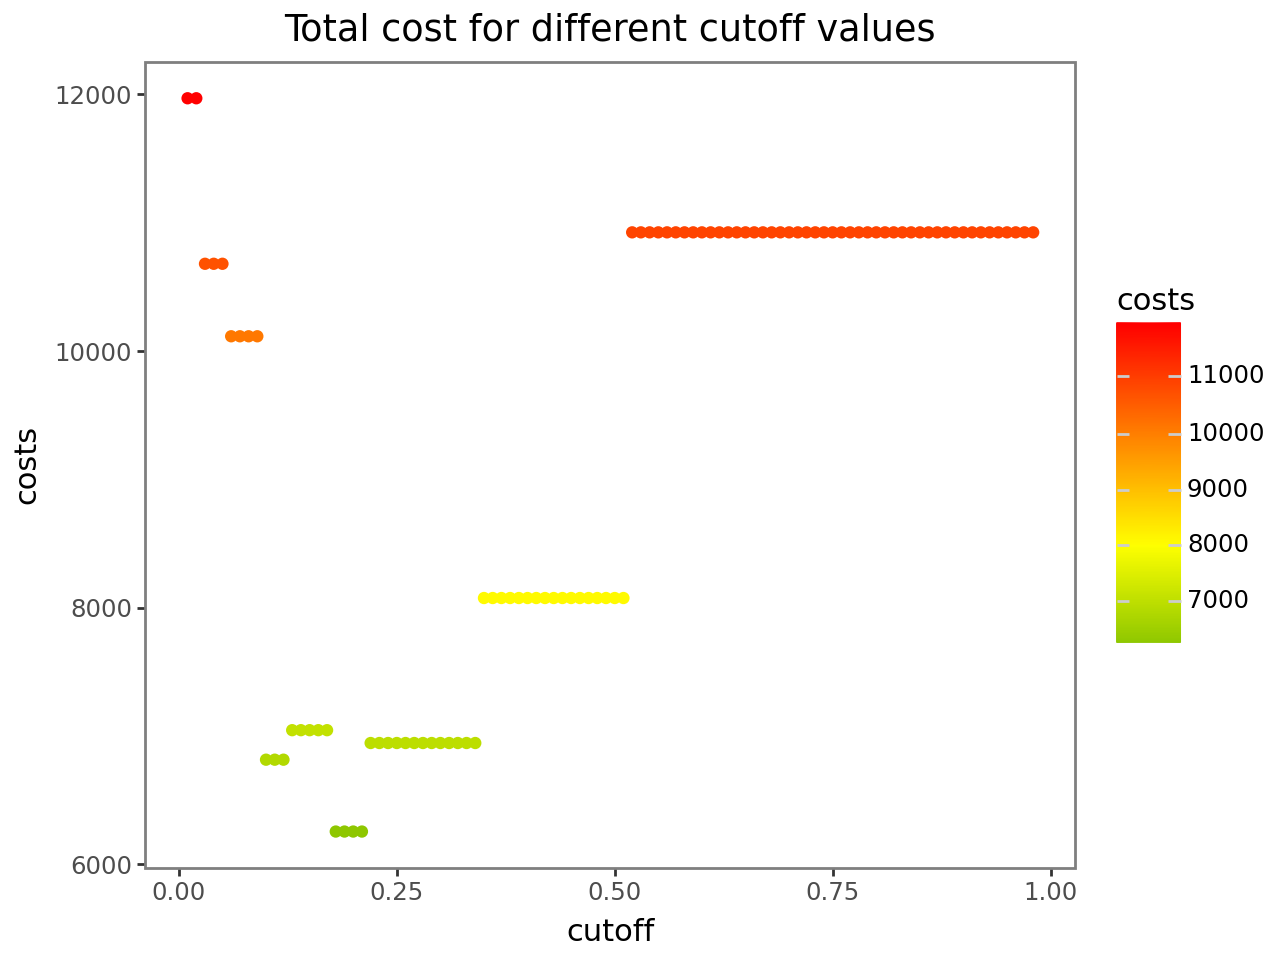

the cutoff that lead to the lowest value is:  0.18000000000000002


In [142]:
#find the cutoff that leads to the lowest costs
def findoptcutoff(depvar,pred):
    cutoff=np.arange(0.01, 0.99, 0.01)
    cost_fp=30 #providing a discount to a non churner
    cost_fn=95  #not identifying a churner and missing out on his clv
    costs=[0]*len(cutoff)
    bestcost=sys.maxsize
    bestindex=0 
    for i in range(0,len(cutoff)): 
        cm_df = pd.DataFrame(confusion_matrix(depvar,pred>cutoff[i]))
        am_fp=cm_df[1][0]
        am_fn=cm_df[0][1]
        costs[i]=am_fp*cost_fp+am_fn*cost_fn
        if(costs[i]<bestcost):
            bestcost=costs[i]
            bestindex=i       
    cutofftable=pd.concat([pd.Series(cutoff).rename('cutoff'),pd.Series(costs).rename('costs')],axis=1)
    cutoffchart=(pn.ggplot(cutofftable, pn.aes(x = 'cutoff', y = 'costs',color='costs'))+
       pn.theme_bw() +
       pn.theme(panel_grid = pn.element_blank())+
       pn.geom_point()+
       pn.scale_colour_gradient2(low = "green", high = "red", mid = "yellow",midpoint=8000)+
      pn. ggtitle("Total cost for different cutoff values"))
    cutoffchart.show()
    print('the cutoff that lead to the lowest value is: ', cutoff[bestindex])
    return cutoff[bestindex]

optcutoff=findoptcutoff(test['Churn'],test['predict']) #THE OPTIMAL CUTOFF

Any player with a churn probability ≥ 0.1 is classified as a churner.

The model is very sensitive to churners → It flags players as potential churners even with a low probability.
We're prioritizing recall (catching all churners) over precision.
False positives will increase → More non-churners might get discounts unnecessarily.
False negatives will decrease → Fewer actual churners will be missed.

### Now Let's evaluate the model

In [145]:
def evaluate_model(actual, pred,cutoff=0.5):
    #confusion matrix
    cm_df = pd.DataFrame(confusion_matrix(actual,pred>cutoff))
    cm_df.columns = ['Predicted 0', 'Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    print("Cutoff used: ",cutoff)
    print(cm_df)
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred>cutoff)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred>cutoff)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    sens_score = round(recall_score(actual, pred>cutoff)*100,2)#recall=sensitivity
    print('sensitivity score : ', sens_score)
    tn, fp, fn, tp = confusion_matrix(actual,pred>cutoff).ravel()
    spec_score = round((tn / (tn + fp))*100,2)
    print('specificity score : ', spec_score)
    # Log-Likelihood (MLE Calculation)
    epsilon = 1e-9  # Avoid log(0) errors
    log_likelihood = np.sum(actual * np.log(pred + epsilon) + (1 - actual) * np.log(1 - pred + epsilon))
    print('Log-Likelihood (MLE) :', round(log_likelihood, 4))
    #plot auc curve
    fpr, tpr, _ = roc_curve(actual,pred)
    auc = roc_auc_score(actual,pred)
    roccurve=(pn.ggplot(pn.aes(x=fpr,y=tpr))+
                 pn.geom_line(color='red')+
                 pn.scale_y_continuous(name='sensitivity,true positive rate' ) +
                 pn.scale_x_continuous(name='1-specificity, false positive rate' ) +
                 pn.ggtitle('Roc curve: '+str(np.round(auc,2))))
    print(roccurve)
    return acc_score, roc_score, prec_score, sens_score, spec_score, log_likelihood
    

performance=evaluate_model(test['Churn'],test['predict'],cutoff=optcutoff)

Cutoff used:  0.18000000000000002
          Predicted 0  Predicted 1
Actual 0          314           85
Actual 1           39           76
Accuracy Score :  75.88
ROC AUC score :  77.25
Precision score :  47.2
sensitivity score :  66.09
specificity score :  78.7
Log-Likelihood (MLE) : -231.8103
<ggplot: (640 x 480)>


Accuracy	75.88%	The model correctly classifies churners and non-churners 76% of the time.
ROC AUC	77.25%	The model has good predictive power, meaning it effectively distinguishes between churners and non-churners.
Precision	47.2%	Moderate precision, meaning 47.2% of players predicted as churners actually churn.
Sensitivity (Recall)	66.09%	The model identifies 66% of actual churners, meaning some churners are missed.
Specificity	78.7%	The model correctly classifies 78.7% of non-churners, reducing unnecessary retention efforts.
Log-likelihood  -231.8103 The model is reasonably fitting the data, but there's room for improvement.

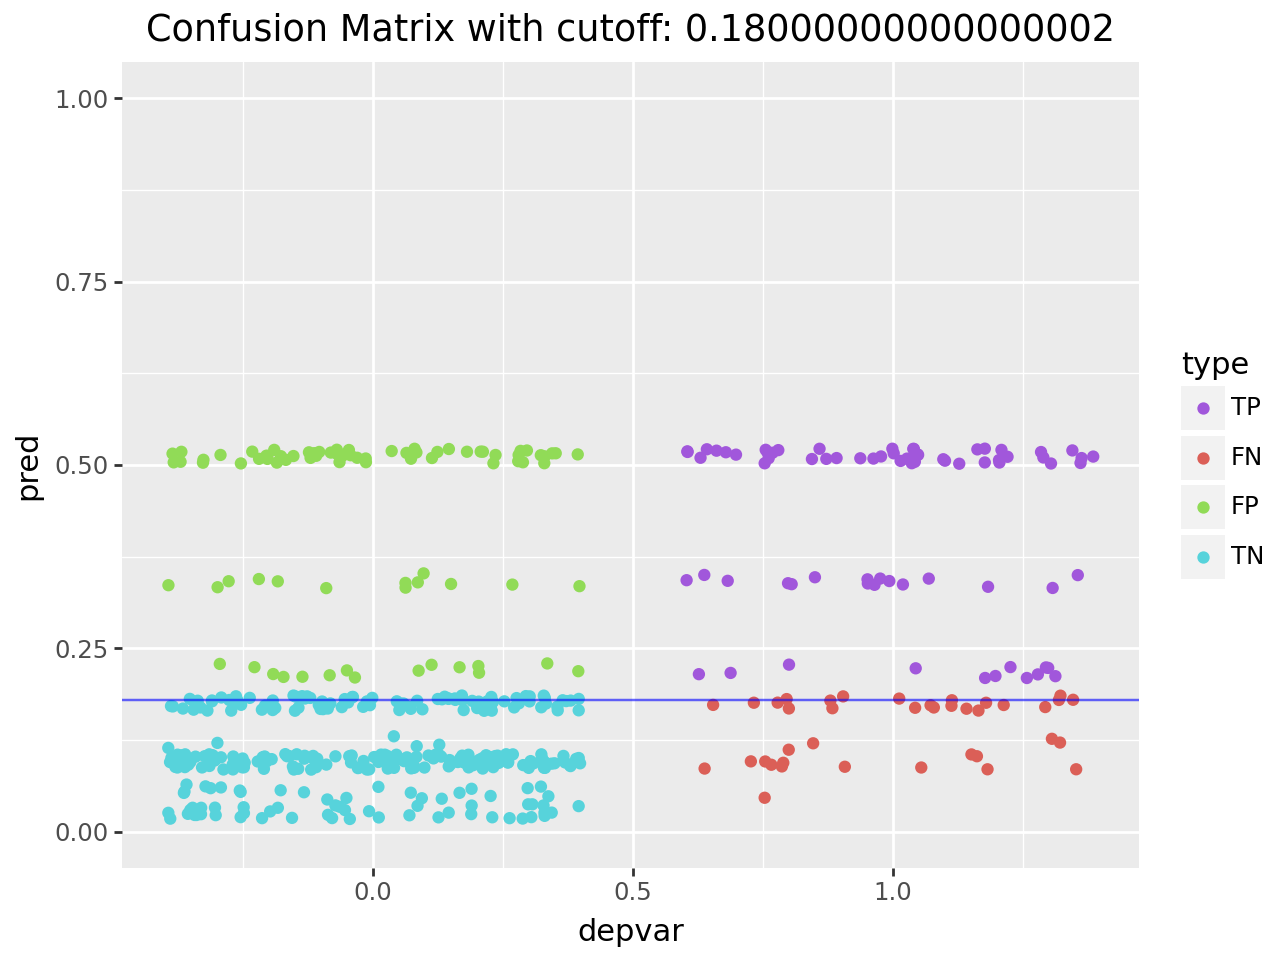

In [147]:
#confusion matrix for cutoff 0.18
def confusionmatrixplot(depvar,pred,cutoff=0.5):
    df=pd.concat([pd.Series(depvar).rename('depvar'),pd.Series(pred).rename('pred')],axis=1)
    def categorize(depvar,pred,cutoff):
        if (pred>=cutoff and depvar==1):
            return 'TP'
        elif (pred>=cutoff and depvar==0):
            return 'FP'
        elif(pred<cutoff and depvar==1):
            return 'FN'
        else:
            return 'TN'
    df['type']=df.apply(lambda X: categorize(X.depvar,X.pred,cutoff), axis=1)
    #plot table
    confusionplot= (pn.ggplot(df, pn.aes(x='depvar',y='pred', color = 'type' ) ) + 
        pn.geom_jitter() + 
        pn.geom_hline( yintercept = cutoff, color = "blue", alpha = 0.6 ) + 
        pn.scale_y_continuous( limits = (0.0,1.0) ) + 
        pn.scale_color_discrete( breaks = [ "TP", "FN", "FP", "TN" ] ) + # ordering of the legend 
        pn.ggtitle("Confusion Matrix with cutoff: "+str(cutoff)))
    confusionplot.show()
    
confusionmatrixplot(test['Churn'],test['predict'],cutoff=optcutoff)

True Positive (TP - Purple) → Correctly identified churners.
False Negative (FN - Red) → Missed churners (actual churners incorrectly predicted as non-churners).
False Positive (FP - Green) → Non-churners incorrectly classified as churners (unnecessary retention efforts).
True Negative (TN - Blue) → Correctly identified non-churners.

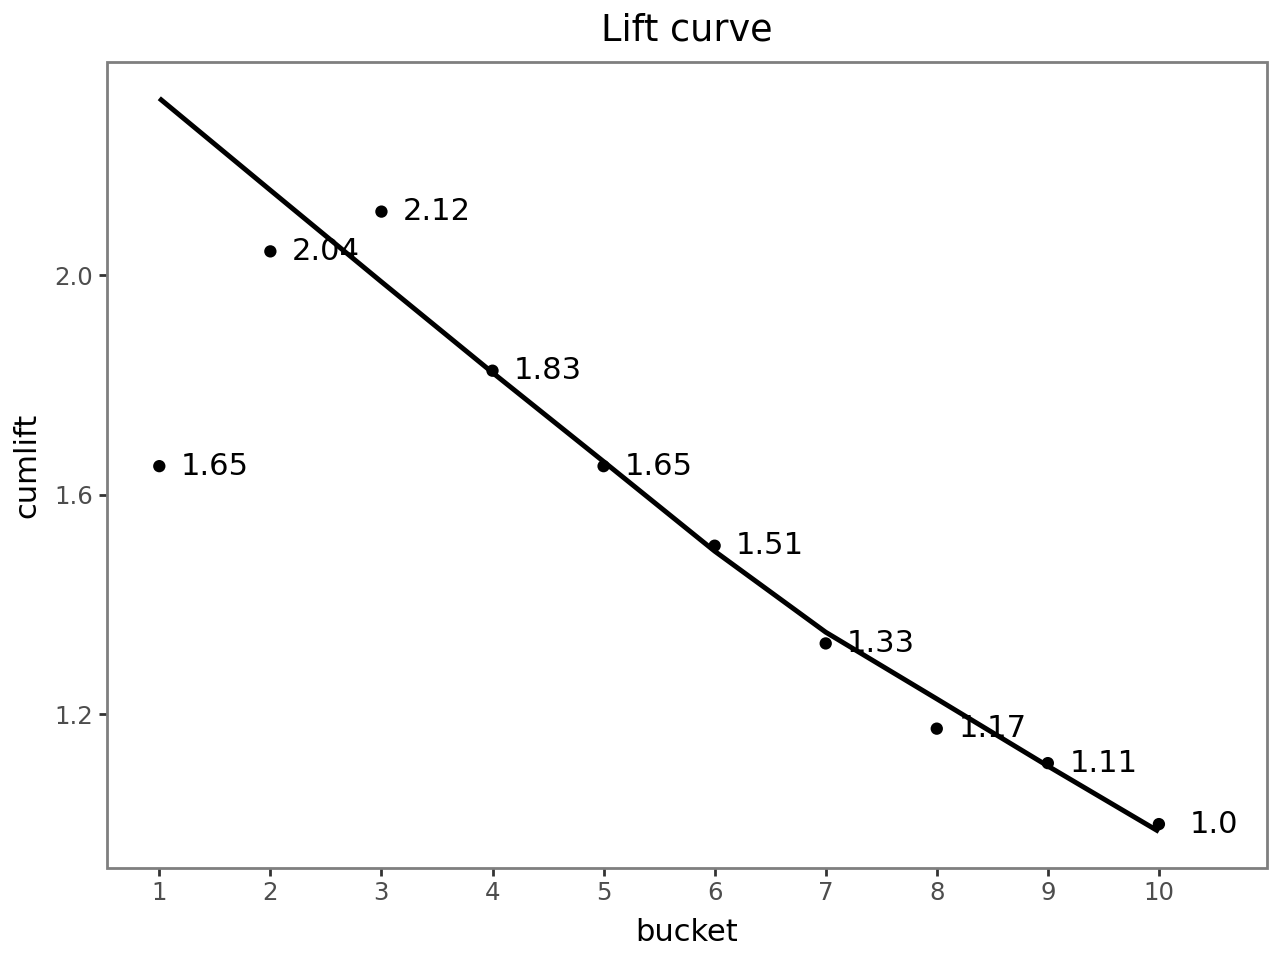

In [149]:
def calc_lift(depvar,pred,groups=10):
        helper=pd.concat([pd.Series(depvar).rename('depvar'),pd.Series(pred).rename('pred')],axis=1)
        #reverse sort dataset based on pred
        helper=helper.sort_values(by=['pred'],ascending=False)
        helper['id']=range(0,len(helper['depvar']))
        #create new bucket variable highest pred in bucket 1
        helper['bucket']=pd.qcut(helper['id'],q=10,labels=range(1, 10+1))
        #convert categorical bucket variable into a numeric one
        helper['bucket']=pd.to_numeric(helper['bucket'])
        #create gaintable: count number of churners per bucket and total customers in a bucket
        lifttable=helper.groupby("bucket", as_index=False).agg(total=('depvar','count'),totalresp=('depvar','sum'))
        #calculate cumulative number of churners
        lifttable['cumresp']=lifttable['totalresp'].cumsum()
        #calculate lift: how many churners did you catch out of the total number of customers in a bucket
        lifttable['lift']=lifttable['cumresp']/sum(lifttable['totalresp'])*100
        #calculate cumulative lift
        lifttable['cumlift']=lifttable['lift']/(lifttable['bucket']*(100/groups))
        return lifttable
    

    
def plot_liftchart(depvar,pred):
    lifttable=calc_lift(depvar,pred)
    liftchart=(pn.ggplot(lifttable, pn.aes(x = 'bucket', y = 'cumlift'))+
      pn.theme_bw() +
      pn.theme(panel_grid = pn.element_blank())+#removes colored box behind bar chart
      pn.scale_x_continuous(breaks=range(1,11)) +
      pn.geom_point()+
      pn.geom_smooth()+
      pn.geom_text(pn.aes(x='bucket+0.5',y='cumlift', label='np.round(cumlift,2)')) +
      pn.ggtitle("Lift curve"))
    liftchart.show()
    return lifttable 
    
lifttabletest=plot_liftchart(test['Churn'],test['predict'])  

In [150]:
lifttabletest

bucket  total  totalresp  cumresp        lift   cumlift
0       1     52         19       19   16.521739  1.652174
1       2     51         28       47   40.869565  2.043478
2       3     51         26       73   63.478261  2.115942
3       4     52         11       84   73.043478  1.826087
4       5     51         11       95   82.608696  1.652174
5       6     51          9      104   90.434783  1.507246
6       7     52          3      107   93.043478  1.329193
7       8     51          1      108   93.913043  1.173913
8       9     51          7      115  100.000000  1.111111
9      10     52          0      115  100.000000  1.000000

### If we contact 10% of the highest ranked customers we should find 16.5% of the churners

## Let's try a more advanced model which does not assume linear relationships: **XGBoost**

In [153]:
X_train = train[['frequency','walkers','socials','grinders','Gender','Age','Experience','fallbonus','monetary_value','recency','Duration','first_wave','third_wave']]
y_train = train['Churn']

X_test = test[['frequency','walkers','socials','grinders','Gender','Age','Experience','fallbonus','monetary_value','recency','Duration','first_wave','third_wave']]  
y_test = test['Churn']


# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=200, random_state=42,max_depth=5,learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [154]:
# Get feature importance scores
feature_importance = xgb_model.feature_importances_
important_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
important_features = important_features.sort_values(by='Importance', ascending=False)
print(important_features)

           Feature  Importance
2          socials    0.336436
7        fallbonus    0.109685
12      third_wave    0.086922
10        Duration    0.053810
6       Experience    0.053208
5              Age    0.052713
9          recency    0.051309
8   monetary_value    0.051306
1          walkers    0.047678
4           Gender    0.046206
0        frequency    0.042042
3         grinders    0.037474
11      first_wave    0.031210


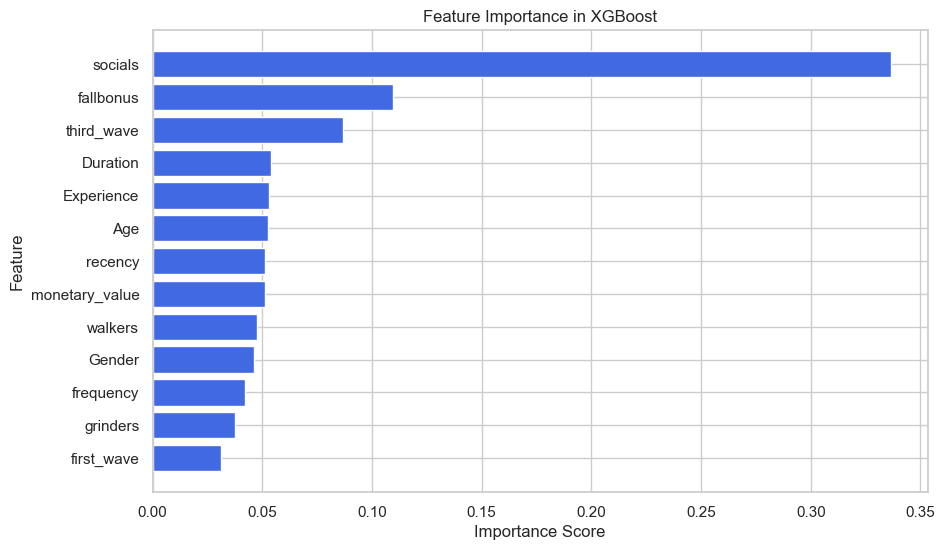

In [155]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'], color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [156]:
y_train = train['Churn']
y_test = test['Churn']
threshold = 0.06 # Adjust as needed
important_features = important_features[important_features['Importance'] > threshold]['Feature'].tolist()

X_train = train[important_features]
X_test = test[important_features]

# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=200, random_state=42,max_depth=5,learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

# Predict probabilities (instead of labels)
test['predict_xgboost'] = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (Churn)

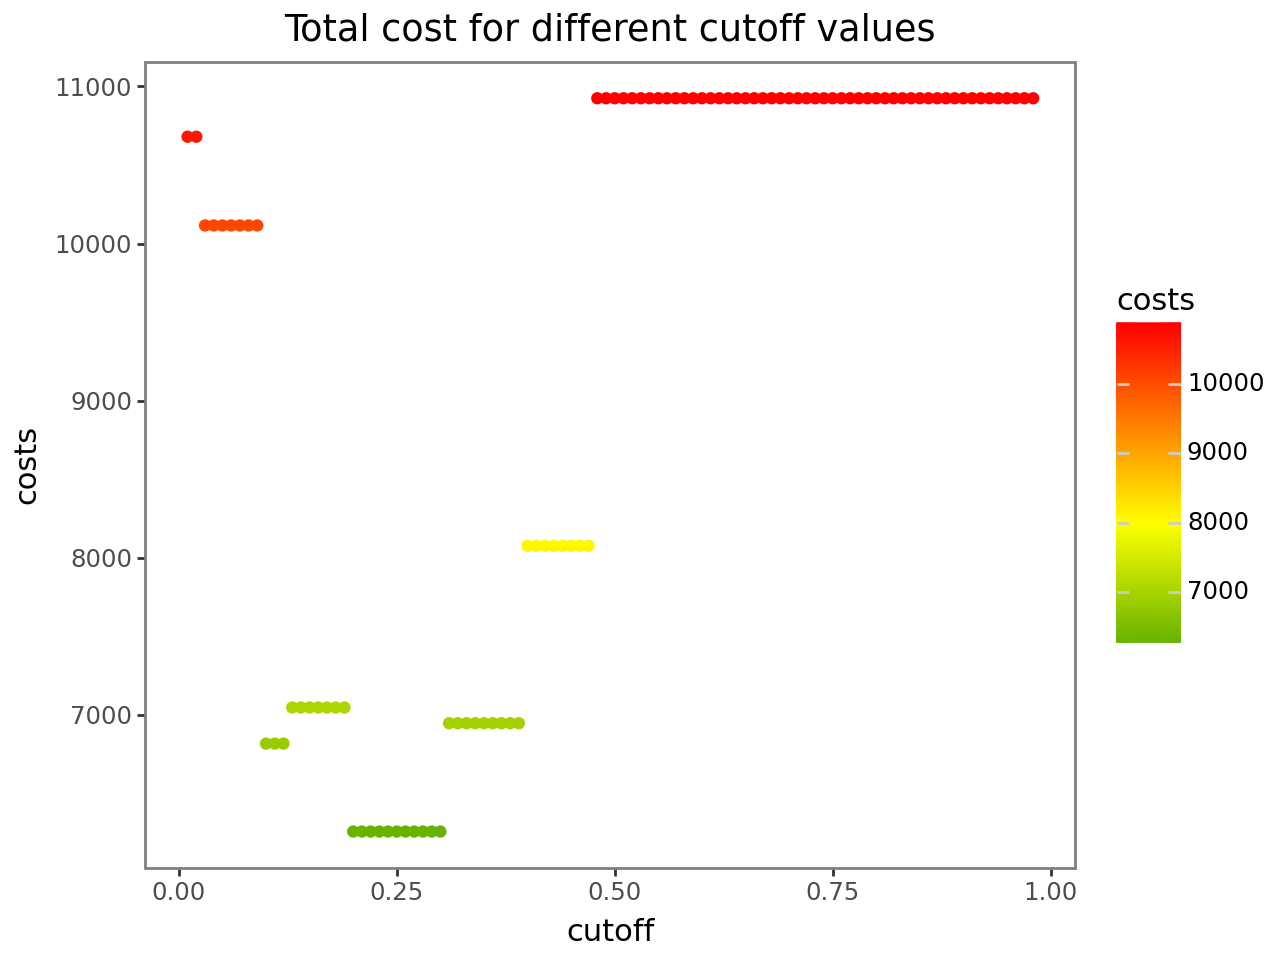

the cutoff that lead to the lowest value is:  0.2


In [157]:
#Apply the optimized cutoff to classify churn
optcutoff=findoptcutoff(test['Churn'],test['predict_xgboost'])
test['final_prediction_xgboost'] = (test['predict_xgboost'] > optcutoff).astype(int)

Cutoff used: 0.2
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          314           85
Actual 1           39           76
Accuracy Score: 75.88%
ROC AUC Score: 77.25%
Precision Score: 47.2%
Sensitivity (Recall) Score: 66.09%
Specificity Score: 78.7%
Log-Likelihood (MLE): -226.8742


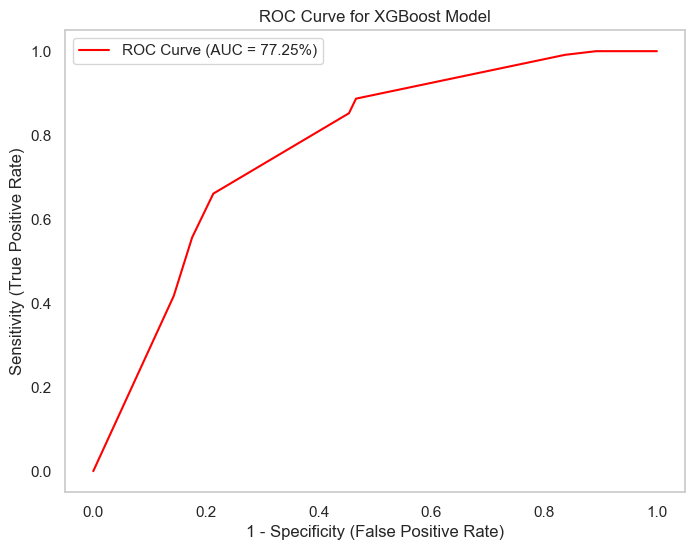

(75.88, 77.25, 47.2, 66.09, 78.7, -226.8741958681494)

In [158]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_xgboost_model(actual, pred_prob, cutoff):
    # Convert probabilities into binary predictions using the optimal cutoff
    pred = (pred_prob > cutoff).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(actual, pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate performance metrics
    Accuracy = round(accuracy_score(actual, pred) * 100, 2)
    Roc_auc = round(roc_auc_score(actual, pred_prob) * 100, 2)
    Precision = round(precision_score(actual, pred) * 100, 2)
    Recall = round(recall_score(actual, pred) * 100, 2)  # Sensitivity
    Specificity = round((tn / (tn + fp)) * 100, 2) if (tn + fp) > 0 else 0

    # Log-Likelihood (MLE Calculation)
    epsilon = 1e-9  # Prevents log(0) error
    log_likelihood = np.sum(actual * np.log(pred_prob + epsilon) + (1 - actual) * np.log(1 - pred_prob + epsilon))


    # Print results
    print(f"Cutoff used: {cutoff}")
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print(f"Accuracy Score: {Accuracy}%")
    print(f"ROC AUC Score: {Roc_auc}%")
    print(f"Precision Score: {Precision}%")
    print(f"Sensitivity (Recall) Score: {Recall}%")
    print(f"Specificity Score: {Specificity}%")
    print(f"Log-Likelihood (MLE): {round(log_likelihood, 4)}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(actual, pred_prob)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {Roc_auc}%)')
    plt.xlabel("1 - Specificity (False Positive Rate)")
    plt.ylabel("Sensitivity (True Positive Rate)")
    plt.title("ROC Curve for XGBoost Model")
    plt.legend()
    plt.grid()
    plt.show()

    return Accuracy, Roc_auc, Precision, Recall, Specificity, log_likelihood

# Evaluate the XGBoost model using the optimal cutoff
evaluate_xgboost_model(test['Churn'], test['predict_xgboost'], optcutoff)

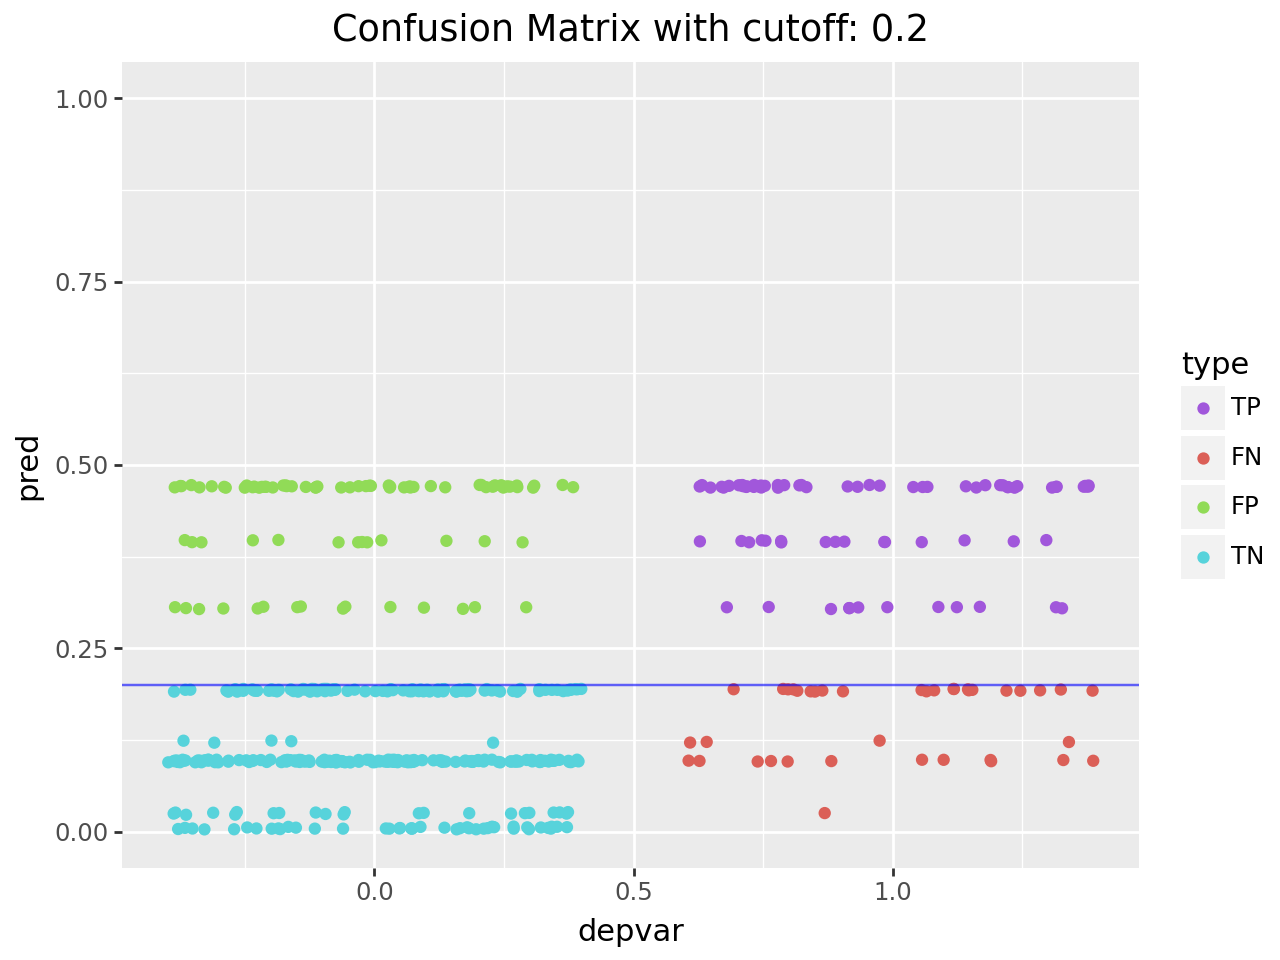

In [159]:
confusionmatrixplot(test['Churn'],test['predict_xgboost'],cutoff=optcutoff)

## Churn analysis based on player behavior

In [161]:
# Extract unique CustomerIDs from both datasets
summer_players = set(summersesstrx['CustomerID'])
fall_players = set(fallsesstrx['CustomerID'])

# Identify churners and non-churners
non_churners = summer_players & fall_players  # Present in both datasets
churners = summer_players - fall_players  # Present in summer but not in fall

# Create the churn dataframe
churn_dataset = {
    'CustomerID': list(non_churners) + list(churners),
    'Churn_Status': ['non churner'] * len(non_churners) + ['churner'] * len(churners)

}

playerchurn = pd.DataFrame(churn_dataset)
playerchurn = playerchurn.merge(summersesstrx, on="CustomerID", how="left")
playerchurn = playerchurn.merge(active_summer_customer_data, on="CustomerID", how="left")
playerchurn = playerchurn.assign(
    Churn=[1 if Churn_Status == 'churner' else 0 for Churn_Status in playerchurn['Churn_Status']],
)
playerchurn

CustomerID Churn_Status  PlayID   date_min  Experience  Huntingcabins  \
0              1  non churner       3 2022-06-16       12465             56   
1              2  non churner       1 2022-07-08        4540             16   
2              3  non churner       3 2022-05-23       19970             37   
3              4  non churner       4 2022-05-30       19274             70   
4              5  non churner       1 2022-07-18        3554             16   
...          ...          ...     ...        ...         ...            ...   
4698        4056      churner       2 2022-07-19        8560             23   
4699        4068      churner      10 2022-05-08       43798            179   
4700        2024      churner      11 2022-05-02       59284            127   
4701        2041      churner       2 2022-07-23        6675             29   
4702        4091      churner       6 2022-05-22       29391             77   

      Trainingschools  Huntinggrounds  Social  Monsters  ...  Income  Wave  \
0                  26               0       2        75  ...       1     2   
1                  12               0       0        24  ...       1     3   
2                  17              11       6        40  ...       2     1   
3                  35               1       0       144  ...       2     2   
4                   5               0       1        21  ...       1     2   
...               ...             ...     ...       ...  ...     ...   ...   
4698               14               2       5        25  ...       2     1   
4699               85               1       1       300  ...       2     1   
4700               95              22      18       132  ...       3     3   
4701               10               0       4        28  ...       1     3   
4702               30              10      22        72  ...       1     3   

      walkers socials  grinders  low_income  medium_income  first_wave  \
0           0       0         1           1              0           0   
1           0       0         1           1              0           0   
2           0       1         0           0              1           1   
3           0       0         1           0              1           0   
4           0       0         1           1              0           0   
...       ...     ...       ...         ...            ...         ...   
4698        0       1         0           0              1           1   
4699        0       0         1           0              1           1   
4700        0       1         0           0              0           0   
4701        0       0         0           1              0           0   
4702        0       1         0           1              0           0   

      third_wave  Churn  
0              0      0  
1              1      0  
2              0      0  
3              0      0  
4              0      0  
...          ...    ...  
4698           0      1  
4699           0      1  
4700           1      1  
4701           1      1  
4702           1      1  

[4703 rows x 27 columns]

In [162]:
# Group by CustomerType and calculate churn rate
churn_by_player_type = playerchurn.groupby("CustomerType")["Churn"].mean()
# Print churn rates
print(churn_by_player_type)

CustomerType
1    0.105824
2    0.146363
3    0.061947
4    0.079143
Name: Churn, dtype: float64


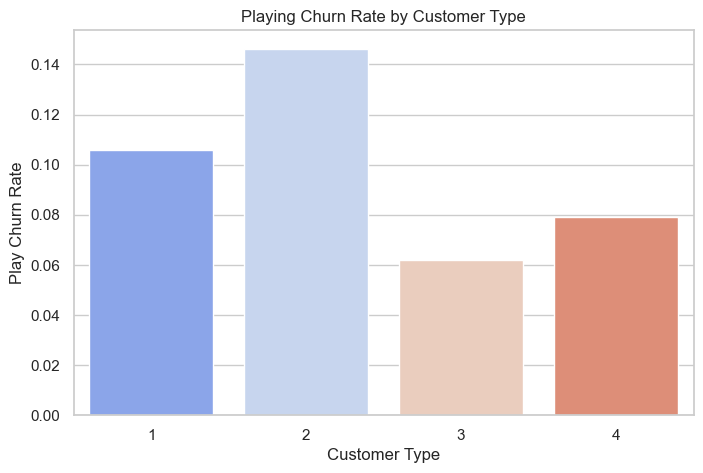

In [163]:
plt.figure(figsize=(8,5))
sns.barplot(x=churn_by_player_type.index, y=churn_by_player_type.values, palette="coolwarm")
plt.xlabel("Customer Type")
plt.ylabel("Play Churn Rate")
plt.title("Playing Churn Rate by Customer Type")
plt.show()

# Socials don't make transactions anymore in the fall (so they are transaction churners), but they still play a lot.

Players can spend earned coins or purchase coins with real money to buy cosmetic
items and resources in the in-game store.

# CLV ANALYSIS

In [167]:
clv=churn_data[['CustomerID','frequency','recency','monetary_value','T','CustomerType','Churn']]
clv = clv[clv['frequency']>0]

In [168]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])
t = 360 # 30 day period
clv['expected_purc_1_year'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_1_year',ascending=False)

CustomerID  frequency  recency  monetary_value    T  CustomerType  \
129          448          3       38           17.97   40             4   
593         2163          2        0           19.98    2             3   
1270        4635          2        2           14.98    5             3   
830         2976          2        0           27.99    4             3   
249          821          2       13            5.98   13             3   
...          ...        ...      ...             ...  ...           ...   
1572         943          3        8           10.97  119             3   
1034        3819          2        3           29.99  112             4   
1097        4050          2        7           14.98  120             4   
383         1344          2        4            7.98  118             3   
399         1401          3        1           22.97  116             3   

      Churn  expected_purc_1_year  
129       0              6.756682  
593       0              6.337021  
1270      0              6.243852  
830       0              6.233629  
249       0              6.165056  
...     ...                   ...  
1572      1              1.501953  
1034      0              1.483869  
1097      0              1.414231  
383       0              1.365920  
399       0              1.312626  

[1711 rows x 8 columns]

In [169]:
clv[['frequency','monetary_value']].corr()

frequency  monetary_value
frequency        1.000000        0.363323
monetary_value   0.363323        1.000000

In [170]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1711 subjects, p: 3.26, q: 1.42, v: 2.43>

The Gamma-Gamma model (GGF) estimates monetary value per purchase, assuming that customers with higher spending in the past will continue spending at a similar rate.
This helps in converting predicted purchase frequency into expected revenue.

In [172]:
clv['clv']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=12,
                                   freq='D',
                                   discount_rate=0.02)

acquisition_cost = 10
clv['clv'] = clv['clv'] - acquisition_cost
#clv = clv.merge(active_summer_customer_data[['CustomerID', 'CustomerType']], on='CustomerID', how='left')
clv

CustomerID  frequency  recency  monetary_value    T  CustomerType  \
0              5          3        9           19.97   59             4   
1              9          1      115            4.99  115             1   
2             10          1       23            4.99   23             1   
3             17          1       39            4.99   39             2   
4             20          1       60            2.99   60             1   
...          ...        ...      ...             ...  ...           ...   
1706        1941          2       71            7.98   72             3   
1707        4010          1       95            4.99   95             3   
1708        4034          2       39           27.99   52             3   
1709        2013          1       80            2.99   80             1   
1710        2034          1       43            9.99   43             3   

      Churn  expected_purc_1_year         clv  
0         0              4.445960   69.010687  
1         0              3.696075   11.639356  
2         0              4.731669   17.774085  
3         0              4.508586   16.450561  
4         0              4.247937    8.188691  
...     ...                   ...         ...  
1706      1              5.161851   29.763702  
1707      1              3.878254   12.716777  
1708      1              5.176234  116.738800  
1709      1              4.027962    7.237274  
1710      1              4.456310   33.765348  

[1711 rows x 9 columns]

The customer_lifetime_value() function applies a discount rate (2%) to account for the time value of money.
This ensures that future cash flows are not overestimated.

In [174]:
clv.sort_values('clv',ascending=False)
clv.describe()

CustomerID    frequency      recency  monetary_value            T  \
count  1711.000000  1711.000000  1711.000000     1711.000000  1711.000000   
mean   2455.769725     1.315020    56.578025       10.982636    68.059030   
std    1454.140121     0.590967    34.569731       14.778282    34.537149   
min       5.000000     1.000000     0.000000        2.990000     0.000000   
25%    1165.000000     1.000000    27.000000        2.990000    39.000000   
50%    2422.000000     1.000000    54.000000        4.990000    71.000000   
75%    3732.000000     2.000000    85.000000        9.990000    99.000000   
max    5000.000000     5.000000   122.000000      128.990000   122.000000   

       CustomerType        Churn  expected_purc_1_year          clv  
count   1711.000000  1711.000000           1711.000000  1711.000000  
mean       2.576856     0.200468              4.184563    33.840754  
std        1.118594     0.400467              0.670196    51.423426  
min        1.000000     0.000000              1.312626    -0.579079  
25%        2.000000     0.000000              3.840307    10.379693  
50%        3.000000     0.000000              4.201905    16.140571  
75%        4.000000     0.000000              4.617215    35.225200  
max        4.000000     1.000000              6.756682   593.193768

In [175]:
count_clv_negative = (clv['clv'] < 0).sum()
print(f"Number of rows with clv < 0: {count_clv_negative}")
# Remove rows where 'clv' is less than 0
clv = clv[clv['clv'] >= 0]
# Reset index after deletion 
clv = clv.reset_index(drop=True)

Number of rows with clv < 0: 1


In [176]:
clv['Segment'] =  pd.qcut(clv['clv'],4,labels = ['Hibernating','Need Attention', 'LoyalCustomers', 'Champions'])

In [177]:
clv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   CustomerID            1710 non-null   int64   
 1   frequency             1710 non-null   int64   
 2   recency               1710 non-null   int64   
 3   monetary_value        1710 non-null   float64 
 4   T                     1710 non-null   int64   
 5   CustomerType          1710 non-null   int64   
 6   Churn                 1710 non-null   int64   
 7   expected_purc_1_year  1710 non-null   float64 
 8   clv                   1710 non-null   float64 
 9   Segment               1710 non-null   category
dtypes: category(1), float64(3), int64(6)
memory usage: 122.2 KB


In [178]:
table_1=clv.groupby('Segment').mean()
table_1

CustomerID  frequency    recency  monetary_value          T  \
Segment                                                                        
Hibernating     2390.955916   1.069606  68.401392        3.295568  74.081206   
Need Attention  2486.820755   1.110849  65.042453        4.962948  71.582547   
LoyalCustomers  2494.911422   1.417249  46.874126        8.440443  61.018648   
Champions       2450.497653   1.661972  46.089202       27.323192  65.453052   

                CustomerType     Churn  expected_purc_1_year        clv  
Segment                                                                  
Hibernating         2.280742  0.146172              4.019078   7.630142  
Need Attention      2.502358  0.176887              4.086827  13.013671  
LoyalCustomers      2.738928  0.256410              4.311209  24.866251  
Champions           2.788732  0.223005              4.327880  90.206806

In [179]:
table_2=clv.drop('Segment', axis=1)
table_2=table_2.groupby('CustomerType').mean()
table_2

CustomerID  frequency    recency  monetary_value          T  \
CustomerType                                                                 
1             2379.074699   1.195181  61.532530        8.671205  68.771084   
2             2477.961652   1.259587  58.917404        9.227522  68.669617   
3             2468.839216   1.468627  52.641176       14.689882  69.596078   
4             2494.820628   1.291480  54.811659       10.239439  65.082960   

                 Churn  expected_purc_1_year        clv  
CustomerType                                             
1             0.115663              4.179644  26.330811  
2             0.100295              4.188967  29.080101  
3             0.425490              4.145110  45.330819  
4             0.098655              4.236782  31.385539

In [180]:
# Grouping CLV by customer type
clv_summary = clv.groupby('CustomerType')['clv'].agg(['mean', 'median', 'std', 'count']).reset_index()
clv_summary.columns = ['Customer Type', 'Mean CLV', 'Median CLV', 'CLV Std Dev', 'Count']
clv_summary

Customer Type   Mean CLV  Median CLV  CLV Std Dev  Count
0              1  26.330811   12.888287    38.615585    415
1              2  29.080101   13.664443    55.683689    339
2              3  45.330819   26.488250    63.444643    510
3              4  31.385539   17.585870    39.813328    446

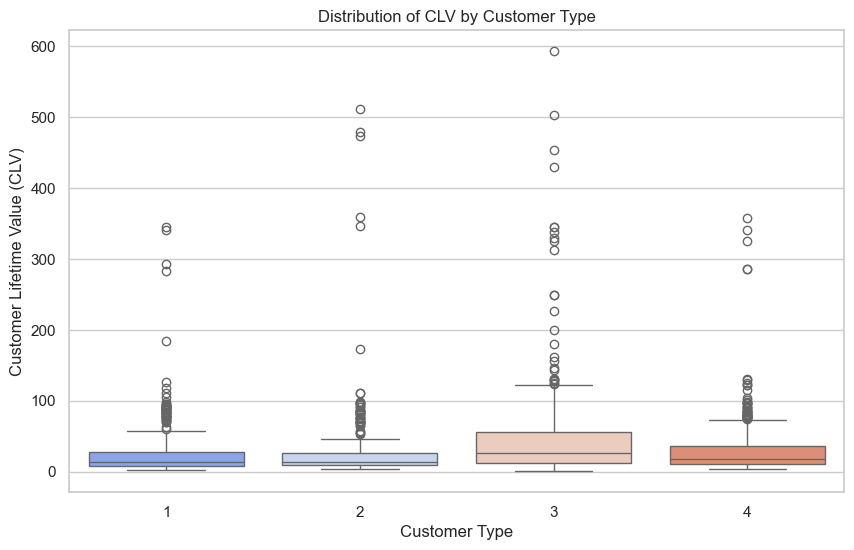

In [181]:
# Boxplot to visualize CLV spread across customer types
plt.figure(figsize=(10, 6))
sns.boxplot(x='CustomerType', y='clv', data=clv, palette="coolwarm")
plt.title("Distribution of CLV by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Customer Lifetime Value (CLV)")
plt.show()

Socials have the highest CLV, but also the highest churn rate (25.6%), making them a key retention target.
Grinders have stable spending patterns and are good long-term customers.
Walkers & Miscellaneous have lower CLV, but contain valuable outliers that should be nurtured.
Presence of extreme outliers in all segments, meaning a subset of players contribute significantly more revenue.
3. Strategic Recommendations
 Prioritize Socials & Grinders for retention → Offer exclusive content, in-game rewards, and personalized experiences.
 Engage Walkers & Miscellaneous better → Use location-based incentives, casual-friendly events, and seasonal promos.
 Identify and retain high-value outliers → Develop loyalty programs & VIP experiences for super-spenders.